# Imports and setup

In [1]:
# Basic
import numpy as np
import scipy
import scipy.stats
import os
import itertools
import warnings
import sys
from copy import deepcopy

# Data Loading
import cmlreaders as cml #Penn Computational Memory Lab's library of data loading functions

# Data Handling
import os
from os import listdir as ld
import os.path as op
from os.path import join, exists as ex
import time
import datetime

# Data Analysis
import pandas as pd
import xarray as xr

# EEG & Signal Processing
import ptsa
from ptsa.data.readers import BaseEventReader, EEGReader, CMLEventReader, TalReader
from ptsa.data.filters import MonopolarToBipolarMapper, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parallelization
import cmldask.CMLDask as da
from cmldask.CMLDask import new_dask_client_slurm as cl
from cluster import wait, get_exceptions_quiet as get_ex
import cmldask

%load_ext autoreload
%autoreload 2


# Custom
from cstat import * #circular statistics
from misc import * #helper functions for loading and saving data, and for other purposes
from matrix_operations import * #matrix operations

USERNAME = get_username_from_working_directory(index=2)
root_dir = f'/scratch/{USERNAME}/retrieval_connectivity'

# specify hypothesis for end-to-end testing of this analysis pipeline with simulated EEG data
simulation_tag = 'null_connectivity'
is_simulation = simulation_tag not in ['standard', '', None]
from simulate_eeg import AVAILABLE_SIMULATIONS, simulation_parameters, NULL_SIMULATION_TAGS
parameters = simulation_parameters[simulation_tag]

if is_simulation:
    assert simulation_tag in AVAILABLE_SIMULATIONS
    oscillation_frequency = parameters['oscillation_frequency']
    print(f'RUNNING PIPELINE SIMULATION "{simulation_tag}"...\n'
          'Simulation parameters:')
    display(parameters)
    root_dir = os.path.join(root_dir, 'simulation_tests', simulation_tag)

if not os.path.exists(root_dir):
    os.makedirs(root_dir)

import helper
from helper import *
helper.root_dir = root_dir

from functools import partial
cluster_log_dir = 'cluster'
cl = partial(cl, log_directory=cluster_log_dir)
if not os.path.exists(cluster_log_dir):
    os.mkdir(cluster_log_dir)

figure_path = 'figures'
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

font_dirs = ['fonts']

warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='DataFrame is highly fragmented')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/ptsa/data/readers/__init__.py:16: FutureWarning: PTSA readers will be removed in a future release. Please consider using the cmlreaders package instead: https://github.com/pennmem/cmlreaders
  warnings.warn(


RUNNING PIPELINE SIMULATION "null_connectivity"...
Simulation parameters:


{'wavelet_amplitude': 0,
 'phase_covariance_function': None,
 'oscillation_frequency': 5,
 'morlet_reps': 5,
 'pinknoise_amplitude': 100,
 'pinknoise_exponent': 1}

In [2]:
# import shutil
# for f1 in ['en', 'en_all', 'rm', 'ri']:
# #     path = join(root_dir, f1)
# #     if ex(path): shutil.rmtree(path)
# #     for f2 in ['events', 'elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
#     # for f2 in ['elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
#     for f2 in ['elpomxs', 'regpomxs']:
#         path = join(root_dir, f1, f2)
#         if ex(path): shutil.rmtree(path)
# # path = join(root_dir, 'data_check')
# # if ex(path): shutil.rmtree(path)
# # path = join(root_dir, 'behavioral_stats')
# # if ex(path): shutil.rmtree(path)
# # path = join(root_dir, 'electrode_information')
# # if ex(path): shutil.rmtree(path)

In [3]:
for f1 in ['en', 'en_all', 'rm', 'ri']:
    path = join(root_dir, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['eeg', 'events', 'elsymxs', 'regsymxs']:
        path = join(root_dir, f1, f2)
        if not ex(path): os.mkdir(path)
    for f2 in ['elpomxs', 'regpomxs']:
        path = join(root_dir, f1, f2)
        if not ex(path): os.mkdir(path)
        for f3 in ['theta', 'gamma']:
            path = join(root_dir, f1, f2, f3)
            if not ex(path): os.mkdir(path)
path = join(root_dir, 'data_check')
if not ex(path): os.mkdir(path)
path = join(root_dir, 'behavioral_stats')
if not ex(path): os.mkdir(path)
path = join(root_dir, 'electrode_information')
if not ex(path): 
    os.mkdir(path)
    os.mkdir(join(path, 'pairs'))
    os.mkdir(join(path, 'localization'))

# Create dataset

## Initialize dataset

"ethan_subject_list," etc. refers to the subject list used by Ethan A. Solomon in his 2017 Nature Communications paper, "Widespread theta synchrony underlies enhanced cognition," and it was taken from the publicly available code for that paper.

The initial dataset was created by checking the CMLReaders data index for all pyFR, catFR1, and FR1 sessions (all delayed free recall sessions collected by the Penn Computational Memory Lab). Just in case, the presumed session list (see code) that Ethan Solomon used for his 2017 paper was appended as well.

The sessions were then checked to ensure that all necessary data, including the behavioral events, EEG data, and electrode contact locations, were available and unproblematic.

In [4]:
ethan_subject_list = [['R1031M', 'FR1'],['R1033D', 'FR1'],['R1042M', 'FR1'],['R1044J', 'FR1'],['R1039M', 'FR1'],['R1048E', 'FR1'],['R1035M', 'FR1'],['R1030J', 'FR1'],['R1050M', 'FR1'],['R1053M', 'FR1'],['R1036M', 'FR1'],['R1018P', 'FR1'],['R1020J', 'FR1'],['R1026D', 'FR1'],['R1032D', 'FR1'],['R1056M', 'FR1'],['R1002P', 'FR1'],['R1027J', 'FR1'],['R1045E', 'FR1'],['R1057E', 'FR1'],['R1063C', 'FR1'],['R1001P', 'FR1'],['R1003P', 'FR1'],['R1015J', 'FR1'],['R1049J', 'FR1'],['R1022J', 'FR1'],['R1074M', 'FR1'],['R1069M', 'FR1'],['R1076D', 'FR1'],['R1102P', 'FR1'],['R1023J', 'FR1'],['R1155D', 'FR1'],['R1162N', 'FR1'],['R1086M', 'FR1'],['R1149N', 'FR1'],['R1034D', 'FR1'],['R1051J', 'FR1'],['R1159P', 'FR1'],['R1101T', 'FR1'],['R1178P', 'FR1'],['R1104D', 'FR1'],['R1089P', 'FR1'],['R1105E', 'FR1'],['R1060M', 'FR1'],['R1186P', 'FR1'],['R1112M', 'FR1'],['R1202M', 'FR1'],['R1066P', 'FR1'],['R1084T', 'FR1'],['R1096E', 'FR1'],['R1176M', 'FR1'],['R1187P', 'FR1'],['R1169P', 'FR1'],['R1081J', 'FR1'],['R1006P', 'FR1'],['R1164E', 'FR1'],['R1196N', 'FR1'],['R1127P', 'FR1'],['R1010J', 'FR1'],['R1175N', 'FR1'],['R1148P', 'FR1'],['R1203T', 'FR1'],['R1193T', 'FR1'],['R1167M', 'FR1'],['R1075J', 'FR1'],['R1177M', 'FR1'],['R1080E', 'FR1'],['R1161E', 'FR1'],['R1068J', 'FR1'],['R1054J', 'FR1'],['R1195E', 'FR1'],['R1189M', 'FR1'],['R1131M', 'FR1'],['R1200T', 'FR1'],['R1100D', 'FR1'],['R1142N', 'FR1'],['R1114C', 'FR1'],['R1247P', 'FR1'],['R1128E', 'FR1'],['R1138T', 'FR1'],['R1059J', 'FR1'],['R1067P', 'FR1'],['R1215M', 'FR1'],['R1111M', 'FR1'],['R1171M', 'FR1'],['R1106M', 'FR1'],['R1129D', 'FR1'],['R1146E', 'FR1'],['R1098D', 'FR1'],['R1130M', 'FR1'],['R1115T', 'FR1'],['R1150J', 'FR1'],['R1173J', 'FR1'],['R1154D', 'FR1'],['R1136N', 'FR1'],['R1137E', 'FR1'],['R1204T', 'FR1'],['R1174T', 'FR1'],['R1230J', 'FR1'],['R1122E', 'FR1'],['R1229M', 'FR1'],['R1158T', 'FR1'],['R1163T', 'FR1'],['R1250N', 'FR1'],['R1147P', 'FR1'],['R1166D', 'FR1'],['R1241J', 'FR1'],['R1123C', 'FR1'],['R1120E', 'FR1'],['R1083J', 'FR1'],['R1113T', 'FR1'],['R1226D', 'FR1'],['R1228M', 'FR1'],['R1062J', 'FR1'],['R1232N', 'FR1'],['R1217T', 'FR1'],['R1151E', 'FR1'],['R1070T', 'FR1'],['R1121M', 'FR1'],['R1222M', 'FR1'],['R1168T', 'FR1'],['R1172E', 'FR1'],['R1223E', 'FR1'],['R1134T', 'FR1'],['R1077T', 'FR1'],['R1094T', 'FR1'],['R1260D', 'FR1'],['R1061T', 'FR1'],['R1243T', 'FR1'],['R1191J', 'FR1'],['R1240T', 'FR1'],['R1231M', 'FR1'],['R1234D', 'FR1'],['R1135E', 'FR1'],['R1004D', 'catFR1'],['R1065J', 'FR1'],['R1236J', 'FR1'],['R1016M', 'catFR1'],['R1021D', 'catFR1'],['R1028M', 'catFR1'],['R1041M', 'catFR1'],['R1029W', 'catFR1'],['R1119P', 'catFR1'],['R1107J', 'catFR1'],['R1141T', 'catFR1'],['R1144E', 'catFR1'],['R1188C', 'catFR1'],['R1180C', 'catFR1'],['R1157C', 'catFR1'],['R1181E', 'catFR1'],['R1190P', 'catFR1'],['R1227T', 'catFR1'],['R1192C', 'catFR1'],['R1221P', 'catFR1'],['R1239E', 'catFR1'],['R1273D', 'catFR1'],['TJ017', 'pyFR'],['TJ018_2', 'pyFR'],['TJ018', 'pyFR'],['TJ019', 'pyFR'],['TJ021', 'pyFR'],['TJ020', 'pyFR'],['TJ024', 'pyFR'],['TJ027', 'pyFR'],['TJ022', 'pyFR'],['TJ028', 'pyFR'],['TJ029', 'pyFR'],['TJ033', 'pyFR'],['TJ030', 'pyFR'],['TJ031', 'pyFR'],['TJ025', 'pyFR'],['TJ032', 'pyFR'],['TJ036', 'pyFR'],['TJ034', 'pyFR'],['TJ037', 'pyFR'],['TJ035_1', 'pyFR'],['TJ038_1', 'pyFR'],['TJ038', 'pyFR'],['TJ040_1', 'pyFR'],['TJ040', 'pyFR'],['TJ042', 'pyFR'],['TJ041', 'pyFR'],['TJ043', 'pyFR'],['TJ041_2', 'pyFR'],['TJ039', 'pyFR'],['TJ044', 'pyFR'],['TJ045', 'pyFR'],['TJ047', 'pyFR'],['TJ048', 'pyFR'],['TJ049', 'pyFR'],['TJ052', 'pyFR'],['TJ053_2', 'pyFR'],['TJ053_3', 'pyFR'],['TJ055', 'pyFR'],['TJ054', 'pyFR'],['TJ056', 'pyFR'],['TJ058', 'pyFR'],['TJ057', 'pyFR'],['TJ059', 'pyFR'],['TJ061', 'pyFR'],['TJ064', 'pyFR'],['TJ062_2', 'pyFR'],['TJ060', 'pyFR'],['TJ065', 'pyFR'],['TJ064_1', 'pyFR'],['TJ066', 'pyFR'],['TJ068', 'pyFR'],['TJ069_1', 'pyFR'],['TJ069', 'pyFR'],['TJ071', 'pyFR'],['TJ072', 'pyFR'],['TJ074_1', 'pyFR'],['TJ073', 'pyFR'],['TJ074', 'pyFR'],['TJ077', 'pyFR'],['TJ078_1', 'pyFR'],['TJ078', 'pyFR'],['TJ081', 'pyFR'],['TJ079', 'pyFR'],['TJ080', 'pyFR'],['UP016', 'pyFR'],['UP017', 'pyFR'],['UP019', 'pyFR'],['UP020', 'pyFR'],['UP022', 'pyFR'],['UP021', 'pyFR'],['UP028', 'pyFR'],['UP024', 'pyFR'],['UP029', 'pyFR'],['UP034', 'pyFR'],['UP036', 'pyFR'],['UP038', 'pyFR'],['UP037', 'pyFR'],['UP042', 'pyFR'],['UP041', 'pyFR'],['UP040', 'pyFR'],['UP044_1', 'pyFR'],['UP043', 'pyFR'],['UP044', 'pyFR'],['UP045', 'pyFR'],['R1153T', 'FR1'],['R1156D', 'FR1'],['R1207J', 'FR1'],['TJ051', 'pyFR'],['R1052E_1', 'FR1'],['R1052E_2', 'FR1'],['R1055J', 'FR1'],['R1059J_1', 'FR1'],['R1063C_1', 'FR1'],['R1066P_1', 'FR1'],['R1083J_1', 'FR1'],['R1092J_2', 'FR1'],['R1108J_1', 'FR1'],['R1118N_1', 'FR1'],['R1124J_1', 'FR1'],['R1127P_1', 'FR1'],['R1145J_1', 'FR1'],['TJ086', 'FR1'],['UT009', 'FR1'],['R1170J_1', 'FR1'],['R1171M_1', 'FR1'],['R1092J_3', 'FR1'],['R1185N_1', 'FR1'],['R1201P_1', 'FR1'],['R1216E_1', 'FR1'],['R1291M', 'FR1'],['R1093J', 'catFR1'],['R1013E_1', 'catFR1'],['R1024E_1', 'catFR1'],['R1092J', 'catFR1'],['R1108J', 'catFR1'],['R1127P_2', 'catFR1'],['R1135E_1', 'catFR1'],['R1138T_1', 'catFR1'],['TJ084', 'catFR1'],['R1191J_1', 'catFR1'],['R1247P_1', 'catFR1'],['R1269E_1', 'catFR1'],['R1278E_1', 'catFR1'],['FR150', 'pyFR'],['FR160', 'pyFR'],['FR190', 'pyFR'],['FR220', 'pyFR'],['FR230', 'pyFR']]
ethan_subject_list = np.asarray(ethan_subject_list)
print(f'{len(np.unique(ethan_subject_list[:, 0]))} subjects in Ethan Solomon\'s dataset.')

284 subjects in Ethan Solomon's dataset.


In [5]:
ethan_sess_list = []
data_index = cml.get_data_index()
for subexp in ethan_subject_list:
    sub, exp = subexp
    sess_list = data_index.query('subject == @sub & experiment == @exp')[['session', 'localization', 'montage']].to_numpy()
    for r in sess_list:
        sess, loc, mon = r
        sess, loc, mon = int(sess), int(loc), int(mon)
        row = np.asarray([sub, exp, sess, loc, mon], dtype='object')
        ethan_sess_list.append(row)
ethan_sess_list = np.asarray(ethan_sess_list)
ethan_sess_list = pd.DataFrame(ethan_sess_list, columns=['subject', 'experiment', 'session', 'localization', 'montage'])

In [6]:
data_index = cml.get_data_index()
cmlreaders_sess_list = data_index.query('experiment in ["pyFR", "catFR1", "FR1"]')[['subject', 'experiment', 'session', 'localization', 'montage']]

In [7]:
sess_list_df = pd.concat([cmlreaders_sess_list, ethan_sess_list], axis=0).drop_duplicates(ignore_index=True)
sess_list_df = sess_list_df.rename({'subject': 'sub', 'experiment': 'exp', 'session': 'sess', 'localization': 'loc', 'montage': 'mon'}, axis=1)
sess_list_df.to_csv(join(root_dir, 'sess_list_df_initial.csv'), index=False)

## Check data availability

See here for more details about the electrode localization procedures used to assign region labels and coordinates to the analyzed contacts: https://github.com/pennmem/neurorad_pipeline/blob/master/RELEASE_NOTES.md.

In [8]:
dfrows=[('R1063C', 'FR1', 1, 0, 1),
('R1216E', 'FR1', 1, 0, 1),
('R1216E', 'FR1', 2, 0, 1),
('R1229M', 'catFR1', 0, 0, 0),
('R1354E', 'FR1', 0, 0, 0),
('R1354E', 'FR1', 1, 0, 0),
('R1354E', 'catFR1', 0, 0, 0),
('R1354E', 'catFR1', 1, 0, 0),
('R1354E', 'catFR1', 2, 0, 0),
('R1354E', 'catFR1', 3, 0, 0),
('R1367D', 'FR1', 0, 0, 0),
('R1367D', 'FR1', 1, 0, 0),
('R1367D', 'catFR1', 0, 0, 0),
('R1394E', 'FR1', 0, 0, 0),
('R1394E', 'FR1', 1, 1, 1),
('R1394E', 'catFR1', 1, 1, 1),
('R1394E', 'catFR1', 2, 1, 1),
('R1478T', 'catFR1', 0, 0, 0),
('R1626S', 'catFR1', 0, 0, 0),
('R1626S', 'catFR1', 2, 0, 0),
('R1626S', 'catFR1', 3, 0, 0),
('R1626S', 'catFR1', 4, 0, 0),
('R1626S', 'catFR1', 6, 0, 0),
('R1626S', 'catFR1', 7, 0, 0),
('R1626S', 'catFR1', 8, 0, 0)]
channels_to_drop_df = pd.DataFrame([], columns=['sub', 'exp', 'sess', 'loc', 'mon', 'channels'])
for i, dfrow in enumerate(dfrows):
    channels = []
    reader = cml.CMLReader(*dfrow)
    pairs = reader.load('pairs')
    events = reader.load('events').query('type=="WORD"').iloc[0:1]
    eeg = reader.load_eeg(events, 0, 1000, scheme=pairs)
    for ch in pairs.label.values:
        if ch not in eeg.channels:
            channels.append(ch)
    channels_to_drop_df.loc[i, ['sub', 'exp', 'sess', 'loc', 'mon']] = dfrow
    channels_to_drop_df.loc[i, 'channels'] = channels
channels_to_drop_df.to_json(join(root_dir, 'channels_to_drop_df.json'))

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/readers.py:272: UserWarning: Changing events session field from 1 to 0 to match data index.
  warnings.warn(f'Changing events session field from {df["session"].unique()[0]} ' +


In [9]:
def check_pairs(dfrow):
    
    def get_mat_pairs(sub, mon_):

        tal_path=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat'
        df = load_mat(tal_path)
        k = 'bpTalStruct' if 'bpTalStruct' in df.keys() else 'subjTalEvents'
        df = pd.DataFrame(df[k][0])
        df.rename({'bpDistance': 'distance'}, axis=1, inplace=True)
        channel_info=np.asarray([[df['channel'][i][0][0],df['channel'][i][0][1],df['tagName'][i][0],str(df['Loc1'][i][0]),str(df['Loc2'][i][0]),str(df['Loc3'][i][0]),str(df['Loc4'][i][0]),str(df['Loc5'][i][0]),df['x'][i][0][0],df['y'][i][0][0],df['z'][i][0][0],df['distance'][i][0][0]] for i in range(len(df))])
        pairs=pd.DataFrame(channel_info, columns = ['contact_1','contact_2','label','Loc1','Loc2','Loc3','Loc4','Loc5','x','y','z','distance'])
        pairs[['x', 'y', 'z', 'distance']] = pairs[['x', 'y', 'z', 'distance']].astype(float)

        for reg_col, surf_col in zip(['mat.avg.region', 'mat.ind.region'], ['avgSurf', 'indivSurf']):
            if surf_col in df.columns: 
                reg_col_values = [str(df[surf_col][i]['anatRegion'][0][0][0]) if len(df[surf_col][i]['anatRegion'][0][0]) > 0 else 'nan' for i in range(len(df))]
                if not np.all(np.isin(np.char.lower(reg_col_values), ['nan', 'none', 'unknown'])):
                    pairs[reg_col] = reg_col_values

        assert np.any(np.isin(['mat.avg.region', 'mat.ind.region'], pairs.columns)), f'{surf_col} information not available'

        for reg_col, surf_col in zip(['mat.avg.region', 'mat.ind.region'], ['avgSurf', 'indivSurf']):
            if reg_col not in df.columns: continue
            for reg_corr_col_, surf_corr_col, in zip(['.corrected.region', '.snap.region', '.dural.region'], ['anatRegion_Dykstra', 'anatRegion_dural', 'anatRegion_snap']):
                if surf_corr_col not in df[surf_col][0].dtype.names: continue
                reg_corr_col = reg_corr_col_.replace('.region', col)
                pairs[reg_corr_col] = [str(df[surf_col][i][surf_corr_col][0][0][0]) if len(df[surf_col][i][surf_corr_col][0][0]) > 0 else 'nan' for i in range(len(df))]

        def get_hemisphere(pair):

            if 'left' in pair['Loc2'].lower(): return 'L'
            if 'right' in pair['Loc2'].lower(): return 'R'

            if str(pair['x']) == 'nan': return 'nan'
            elif pair['x'] < 0: return 'L'
            elif pair['x'] > 0: return 'R'

            return 'nan'

        pairs['hemisphere'] = pairs.apply(lambda x: get_hemisphere(x), axis=1)
        pairs[['contact_1', 'contact_2']] = pairs[['contact_1', 'contact_2']].astype(int)

        def get_tal_region(r):
            
            Loc3_to_Loc5_dict = {'Parahippocampal Gyrus': ['Hippocampus', 'Amygdala'],
                                 'Uncus': ['Amygdala'],
                                 'Lentiform Nucleus': ['Lateral Globus Pallidus', 'Putamen', 'Medial Globus Pallidus']}

            return (r['Loc3'] + ' ' + r['Loc5']) if r['Loc5'] in Loc3_to_Loc5_dict.get(r['Loc3'], []) else r['Loc3']

        pairs['mat.tal.region'] = pairs.apply(lambda r: get_tal_region(r), axis=1)

        return pairs
    
    try:
        sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
        mon_ = '' if mon==0 else f'_{mon}'
        reader = cml.CMLReader(subject=sub, 
                               experiment=exp, 
                               session=sess,
                               localization=loc,
                               montage=mon)
        atlas = np.nan
        contacts_source = np.nan
        try: 
            pairs = reader.load('pairs')

            if 'type_1' in pairs.columns: pairs = pairs[~(pairs['type_1'] == 'uD')].reset_index(drop=True) #throw out any microwire channels
            
            pairs.rename({'bpDistance': 'distance'}, axis=1, inplace=True)
            
            if 'distance' not in pairs.columns:
                
                def get_contact_label(label):
                    split_label = label.split('-')
                    if len(split_label) == 2: return split_label
                    split_idx = int(np.median(np.where(np.asarray([*label]) == '-')))
                    return [label[:split_idx], label[(split_idx+1):]]
                
                atlas = 'avg' if (np.all(np.isin(['avg.x', 'avg.y', 'avg.z'], pairs.columns))) and (pd.isna(pairs[['avg.x', 'avg.y', 'avg.z']]).values.sum() == 0) else 'tal'
                atlas_coordinates = ['avg.x', 'avg.y', 'avg.z']
                pairs[['contact_label_1', 'contact_label_2']] = pairs.apply(lambda pair: get_contact_label(pair['label']), result_type='expand', axis=1)
                
                def load_localization_contacts(reader):
                    
                    contacts = reader.load('localization').loc['contacts']
                    for iCol, col in enumerate(['avg.x', 'avg.y', 'avg.z']): contacts[col] = [x[iCol] for x in contacts['coordinate_spaces.fsaverage.raw'].values]
                    return contacts
                
                if tuple(dfrow) in [('R1373T', 'FR1', 0, 0, 0), 
                                    ('R1478T', 'catFR1', 0, 0, 0), 
                                    ('R1490T', 'catFR1', 0, 0, 0)]: #these sessions don't have contacts.json available
                    contacts = load_localization_contacts(reader)
                    contacts_source = 'localization'
                else:
                    contacts = reader.load('contacts').set_index('label')
                    contacts_source = 'contacts'
#                     if len(contacts.index) < len(np.unique(pairs[['contact_label_1', 'contact_label_2']].values.ravel())):
                    if np.any(~np.isin(np.unique(pairs[['contact_label_1', 'contact_label_2']].values.ravel()), contacts.index.values)):
                        contacts = load_localization_contacts(reader)
                        contacts_source = 'localization'

                pairs['distance'] = pairs.apply(lambda pair: np.sqrt(np.sum((contacts.loc[pair[f'contact_label_2'], atlas_coordinates].values.astype(float) - contacts.loc[pair[f'contact_label_1'], atlas_coordinates].values.astype(float))**2)), axis=1)
            if ex(f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat'):
                mat_pairs = get_mat_pairs(sub, mon_)
                mat_pairs_available = True
                mat_pairs.set_index('label', inplace=True)
                pairs['tal.region'] = mat_pairs['mat.tal.region']
                for col in ['Loc1', 'Loc2', 'Loc3', 'Loc4', 'Loc5', 'mat.ind.corrected.region', 'mat.ind.snap.region', 'mat.ind.dural.region', 'mat.ind.region', 'mat.avg.corrected.region', 'mat.avg.snap.region', 'mat.avg.dural.region', 'mat.avg.region', 'mat.tal.region']:
                    if (col not in pairs.columns) and (col in mat_pairs.columns): 
                        pairs[col] = np.nan
                        for i in range(len(pairs)):
                            label = pairs.loc[i, 'label']
                            if label in mat_pairs.index.values: 
                                pairs.loc[i, col] = mat_pairs.loc[label, col]
            else:
                mat_pairs_available = False
            pairs_data_source = 'cmlreaders'
            try: 
                localization = reader.load('localization')
                assert np.any(np.isin(['atlases.dk', 'atlases.dkavg', 'atlases.mtl', 'atlases.whole_brain'], localization))
            except: 
                localization = []
                assert np.any(np.isin(['stein.region', 'das.region', 'wb.region', 'dk.region', 'ind.corrected.region', 'ind.snap.region', 'ind.dural.region', 'ind.region', 'avg.corrected.region', 'avg.snap.region', 'avg.dural.region', 'avg.region', 'mni.region'], pairs.columns))
        except Exception as e:
            print(e)
            pairs = get_mat_pairs(sub, mon_)
            mat_pairs_available = True
            pairs_data_source = 'mat'
            localization = []
    
        distance_threshold = 20
        assert pd.isna(pairs['distance']).sum() == 0, 'missing distance values for pairs'
        long_distance_pairs_count = len(pairs.query('distance > @distance_threshold'))
        pairs = pairs.query('distance <= @distance_threshold').reset_index(drop=True)
        
        channels_to_drop_df = pd.read_json(join(root_dir, 'channels_to_drop_df.json')).set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
        if tuple(dfrow) in channels_to_drop_df.index:
            channels_to_drop = channels_to_drop_df.loc[tuple(dfrow), 'channels']
            pairs = pairs[~np.isin(pairs['label'], channels_to_drop)].reset_index(drop=True)

        return pairs, localization, pairs_data_source, mat_pairs_available, long_distance_pairs_count, atlas, contacts_source, True
    except Exception as e:
        print(e)
        return None, None, np.nan, np.nan, np.nan, np.nan, np.nan, False

In [10]:
def check_regionalizations(pairs, localization):
    
    try:
        regionalizations = regionalize_electrodes(pairs, localization)
        return regionalizations, True
    except:
        return None, False
        

In [11]:
def check_eeg(dfrow, pairs, start=-1500, end=1500):
    
    import traceback
    
    data_check = pd.Series({})
    global errors
    errors = []
    
    def check_eegoffset_monotonicity(events):
        
        return np.all(events.groupby('eegfile')['eegoffset'].diff().fillna(0) >= -10)
    
    def check_mstime_eegoffset_match(events):

        events = events.query('type in ["WORD", "REC_WORD", "REC_WORD_VV"]')[['eegfile', 'mstime', 'rectime', 'eegoffset']].reset_index()
        events['mstime_diff'] = events['mstime'].diff()/1000
        events['eegoffset_time_diff'] = events['eegoffset'].diff()/sr
        eegfiles = events.eegfile.values
        eegfile_change_idxs = np.asarray([i for i, x in enumerate(eegfiles) if eegfiles[i] != eegfiles[i-1]])
        if len(eegfile_change_idxs) > 0:                                  
            events.loc[eegfile_change_idxs, ['mstime_diff', 'eegoffset_time_diff']] = np.nan

        mean_mstime_eegoffset_ratio = (events['mstime_diff']/events['eegoffset_time_diff']).mean()
        median_mstime_eegoffset_ratio = (events['mstime_diff']/events['eegoffset_time_diff']).median()
        if (0.99 <= mean_mstime_eegoffset_ratio <= 1.01) and (0.99 <= median_mstime_eegoffset_ratio <= 1.01):
            mstime_eegoffset_match = True
        else:
            mstime_eegoffset_match = False
        return mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match
    
    try:
        #Load EEG
        try: 
            sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
            reader = cml.CMLReader(subject=sub, 
                                   experiment=exp, 
                                   session=sess,
                                   localization=loc,
                                   montage=mon)
            events = reader.load('events')
            empty_eegfile = np.any(np.isin(['', '[]'], np.unique(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]')['eegfile'])))
            try: 
                assert not empty_eegfile, 'cmlreaders events have empty eegfile values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            en_events = events.query('type == "WORD" & eegfile != ""').iloc[0:1]
            eeg = reader.load_eeg(en_events, start, end, scheme=pairs)
            try: 
                assert len(eeg.channels) == len(pairs), 'Number of channels in EEG does not match number of channels in pairs'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            sr = float(eeg.samplerate)
            evs_data_source = eeg_data_source = 'cmlreaders'
            eeg = eeg.to_ptsa()
            
            events.sort_values(by='mstime', inplace=True)
            eegoffset_monotonic = check_eegoffset_monotonicity(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]'))
            try: 
                assert eegoffset_monotonic, 'cmlreaders events have nonmonotonic eegoffset values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match = check_mstime_eegoffset_match(events)
            
            try:
                assert mstime_eegoffset_match, 'cmlreaders have mstime/eegoffset mismatch'
            except AssertionError as e:
                errors.append(e)
                assert False
            
        except: 
            
            evs_data_source, eeg_data_source, sr, eeg, events = check_ptsa_eeg(dfrow, pairs, start, end)
            events = pd.DataFrame.from_records(events)
            events.sort_values(by='mstime', inplace=True)
            eegoffset_monotonic = check_eegoffset_monotonicity(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]'))
            try: 
                assert eegoffset_monotonic, 'cmlreaders events have nonmonotonic eegoffset values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match = check_mstime_eegoffset_match(events)
            
            try:
                assert mstime_eegoffset_match, 'cmlreaders have mstime/eegoffset mismatch'
            except AssertionError as e:
                errors.append(e)
                assert False
        
        eeg = eeg.resampled(250)
        
        dim_map = {}
        if 'events' in eeg.dims: dim_map['events'] = 'event'
        if 'channels' in eeg.dims: dim_map['channels'] = 'channel'
        eeg = eeg.rename(dim_map)
        eeg = eeg.transpose('event', 'channel', 'time')
        
        eeg_channels = eeg.channel.values

        data_check['eeg_error'] = np.nan
        for var in ['evs_data_source', 'eeg_data_source', 'sr', 'eeg_channels']:
            data_check[var] = locals()[var]

        return eeg, True, data_check
    
    except Exception as e:
        errors.append(e)
        data_check['eeg_error'] = globals()['errors']
        for var in ['evs_data_source', 'eeg_data_source', 'sr', 'eeg_channels']:
            data_check[var] = np.nan
        return None, False, data_check
    
def check_ptsa_eeg(dfrow, pairs, start, end):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    exp_dict = {'FR1': 'RAM_FR1', 'catFR1': 'RAM_CatFR1', 'pyFR': 'pyFR'}
    exp = exp_dict[exp] #for tal_reader path name
    mon_ = '' if mon==0 else f'_{mon}' #for tal_reader path name
        
    def load_ptsa_eeg(events):        
        
        en_events = events[(events.session==sess) & (events.type=='WORD') & (events.eegfile!='')][0:1]

        tal_reader = TalReader(filename=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat')
        channels = tal_reader.get_monopolar_channels()
        eeg = EEGReader(events=en_events, channels=channels,
                    start_time=start/1000, end_time=end/1000).read()
 
        bipolar_pairs = tal_reader.get_bipolar_pairs()
        pair_tuples_select = [tuple((int(pair[0]), int(pair[1]))) for pair in pairs[['contact_1', 'contact_2']].values]
        bipolar_pairs = np.asarray([pair for pair in bipolar_pairs if tuple((int(pair[0]), int(pair[1]))) in pair_tuples_select], dtype=[('ch0', 'S3'), ('ch1', 'S3')]).view(np.recarray)
        mapper= MonopolarToBipolarMapper(bipolar_pairs=bipolar_pairs)
        eeg = mapper.filter(timeseries=eeg)
        eeg = eeg.transpose('events', 'channels', 'time')
        
        return eeg
    
    try:
        events = BaseEventReader(filename=f'/data/events/{exp}/{sub}{mon_}_events.mat', use_reref_eeg=False).read()
        empty_eegfile = np.any(np.isin(['', '[]'], np.unique(events[np.isin(events.type, ['WORD', 'REC_START', 'REC_WORD', 'REC_WORD_VV'])]['eegfile'])))
        try: 
            assert not empty_eegfile, 'ptsa events have empty eegfile values'
        except AssertionError as e:
            globals()['errors'].append(e)
        
        eeg = load_ptsa_eeg(events)
        evs_data_source = 'ptsa'
        eeg_data_source = 'ptsa'
    except Exception as e:
        print(e)
        globals()['errors'].append(e)
        reader = cml.CMLReader(subject=sub, 
                       experiment=exp, 
                       session=sess,
                       localization=loc,
                       montage=mon)
        events = reader.load('events')
        events = events.to_records()
        empty_eegfile = '' in np.unique(events[np.isin(events.type, ['WORD', 'REC_START', 'REC_WORD', 'REC_WORD_VV'])]['eegfile'])
        try: 
            assert not empty_eegfile, 'cmlreaders events have empty eegfile values'
        except AssertionError as e:
            globals()['errors'].append(e)
        
        eeg = load_ptsa_eeg(events)
        evs_data_source = 'cmlreaders'
        eeg_data_source = 'ptsa'
    
    sr = float(eeg.samplerate)
    events = events[np.isin(events.type, ['WORD', 'REC_WORD', 'REC_WORD_VV'])]

    return evs_data_source, eeg_data_source, sr, eeg, events
        
def check_phase(eeg):
    
    try:
        freqs = [3]
        phase = get_phase(eeg, freqs)
        sr = float(phase.samplerate)
        timebinned_phase = timebin_phase_timeseries(phase.data, sr)
        return phase, True
    except:
        return None, False

In [12]:
def remove_constant_channels(dfrow, pairs, evs_data_source, eeg_data_source):

    sub, exp, sess, loc, mon = dfrow
    mon_ = '' if mon==0 else f'_{mon}'

    if evs_data_source == 'cmlreaders':
        reader = cml.CMLReader(*dfrow)
        eegfile = reader.load('events').query('type=="WORD"').iloc[0].eegfile
    elif evs_data_source == 'ptsa':
        exp_dict = {'FR1': 'RAM_FR1', 'catFR1': 'RAM_CatFR1', 'pyFR': 'pyFR'}
        exp = exp_dict[exp] #for tal_reader path name
        events = BaseEventReader(filename=f'/data/events/{exp}/{sub}{mon_}_events.mat', use_reref_eeg=False).read()
        eegfile = events[(events.session==sess) & (events.type=='WORD')][0].eegfile

    if eeg_data_source == 'cmlreaders': # If the EEG data source is cmlreaders, we are going to load up the EEG file from /protocols/r1/subjects
        raw_eeg_dir = os.path.join('/protocols/r1/subjects', sub, 'experiments', exp, 'sessions', str(sess), 'ephys/current_processed/noreref')
    elif eeg_data_source == 'ptsa': 
        raw_eeg_dir = os.path.join('/data/eeg', f'{sub}{mon_}', 'eeg.noreref')

    include_pairs_mask = np.empty(len(pairs), dtype=bool)

    for iPair, pair in pairs.iterrows():

        contact_1, contact_2 = pair[['contact_1', 'contact_2']]

        if np.char.endswith(eegfile, '.h5'):
            fname= os.path.join(raw_eeg_dir, eegfile)
            f = h5py.File(fname,'r')
            data = np.empty_like(f['timeseries'])
            f['timeseries'].read_direct(data)
            ch0_labels = np.empty_like(f['bipolar_info']['ch0_label'])
            f['bipolar_info']['ch0_label'].read_direct(ch0_labels)
            ch1_labels = np.empty_like(f['bipolar_info']['ch1_label'])
            f['bipolar_info']['ch1_label'].read_direct(ch1_labels)
            f.close()

            labels = [(int(ch0_labels[i]), int(ch1_labels[i])) for i in np.arange(len(ch0_labels))]
            iChannel = None
            for i in range(len(ch0_labels)):
                if (contact_1, contact_2) == labels[i]:
                    iChannel = i
            if iChannel is None:
                for i in range(len(ch0_labels)):
                    if (contact_2, contact_1) == labels[i]:
                        iChannel = i
            bp_eeg = data[:, iChannel]
            include_pairs_mask[iPair] = False if np.var(bp_eeg) == 0 else True

        else:
            contact_1_eeg_trace_path = os.path.join(raw_eeg_dir, f'{eegfile}.{str(contact_1).zfill(3)}')
            contact_2_eeg_trace_path = os.path.join(raw_eeg_dir, f'{eegfile}.{str(contact_2).zfill(3)}')
            contact_1_eeg = np.memmap(contact_1_eeg_trace_path, dtype='int16')
            contact_2_eeg = np.memmap(contact_2_eeg_trace_path, dtype='int16')
            try:
                include_pairs_mask[iPair] = False if ( (np.var(contact_1_eeg) == 0) | (np.var(contact_2_eeg) == 0) ) else True
            except:
                print(iPair, len(include_pairs_mask))

    pairs = pairs[include_pairs_mask].reset_index(drop=True)
    no_bad_channels_removed = np.sum(~include_pairs_mask)
    
    return pairs, no_bad_channels_removed

In [13]:
def check_data(dfrow):
    import helper
    helper.root_dir = root_dir
    
    data_check = pd.Series({})
    for k in ['pairs', 'regionalizations', 'eeg', 'phase']: data_check[k] = False
        
    pairs, localization, pairs_data_source, mat_pairs_available, long_distance_pairs_count, atlas, contacts_source, data_check['pairs'] = check_pairs(dfrow)
    if not data_check['pairs']: return data_check
    data_check['pairs_data_source'] = pairs_data_source
    data_check['mat_pairs_available'] = mat_pairs_available
    data_check['long_distance_pairs_count'] = long_distance_pairs_count
    data_check['atlas'] = atlas
    data_check['contacts_source'] = contacts_source
    data_check['localization'] = len(localization) > 0
    if data_check['localization']: localization.reset_index().to_json(join(root_dir, 'electrode_information', 'localization', f'{ftag(dfrow)}_localization.json'))
        
    eeg, data_check['eeg'], eeg_data_check = check_eeg(dfrow, pairs)
    
    for k in eeg_data_check.keys(): 
        data_check[k] = eeg_data_check[k]

    if not data_check['eeg']: return data_check

    data_check['eeg_pairs_match'] = len(data_check['eeg_channels']) == len(pairs)
    if not data_check['eeg_pairs_match']: return data_check

    pairs, no_bad_channels_removed = remove_constant_channels(dfrow, pairs, data_check['evs_data_source'], data_check['eeg_data_source'])
    data_check['pairs_count'] = len(pairs)
    data_check['no_bad_channels_removed'] = no_bad_channels_removed

    pairs.reset_index(drop=True).to_json(join(root_dir, 'electrode_information', 'pairs', f'{ftag(dfrow)}_pairs.json'))

    phase, data_check['phase'] = check_phase(eeg)
    
    regionalizations, data_check['regionalizations'] = check_regionalizations(pairs, localization)
    if not data_check['regionalizations']: return data_check
    data_check['regionalizations_count'] = len(regionalizations)
    data_check['nonempty_regionalizations_count'] = len([r for r in regionalizations if r != 'nan'])
    
    return data_check

In [14]:
def run_check_data(dfrow):
    
    dfrow = get_dfrow(dfrow)
    data_check = check_data(dfrow)
    
    data_check.to_json(join(root_dir, 'data_check', f'{ftag(dfrow)}_data_check.json'))

In [15]:
sess_list_df = pd.read_csv(join(root_dir, 'sess_list_df_initial.csv'))
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values
client = cl('check_data', '20G', int(4000/20), walltime=10000)
futures = client.map(run_check_data, sess_list)
wait(futures, client, check_delay=60)


Simulations finished after 7.8e+02 s: 1592 / 1592 (2.04 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [16]:
get_ex(futures, sess_list)

In [17]:
len(ld(join(root_dir, 'data_check')))

1592

In [18]:
client.shutdown()

2024-12-15 18:53:56,608 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [19]:
def load_data_check(dfrow):
    
    dfrow = get_dfrow(list(dfrow.name))
    data_check = pd.read_json(join(root_dir, 'data_check', f'{ftag(dfrow)}_data_check.json'), typ='series')
    return data_check

In [20]:
sess_list_df = pd.read_csv(join(root_dir, 'sess_list_df_initial.csv'))
sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True, drop=False)

sess_list_df_data_check = sess_list_df.apply(lambda r: load_data_check(r), axis=1)
sess_list_df[sess_list_df_data_check.columns] = sess_list_df_data_check
sess_list_df['sr_present'] = ~pd.isna(sess_list_df['sr'])
# sess_list_df['pairs_regionalizations_match'] = sess_list_df['pairs_count'] == sess_list_df['regionalizations_count']

In [21]:
sess_list_df['include'] = True
sess_list_df.loc[sess_list_df.eval('sr_present == False'), 'include'] = False
sess_list_df.loc[sess_list_df.eval('sr < 249'), 'include'] = False
# sess_list_df.loc[sess_list_df.eval('pairs_regionalizations_match == False'), 'include'] = False
sess_list_df.loc[sess_list_df.eval('phase == False'), 'include'] = False

In [22]:
for r in [('R1093J', 'FR1', 0, 0, 1),
          ('R1331T', 'FR1', 0, 0, 0),
          ('CH042', 'pyFR', 2, 0, 0),
          ('R1277J', 'FR1', 0, 0, 1),
          ('FR140', 'pyFR', 1, 0, 0),
          ('FR160', 'pyFR', 1, 0, 0),
          ('FR280', 'pyFR', 0, 0, 0),
          ('UP001', 'pyFR', 3, 0, 0),
          ('R1216E', 'FR1', 0, 0, 1),
          ('R1216E', 'FR1', 1, 0, 1),
          ('R1235E', 'catFR1', 0, 0, 0),
          ('R1626S', 'catFR1', 8, 0, 0)]:
    if r in sess_list_df.index:
        sess_list_df.at[r, 'include'] = False

The following are additional drops. These drops were made either because the sessions' behavioral and EEG data were duplicates of another (R1275D, R1310J, R1486J), or because there were two sessions that had duplicate behavioral events but had different EEG signal, meaning both sessions had to be thrown out (R1100D, R1408N).

In [23]:
for r in [('R1100D', 'FR1', 0, 0, 0),
          ('R1100D', 'FR1', 1, 0, 0),
          ('R1408N', 'catFR1', 0, 0, 0),
          ('R1408N', 'catFR1', 1, 0, 0),
          ('R1275D', 'FR1', 3, 0, 0),
          ('R1310J', 'catFR1', 1, 0, 0),
          ('R1486J', 'catFR1', 4, 0, 1),
          ('R1486J', 'catFR1', 5, 0, 1),
          ('R1486J', 'catFR1', 6, 0, 1),
          ('R1486J', 'catFR1', 7, 0, 1)]:
    if r in sess_list_df.index:
        sess_list_df.at[r, 'include'] = False

In [24]:
passed_sessions_count = len(sess_list_df.query('include==True'))
print(f'{passed_sessions_count} sessions passed the initial data check.')

1440 sessions passed the initial data check.


In [25]:
sess_list_df.to_json(join(root_dir, 'sess_list_df_data_check.json'))

Explanation of session exclusions:

[R1093J, FR1, 0, 0, 1] was excluded. The session notes (/data10/RAM/subjects/R1093J_1/docs/readme.txt) said: 'BAD SESSION- could not be processed due to laptop reset. No recall for list 10. PC disconnected during list 11 math, restarted. Alert over hospital PA system at 14:36.' On Asana, the last comment on a task for fixing this session was: Logan O'Sullivan · Mar 16, 2016: 'Could not be processed.' (https://app.asana.com/0/9094005070980/64243709084297/f) 

[R1331T, FR1, 0, 0, 0] was excluded. Study events for trials 1 through 6 are duplicated. There were 15 trials. Threw out session out of suspicion that the event logging is incorrect.  Nothing informative in session notes (/data10/RAM/subjects/R1331T/docs/readme.txt), just:

'start:16:42
stop:17:04

Notes: 17:03 computer died'

[CH042, pyFR, 2, 0, 0] was excluded. The session notes said of the EEG file: 'This file was cut off.  It appears that someone must have started a new montage during testing and
 the synchpulse was lost.  I have sent over the section of the file that had our channel.  If you need me to resend the entire file, so you can see it, please let me know.'

[R1277J, FR1, 0, 0, 1] was excluded because EEG data could not be loaded for many (encoding) events.

[FR140, pyFR, 1, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[FR160, pyFR, 1, 0, 0] was excluded because EEG data could not be loaded for many (encoding) events.

[FR280, pyFR, 0, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[UP001, pyFR, 3, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[R1216E, FR1, 0, 0, 1] was excluded because the loaded pairs file was missing almost half of the bipolar electrodes in comparison with the loaded EEG, and had a different re-referencing scheme, suggesting a problem with the data.

[R1216E, FR1, 1, 0, 1] was excluded because of the issue explained just above.

[R1235E, catFR1, 0, 0, 0] was excluded because certain events could not be loaded. These events were specified according to the eegoffset in the error message printed to screen when attempting to load EEG from the encoding events. These eegoffset values did not correspond to any particular events and smaller and greater eegoffset values were among the events. When loading the EEG, a handful of events were missing from the EEG. For convenience the session was discarded without further investigation of the issue.

The following sessions were problematic, and the events structures have been modified accordingly in match_events.py.

[R1171M, FR1, 2, 0, 0]. The Trial 1 events seem weird, so the trial was thrown out because of the suspicion that the event logging is incorrect. Session notes (/data10/RAM/subjects/R1171M/docs/readme.txt): 'Alert and attentive. Patient was fidgety throughout session. List #2 - no recalls. Phone call during list #15 encoding (throw out).

[R1329T, FR1, 0, 0, 0]. Trial 4 study events duplicated, so threw out trial 4. Session notes (/data10/RAM/subjects/R1329T/docs/readme.txt): '@ 15:56 - list 4  - program shut down and break for pain medication
16:02 - start back up
Ended early after 8 lists.'

[R1341T, FR1, 1, 0, 0]. Trial 8 study events duplicated, so threw out tiral 8. Session notes (/data10/RAM/subjects/R1341T/docs/readme.txt): '15:08 - before list 8 - bathroom break - list started
15:30 - Continue test.'

[R1374T, FR1, 0, 0, 0]. Nothing informative in session notes (/data10/RAM/subjects/R1374T/docs/readme.txt). Trial 1 has 19 study events instead of 12 like the other trials, so trial 1 was thrown out.

[R1488T, catFR1, 0, 0, 0]. Trial 11 had 22 study events instead of 12 like the other trials, so trial 11 was thrown out. Session notes on REDCap (Test Day 1, 07-05-2019): 
'Parents whispering in corner of room. Says words outlaid during encoding list. Some conversation with experiments during testing. Some confusion over which list of words remember at beginning. Mom out of room at ~11:15 quietly. Return at ~11:19 quietly. Performance down as lists went on. Stop at 11:27, list 10 bc parents wanted to leave, Dad left as did mother. Restart at 11:30 at list 11'

[TJ040, pyFR, 0, 0, 1]. Session notes (/data7/eeg/TJ040_1/docs/readme.txt): 'This session of pyFR had a long break in between, as well as a session of trackball (the following 
one).' Presumably this break was at trial 6, because the first two study events (SINK and PANTS) are duplicated, with intervening E, B, SESS_START, TRIAL, ORIENT events. Threw out trial 6.

[FR060, pyFR, 1, 0, 0]. Trial 1 only has 19 study events (item 12 is just skipped). Trial 1 was thrown out in case there was an event logging error. Nothing in session notes (/data1/eeg/freiburg/group0/FR060/docs/readme.txt).

[R1626S, catFR1, 8, 0, 0] was dropped because for some reason, cmlreaders dropped some of the behavioral events for the "rm" contrast because they fell outside of the EEG recording.

## Get behavioral events

In [26]:
# import shutil
# for f1 in ['en', 'en_all', 'rm', 'ri']:
#     for f2 in ['events']:
#         path = join(root_dir, f1, f2)
#         if ex(path): 
#             shutil.rmtree(path)
#             os.mkdir(path)
# path = join(root_dir, 'behavioral_stats')
# shutil.rmtree(path)
# os.mkdir(path)

In [27]:
def fix_event_cols(events):
    
    for x in ['answer', 'exp_version', 'intrusion', 'is_stim', 'iscorrect', 'item_num', 'msoffset', 'recalled', 'stim_list', 'stim_params', 'test']:
        if x in events.columns: events = events.drop(x, axis=1)
    for x in ['session', 'list', 'eegoffset', 'mstime', 'montage']:
        events[x] = events[x].astype(int)
        
    return events

In [28]:
def get_events(dfrow):
    import helper
    helper.root_dir = root_dir
    
    np.random.seed(202406)
    
    dfrow = get_dfrow(dfrow)
    sr = get_sr(dfrow)
    sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
    sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
    evs_data_source = sess_list_df.loc[tuple(dfrow), 'evs_data_source']

    beh_to_proximity_buffer = {'en': 1, 'rm': 5000, 'ri': 5000}
    beh_to_event_count_threshold = {'en': 10, 'rm': 10, 'ri': 10}
    # beh_to_event_count_threshold = {'en': 6, 'rm': 6, 'ri': 6}
    
    import match_events as match_events
    matcher = match_events.MatchedEvents(dfrow, sr, evs_data_source)
    
    for beh in ['en', 'rm', 'ri']:
        
        proximity_buffer = beh_to_proximity_buffer[beh]
        event_count_threshold = beh_to_event_count_threshold[beh]
        matched_events = matcher.match_events(beh, proximity_buffer, event_count_threshold,
                                              rec_window=[-1000, 0], post_rec_distance=1000, pre_rec_distance=1000)
        mask = matcher.mask[beh]
        status = pd.Series(matcher.status[beh])
        metadata = pd.Series({'beh': beh,
                              'sr': sr,
                              'mask': mask,
                              'proximity_buffer': proximity_buffer,
                              'event_count_threshold': event_count_threshold})
        metadata = pd.concat([status, metadata], axis=0)
        metadata.to_json(join(root_dir, beh, 'events', f'{ftag(dfrow)}_events_metadata.json'))

        if matcher.status[beh]['matching_successful']:
            matched_events = fix_event_cols(matched_events)
            matched_events.to_json(join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json'))
         
    if matcher.study_events is not None:
        en_all_events = matcher.study_events

        mask = en_all_events['correct_recall'].values == 1
        en_all_events_metadata = pd.Series({'beh': 'en_all', 
                                            'sr': sr,
                                            'mask': mask})
        en_all_events_metadata.to_json(join(root_dir, 'en_all', 'events', f'{ftag(dfrow)}_events_metadata.json'))
        en_all_events = fix_event_cols(en_all_events)
        en_all_events.to_json(join(root_dir, 'en_all', 'events', f'{ftag(dfrow)}_events.json'))
    
    analyze_behavior(matcher)
    
def analyze_behavior(matcher):
    
    no_presented = len(matcher.study_events) if matcher.study_events is not None else np.nan
    no_recalled = matcher.status['rm']['no_successful']
    no_intrusions = matcher.status['ri']['no_unsuccessful']
    
    no_matches = {}
    mean_succ_times = {}
    mean_unsucc_times = {}
    beh_to_time_col = {'en': 'serialpos', 
                       'rm': 'rectime', 
                       'ri': 'rectime'}
    
    for beh in ['en', 'rm', 'ri']:
        if matcher.status[beh]['matching_successful']:       
            no_matches[beh] = matcher.status[beh]['no_matched']
            matched_events = matcher.matched_events[beh]
            mask = matcher.mask[beh]
            time_col = beh_to_time_col[beh]
            mean_succ_times[beh] = np.mean(matched_events[time_col][mask])
            mean_unsucc_times[beh] = np.mean(matched_events[time_col][~mask])
        else:
            no_matches[beh] = np.nan
            mean_succ_times[beh] = np.nan
            mean_unsucc_times[beh] = np.nan
            
    behavioral_stats = pd.Series({})
    
    for var in ['no_presented', 'no_recalled', 'no_intrusions']:
        behavioral_stats[var] = locals()[var]
    for beh in ['en', 'rm', 'ri']:
        for var in ['no_matches', 'mean_succ_times', 'mean_unsucc_times']:
            behavioral_stats[f'{var}_{beh}'] = locals()[var][beh]
    
    behavioral_stats.to_json(join(root_dir, 'behavioral_stats', f'{ftag(matcher.dfrow)}_behavioral_stats.json'))

In [29]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values
client = cl('get_events', '10G', int(3000/10), walltime=10000)
futures = client.map(get_events, sess_list)
wait(futures, client, check_delay=60)

Simulations finished after 60.0 s: 1440 / 1440 (24.0 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [30]:
get_ex(futures, sess_list)

In [31]:
len(ld(join(root_dir, 'behavioral_stats')))

1440

In [32]:
client.shutdown()

2024-12-15 18:55:03,332 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [33]:
def load_behavioral_stats(dfrow):
    
    dfrow = get_dfrow(list(dfrow.name))
    data_check = pd.read_json(join(root_dir, 'behavioral_stats', f'{ftag(dfrow)}_behavioral_stats.json'), typ='series')
    return data_check

def check_events(dfrow, beh):
    
    dfrow = get_dfrow(list(dfrow.name))
    fname = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json')
    return ex(fname)

In [34]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json')).query('include == True')
sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True, drop=False)

for beh in ['en', 'en_all', 'rm', 'ri']:
    sess_list_df[f'{beh}_events'] = sess_list_df.apply(lambda r: check_events(r, beh), axis=1)

sess_list_df_behavioral_stats = sess_list_df.apply(lambda r: load_behavioral_stats(r), axis=1)
sess_list_df[sess_list_df_behavioral_stats.columns] = sess_list_df_behavioral_stats
    
sess_list_df['recall_rate'] = sess_list_df['no_recalled']/sess_list_df['no_presented']

for beh, denominator in zip(['en', 'rm', 'ri'], ['no_presented', 'no_recalled', 'no_recalled']):
    query = f'{beh}_events == True'
    sess_list_df_sel = sess_list_df.query(query)
    sess_list_df.loc[sess_list_df.eval(query), f'{beh}_match_rate'] = sess_list_df_sel[f'no_matches_{beh}']/sess_list_df_sel[denominator]

In [35]:
for beh in ['en', 'en_all', 'rm']:
    sess_list_df.loc[sess_list_df.eval(f'{beh}_events == False'), 'include'] = False

In [36]:
for beh in ['en', 'en_all', 'rm']:
    no_subs = len(sess_list_df.query(f'include == True')['sub'].unique())
    print(f'{beh}: analyzable behavioral events available for {no_subs} subjects.')
for beh in ['ri']:
    no_subs = len(sess_list_df.query(f'(include == True) & (ri_events == True)')['sub'].unique())
    print(f'{beh}: analyzable behavioral events available for {no_subs} subjects.')

en: analyzable behavioral events available for 382 subjects.
en_all: analyzable behavioral events available for 382 subjects.
rm: analyzable behavioral events available for 382 subjects.
ri: analyzable behavioral events available for 167 subjects.


In [37]:
def print_recall_rate(grouped_sess_list_df):
    
    recall_rates = grouped_sess_list_df['recall_rate'].mean()
    recall_rate_mean = recall_rates.mean()
    recall_rate_std = recall_rates.std()
    print(f'Recall Rate across Subjects (Mean ± SD): {recall_rate_mean*100:.2f}% ± {recall_rate_std*100:.2f}%')

def print_match_rate(grouped_sess_list_df, beh):
    
    match_rates = grouped_sess_list_df[f'{beh}_match_rate'].mean()
    print(f'{beh} Match Rate across Subjects (Mean ± SD): {match_rates.mean()*100:.2f}% ± {match_rates.std()*100:.2f}%')
    
def print_event_timings(grouped_sess_list_df, beh):
    
    succ_times = grouped_sess_list_df[f'mean_succ_times_{beh}'].mean()
    unsucc_times = grouped_sess_list_df[f'mean_unsucc_times_{beh}'].mean()
    succ_unsucc_time_diff = succ_times - unsucc_times
    t, _ = scipy.stats.ttest_1samp(succ_unsucc_time_diff.values.astype(float), popmean=0, alternative='two-sided')
    print(f'Difference in Successful/Unsuccesful Memory Event Timings: {np.mean(succ_unsucc_time_diff):.3f} ± {np.std(succ_unsucc_time_diff):.3f}')
    print(f't_{len(succ_unsucc_time_diff)-1} = {t}')

In [38]:
sess_list_df.to_json(join(root_dir, 'sess_list_df.json'))

In [39]:
sess_list_df.drop(['sub', 'exp', 'sess', 'loc', 'mon'], axis=1, inplace=True)

In [40]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json'))

In [41]:
main_analysis_grouped_sess_list_df = sess_list_df.query('include == True').groupby('sub')
print_recall_rate(main_analysis_grouped_sess_list_df)
for beh in ['en', 'rm']:
    print_match_rate(main_analysis_grouped_sess_list_df, beh)
    print_event_timings(main_analysis_grouped_sess_list_df, beh)

Recall Rate across Subjects (Mean ± SD): 31.08% ± 11.88%
en Match Rate across Subjects (Mean ± SD): 27.75% ± 8.47%
Difference in Successful/Unsuccesful Memory Event Timings: -0.150 ± 0.246
t_381 = -11.926769445283268
rm Match Rate across Subjects (Mean ± SD): 34.22% ± 11.65%
Difference in Successful/Unsuccesful Memory Event Timings: 466.256 ± 755.815
t_381 = 12.0412634878324


### Behavioral statistics for main analysis subject pool

In [42]:
grouped_sess_list_df = sess_list_df.query('include == True').groupby('sub')
print_recall_rate(grouped_sess_list_df)
for beh in ['en', 'rm']:
    print_match_rate(grouped_sess_list_df, beh)
    print_event_timings(grouped_sess_list_df, beh)

Recall Rate across Subjects (Mean ± SD): 31.08% ± 11.88%
en Match Rate across Subjects (Mean ± SD): 27.75% ± 8.47%
Difference in Successful/Unsuccesful Memory Event Timings: -0.150 ± 0.246
t_381 = -11.926769445283268
rm Match Rate across Subjects (Mean ± SD): 34.22% ± 11.65%
Difference in Successful/Unsuccesful Memory Event Timings: 466.256 ± 755.815
t_381 = 12.0412634878324


### Behavioral statistics for intrusion analysis subject pool

In [43]:
grouped_sess_list_df = sess_list_df.query('(include == True) & (ri_events == True)').groupby('sub')
beh = 'ri'
print_match_rate(grouped_sess_list_df, beh)
print_event_timings(grouped_sess_list_df, beh)

ri Match Rate across Subjects (Mean ± SD): 23.36% ± 9.79%
Difference in Successful/Unsuccesful Memory Event Timings: -693.086 ± 1487.185
t_166 = -6.004487014606749


# Phase synchrony analysis

In [2]:
def run_pipeline_en_en_all_rm(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'en_all', 'rm']:
    # for beh in ['en']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        run_pipeline(dfrow, beh, events, save_dir, simulation_tag=simulation_tag)

In [3]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [6]:
client = cl('run_pipeline_en_en_all_rm', '10G', int(4000/10), walltime=100000) 
futures = client.map(run_pipeline_en_en_all_rm, sess_list)
wait(futures, client, check_delay=60)

Simulations finished after 60.0 s: 999 / 999 (16.6 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [7]:
client.shutdown()

2024-12-16 00:52:35,047 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [8]:
len(os.listdir(join(root_dir, 'rm', 'regsymxs')))

999

In [9]:
def run_pipeline_ri(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    beh = 'ri'
    events = load_events(dfrow, beh)
    save_dir = join(root_dir, beh)
    run_pipeline(dfrow, beh, events, save_dir, simulation_tag=simulation_tag)

In [10]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [11]:
client = cl('run_pipeline_ri', '10G', int(4000/10), walltime=100000) 
futures = client.map(run_pipeline_ri, sess_list_ri)
wait(futures, client, check_delay=60)

Simulations finished after 1.8e+02 s: 319 / 319 (1.77 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [12]:
len(ld(join(root_dir, 'ri', 'regsymxs')))

319

In [13]:
client.shutdown()

2024-12-16 00:55:36,033 - distributed.deploy.adaptive_core - INFO - Adaptive stop


# Power analysis

In [14]:
def run_pipeline_power_en_rm(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'rm']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        for band_name in ['theta', 'gamma']:
            run_pipeline_power(dfrow, band_name, beh, events, save_dir, simulation_tag=simulation_tag)

In [7]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [16]:
client = cl('run_pipeline_power_en_rm', '20G', int(4000/20), walltime=100000) 
futures = client.map(run_pipeline_power_en_rm, sess_list)
wait(futures, client, check_delay=60)

Simulations finished after 1.68e+03 s: 999 / 999 (0.595 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [17]:
len(ld(join(root_dir, 'ri', 'regpomxs', 'theta')))/2

304.0

In [18]:
client.shutdown()

2024-12-16 01:23:36,866 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [3]:
def run_pipeline_power_ri(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for beh in ['ri']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        for band_name in ['theta', 'gamma']:
            run_pipeline_power(dfrow, band_name, beh, events, save_dir, simulation_tag=simulation_tag)

In [4]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [5]:
client2 = cl('run_pipeline_power_ri', '10G', int(2000/10), walltime=100000) 
futures2 = client2.map(run_pipeline_power_ri, sess_list_ri)
wait(futures2, client2, check_delay=60)

Simulations finished after 2.4e+02 s: 319 / 319 (1.33 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [8]:
get_ex(futures2, sess_list)

In [9]:
client2.shutdown()

# Aggregate matrices

In [10]:
def aggregate_pop_mx(beh, sess_list_df, mx_type, band_name=None):

    assert mx_type in ['sy', 'po'], 'mx_type is neither "sy" nor "po"'
    if mx_type == 'po': assert band_name is not None, 'frequency band must be specified for spectral power analysis'
    subs = []
    pop_mx = []
    
    for sub, gSub in sess_list_df.groupby('sub'):
    
        subs.append(sub)
        sub_mx = []
        for iSess, sess in gSub.iterrows():

            dfrow = get_dfrow(list(sess.name))
            if mx_type == 'sy': fname = join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.pkl')
            if mx_type == 'po': fname = join(root_dir, beh, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomxd.pkl')
            try: mx = load_pickle(fname)
            except:
                print(fname)
            sub_mx.append(mx)

        sub_mx = xr.concat(sub_mx, dim='sess').mean('sess')
        pop_mx.append(sub_mx)
    
    pop_mx = xr.concat(pop_mx, dim='sub')
    pop_mx.coords['sub'] = subs
    if mx_type == 'sy': fname = join(root_dir, f'{beh}_pop_symx.pkl')
    if mx_type == 'po': fname = join(root_dir, f'{beh}_pop_po{band_name}mx.pkl')
    save_pickle(fname, pop_mx)
    
    return pop_mx
        

In [11]:
for beh in ['en', 'rm', 'ri']:
    if beh in ['en', 'en_all', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)').set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    aggregate_pop_mx(beh, sess_list_df, 'sy')

# Count number of contacts

In [12]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include==True')
count=0
for i, r in sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]).iterrows():
    count+=len(get_pairs(r[['sub','exp','sess','loc','mon']]))
print(f'{count} total contacts analyzed.')

44058 total contacts analyzed.


# Whole-brain synchrony effect

In [13]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.pkl')
    mx = load_pickle(fname)
    mx = mx.mean('freq').mean('epoch').mean('reg2').mean('reg1')
    behavioral_name = behavioral_names[beh]
    print_ttest_rel(mx.sel(success=True).data, mx.sel(success=False).data, behavioral_name)
    

---------Encoding---------
NOT Statistically Significant (p >= 0.05)
t_381 = 1.48, p = 0.138, Mean_A: 8.98e-06 ± 8.57e-06, Mean_B: -9.29e-06 ± 8.3e-06, Mean_Diff: 1.83e-05 ± 1.23e-05
---------Retrieval---------
NOT Statistically Significant (p >= 0.05)
t_381 = 1.03, p = 0.302, Mean_A: 4.53e-05 ± 2.85e-05, Mean_B: 4.1e-06 ± 2.57e-05, Mean_Diff: 4.12e-05 ± 3.99e-05
---------Retrieval-Accuracy---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.204, p = 0.838, Mean_A: 9.51e-05 ± 6.58e-05, Mean_B: 7.5e-05 ± 6.35e-05, Mean_Diff: 2.01e-05 ± 9.85e-05


---------------- Encoding ----------------
Averaged across frequencies:
Mean Encoding PPC (averaged across subjects before regions): 2.9453e-05
Mean Encoding PPC (averaged across regions before subjects): 1.8551e-05
NOT Statistically Significant (p >= 0.05)
t_381 = 1.54, p = 0.125, Mean: 1.86e-05 ± 1.21e-05
Measured at 5 Hz:
Mean Encoding PPC (averaged across subjects before regions): 4.6517e-05
Mean Encoding PPC (averaged across regions before subjects): 1.4381e-05
NOT Statistically Significant (p >= 0.05)
t_381 = 0.623, p = 0.534, Mean: 1.44e-05 ± 2.31e-05

---------------- Retrieval ----------------
Averaged across frequencies:
Mean Retrieval PPC (averaged across subjects before regions): -8.7563e-05
Mean Retrieval PPC (averaged across regions before subjects): 3.9244e-05
NOT Statistically Significant (p >= 0.05)
t_381 = 1.02, p = 0.31, Mean: 3.92e-05 ± 3.86e-05
Measured at 5 Hz:
Mean Retrieval PPC (averaged across subjects before regions): 0.00022616
Mean Retrieval PPC (averaged ac

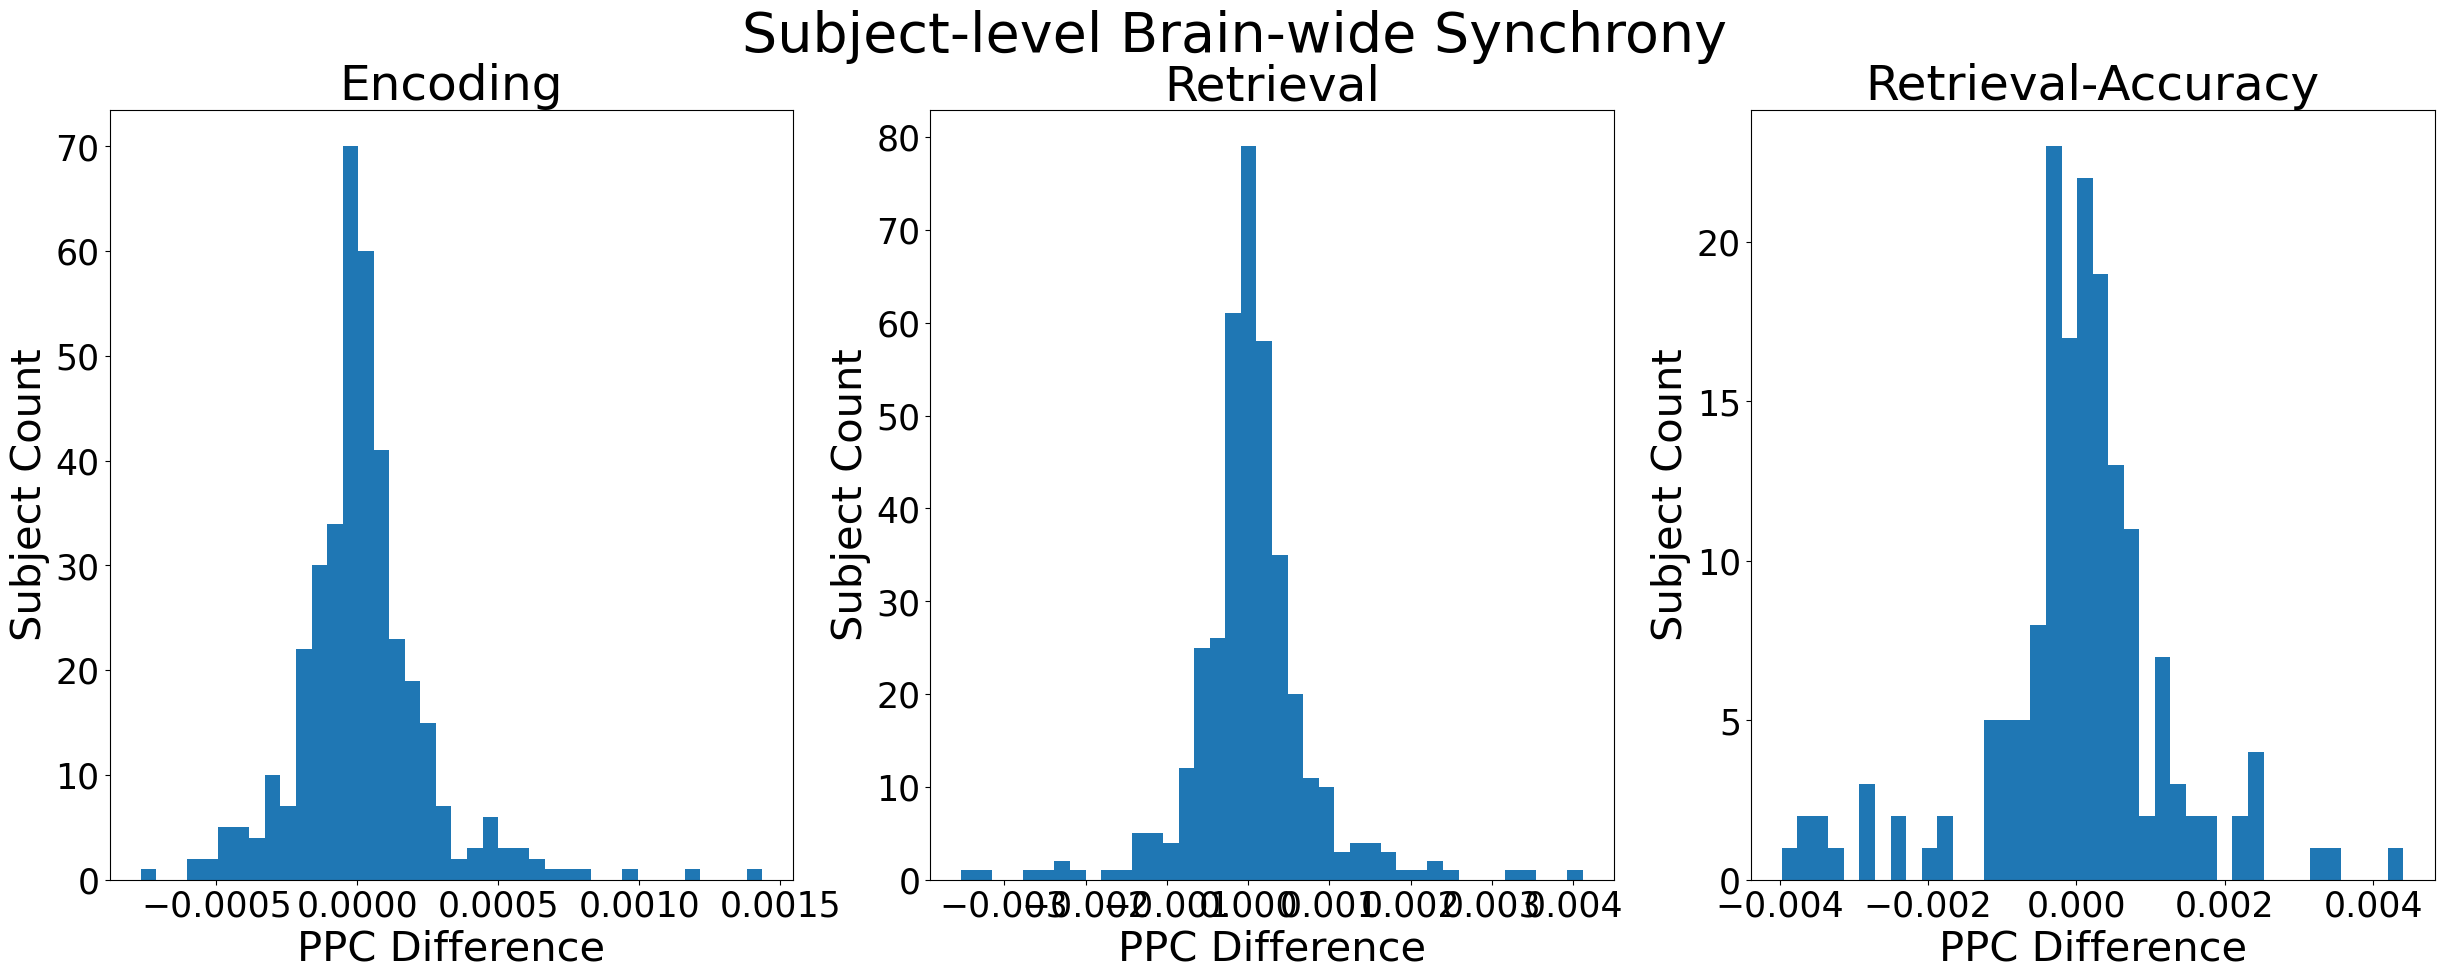

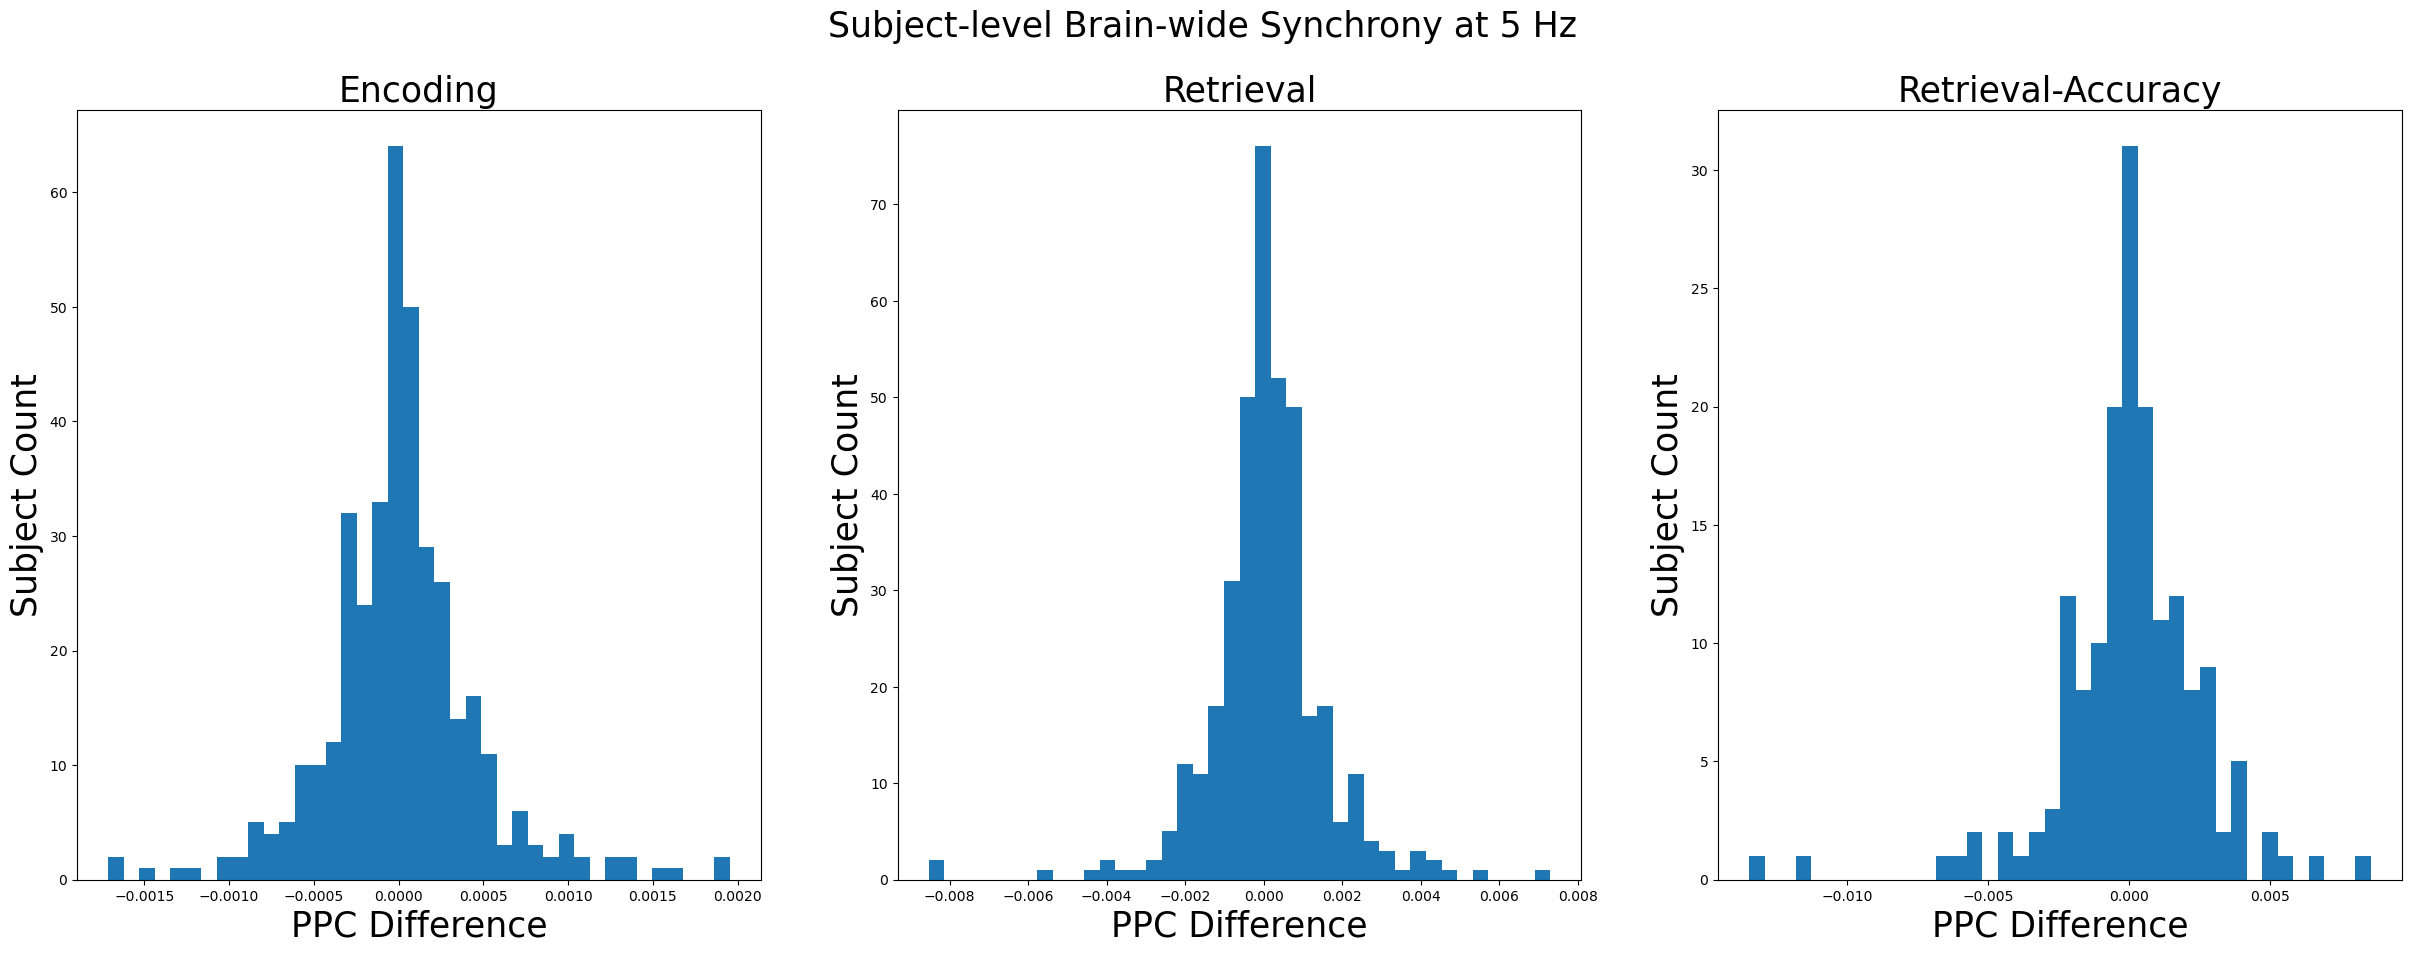

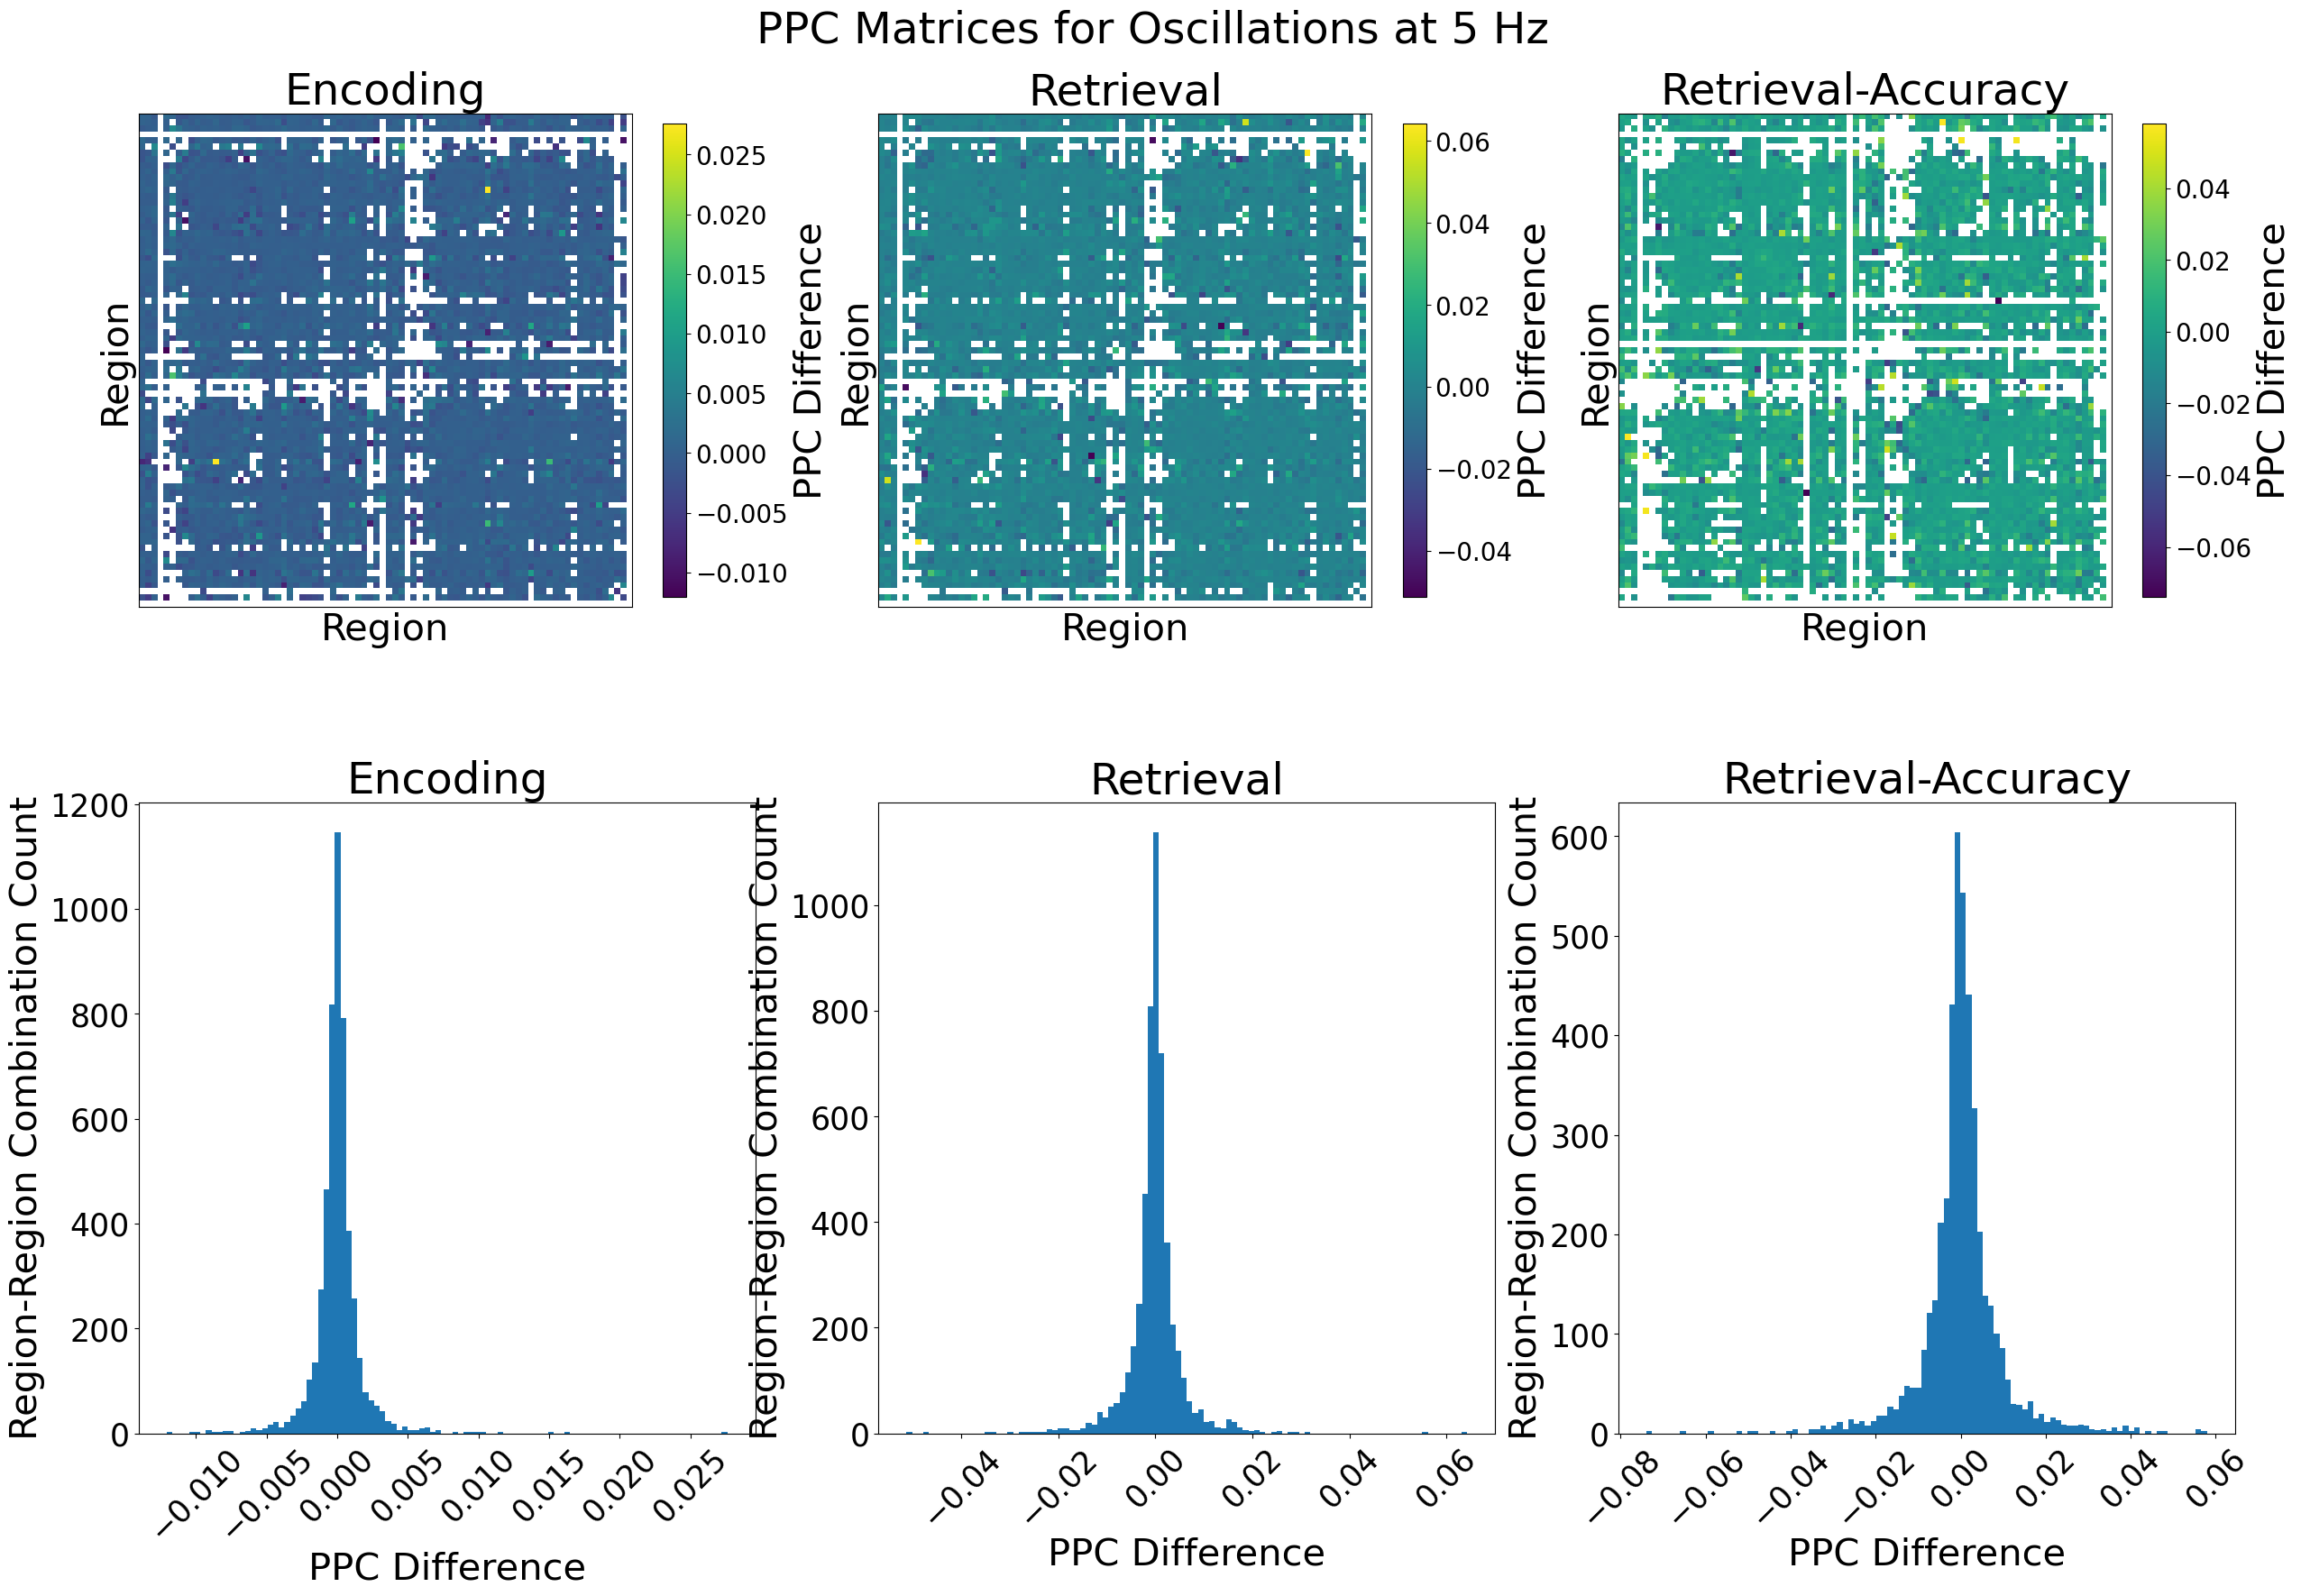

In [14]:
from helper import generate_subject_synchrony_results

generate_subject_synchrony_results(root_dir, simulation_tag=simulation_tag, figure_path=figure_path)

Average theoretical PPC difference across regions: 0.0


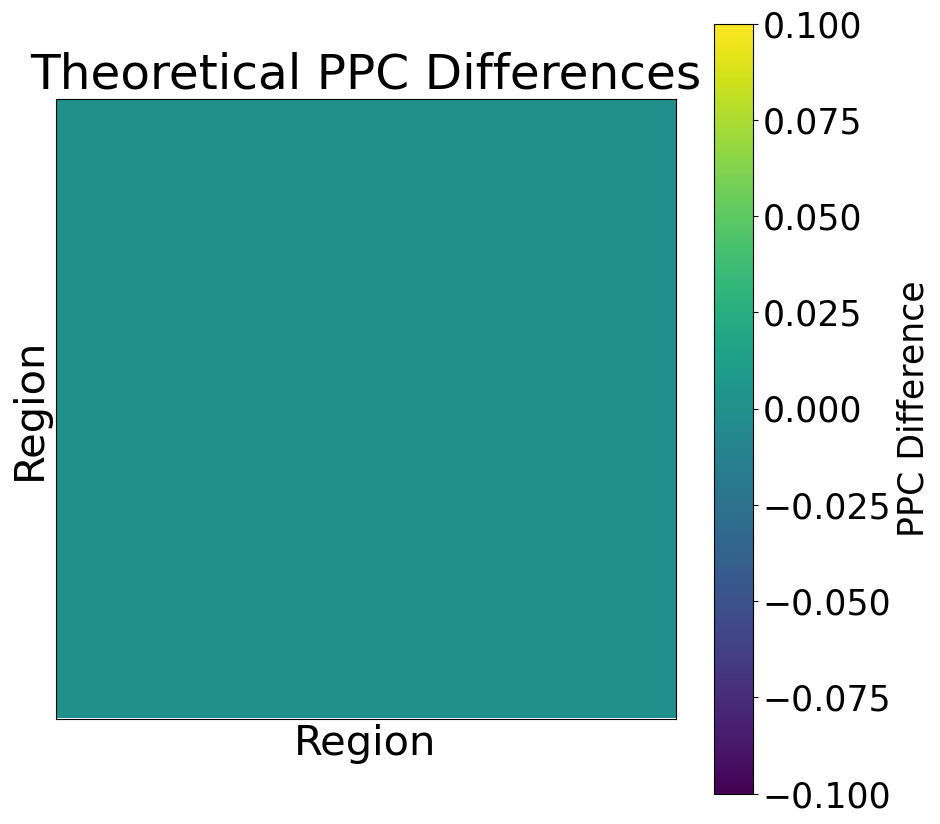

In [19]:
from helper import generate_simulation_theoretical_effect_plots

if is_simulation:
    theory_ppc_matrix = generate_simulation_theoretical_effect_plots(root_dir, simulation_tag, figure_path=figure_path)
    plt.show()


In [20]:
# get theoretical whole-brain synchrony effect accounting for missing regions in subjects
if is_simulation:
    sanity_check_whole_brain_synchrony(theory_ppc_matrix=theory_ppc_matrix,
                                       root_dir=root_dir,
                                       simulation_tag=simulation_tag)


---------------- Encoding ----------------
Theoretical global synchrony effect: 0.0
Theoretical global synchrony effect with non-redundant region-region combinations: 0.0
Proportion of total region-region pairs missing at subject level: 0.94922

---------------- Retrieval ----------------
Theoretical global synchrony effect: 0.0
Theoretical global synchrony effect with non-redundant region-region combinations: 0.0
Proportion of total region-region pairs missing at subject level: 0.94922

---------------- Retrieval-Accuracy ----------------
Theoretical global synchrony effect: 0.0
Theoretical global synchrony effect with non-redundant region-region combinations: 0.0
Proportion of total region-region pairs missing at subject level: 0.95247



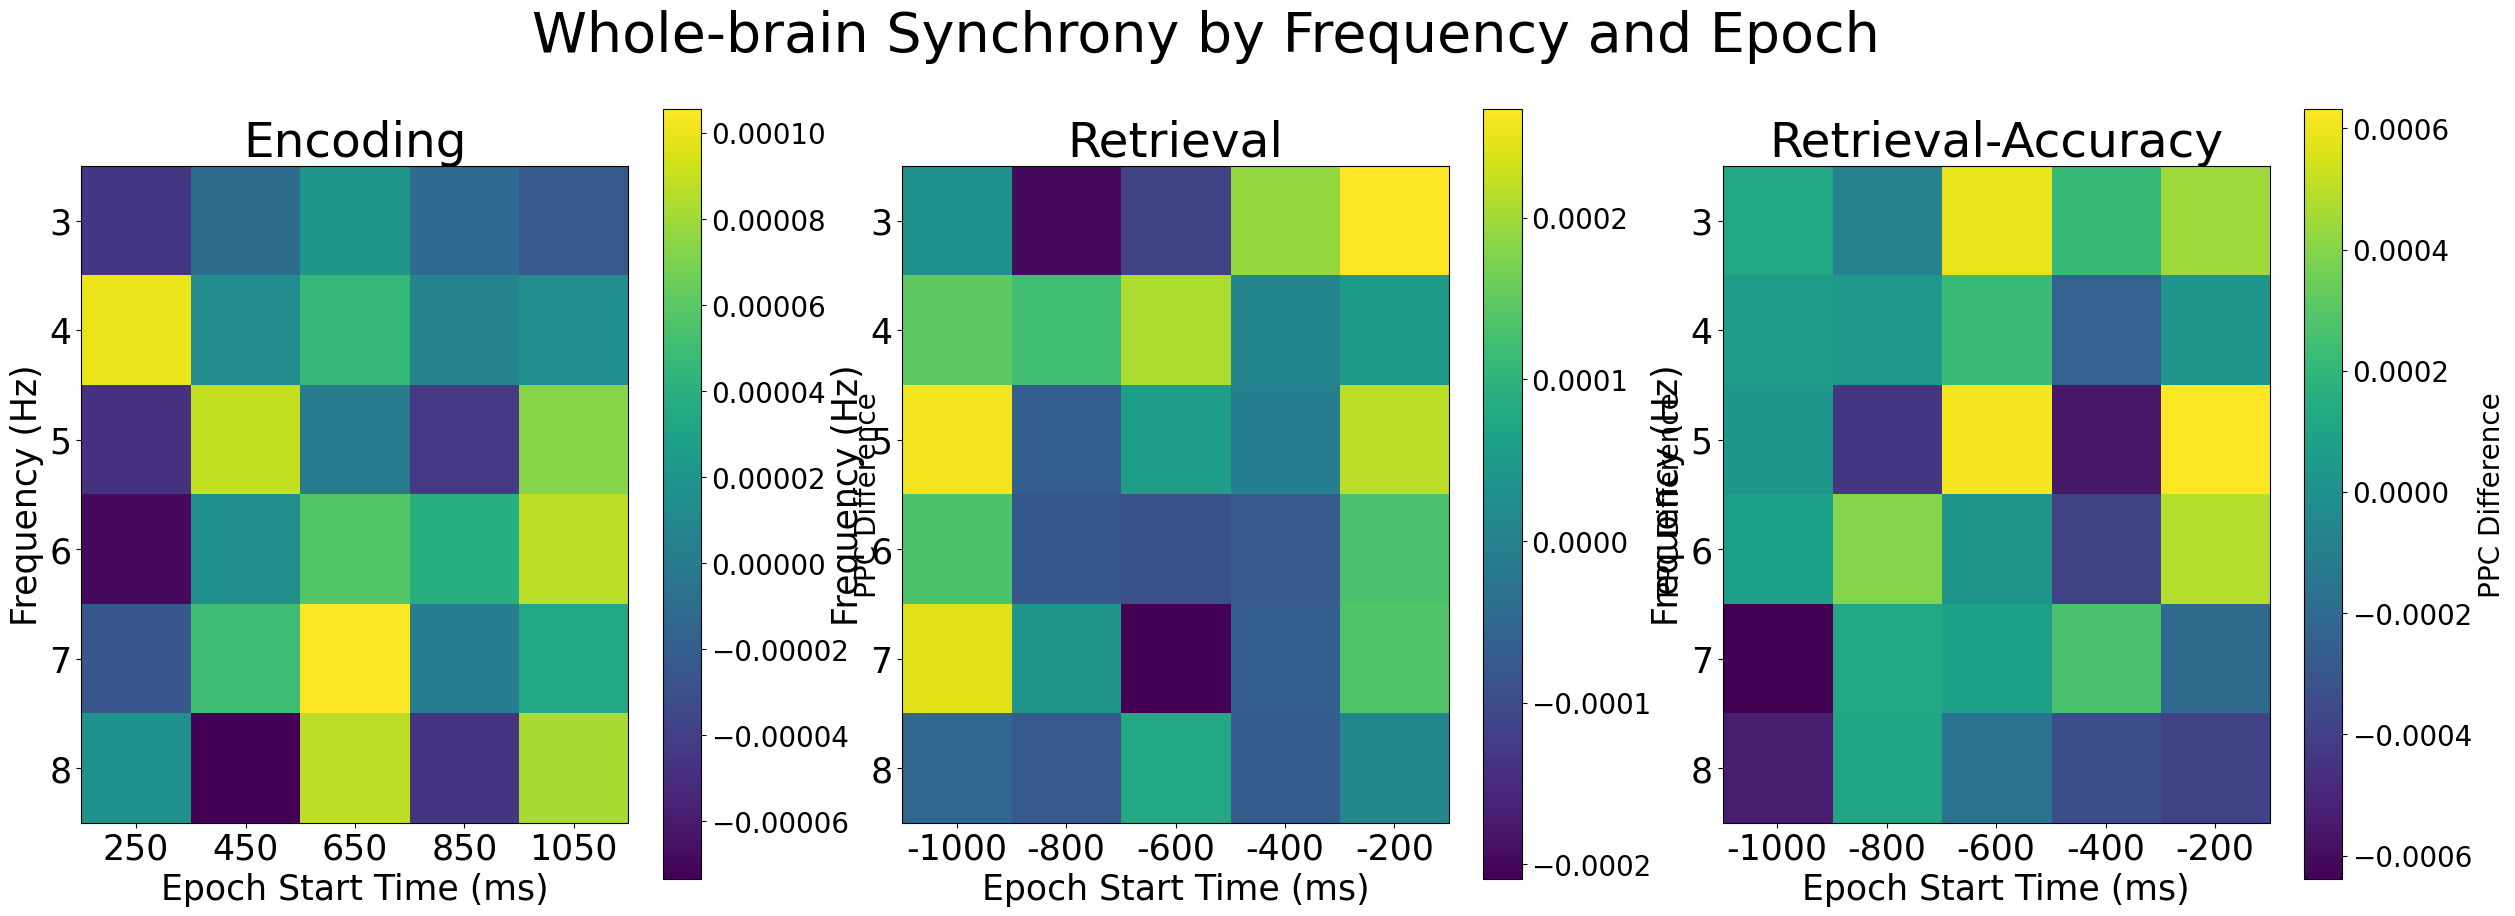

In [22]:
# show whole-brain synchrony effects over frequencies and epochs
from helper import plot_synchrony_frequency_epochs
plot_synchrony_frequency_epochs(root_dir, simulation_tag=simulation_tag, figure_path=figure_path)


In [25]:
# sanity check expected effect, accounting for proportions of 
# missing region-region combinations averaged across subjects

if is_simulation and (simulation_tag not in NULL_SIMULATION_TAGS):
    from helper import sanity_check_simulated_synchrony
    sanity_check_simulated_synchrony(parameters=parameters)


## Figure 2

In [26]:
fig2_df = pd.DataFrame([], columns=['beh', 'data'])
for beh in ['en', 'rm', 'ri']:
    fname = join(root_dir, f'{beh}_pop_symx.pkl')
    mx = load_pickle(fname)
    mx = mx.mean('freq').mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=True) - mx.sel(success=False)
    # sub_mean = mx.mean('sub')
    # print(f'{beh}: mean effect across subjects:')
    # display(sub_mean.item())
    fig2_df = pd.concat([fig2_df, pd.DataFrame({'beh': beh,
                                                'data': mx.data})],
                         axis=0,
                         ignore_index=True)

Text(0, 0.5, 'ΔPPC')

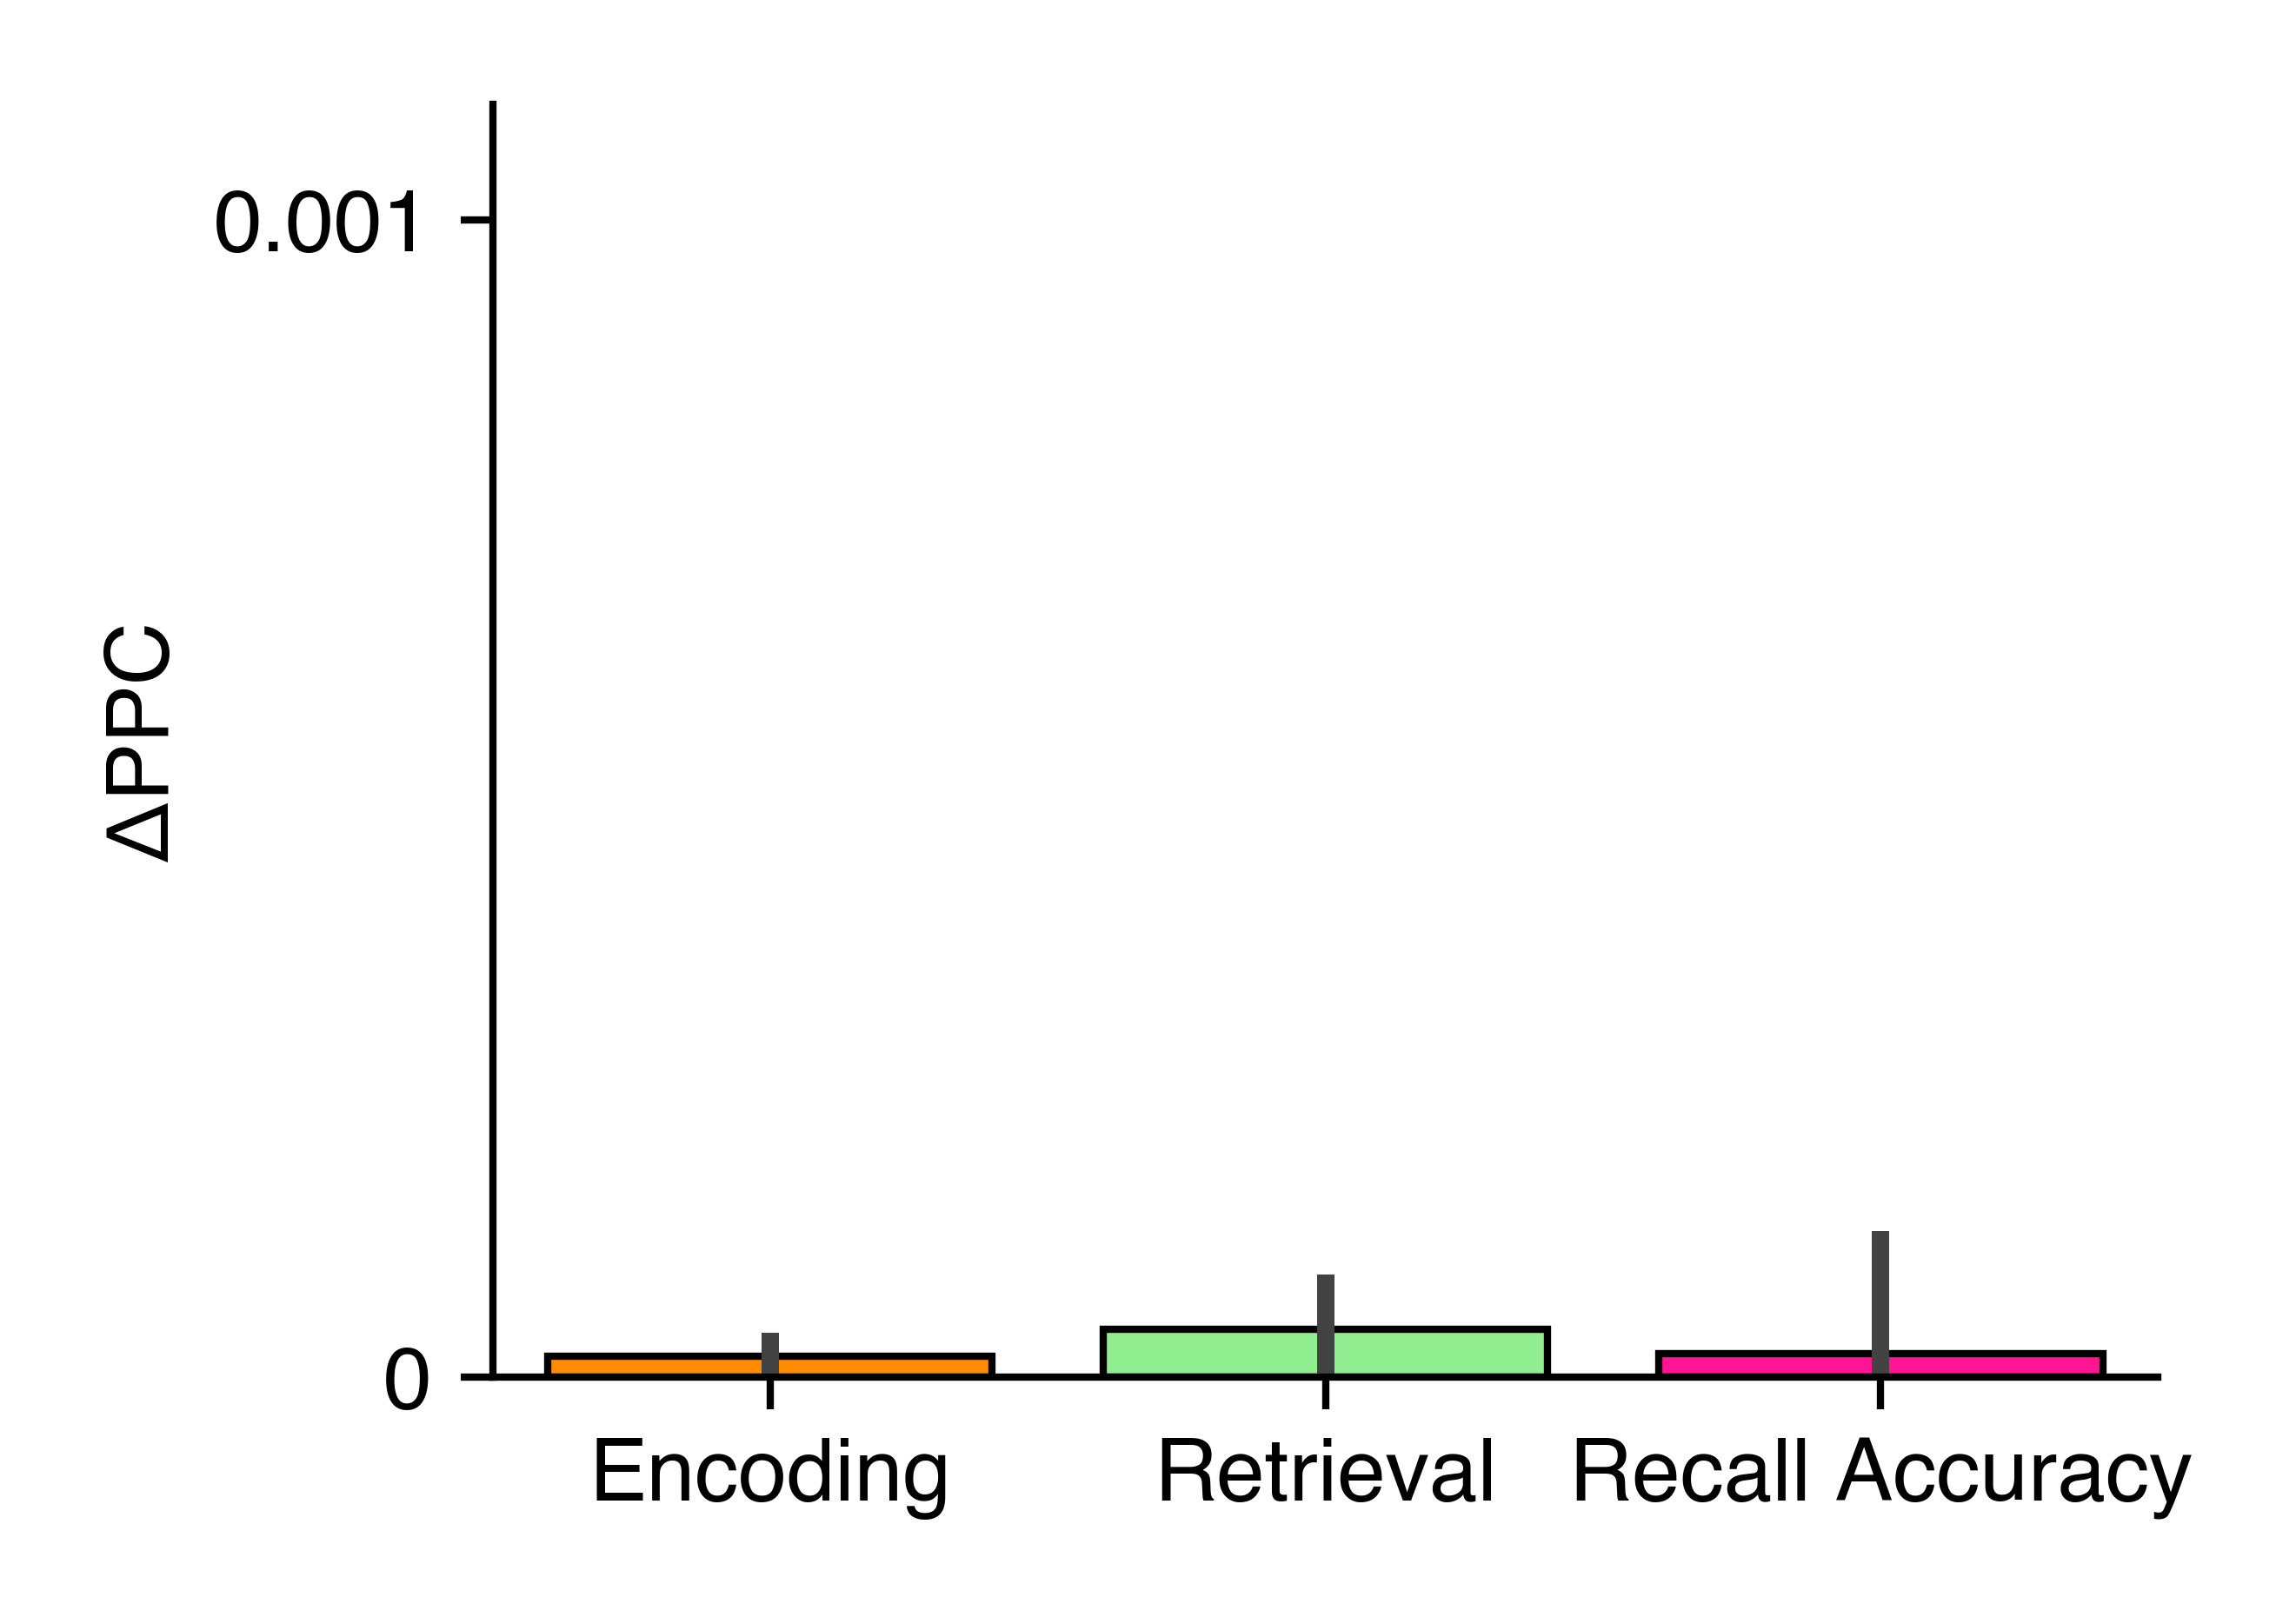

In [27]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
mpl.rc('text', usetex=False)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.65, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = 0
ymax = 0.0011
yticks = [0, .001]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='beh', data=fig2_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', linewidth=spine_lw, ec='k',
                  palette=['darkorange', 'lightgreen', 'deeppink'])

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick']+2)
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()

Text(0, 0.5, 'ΔPPC')

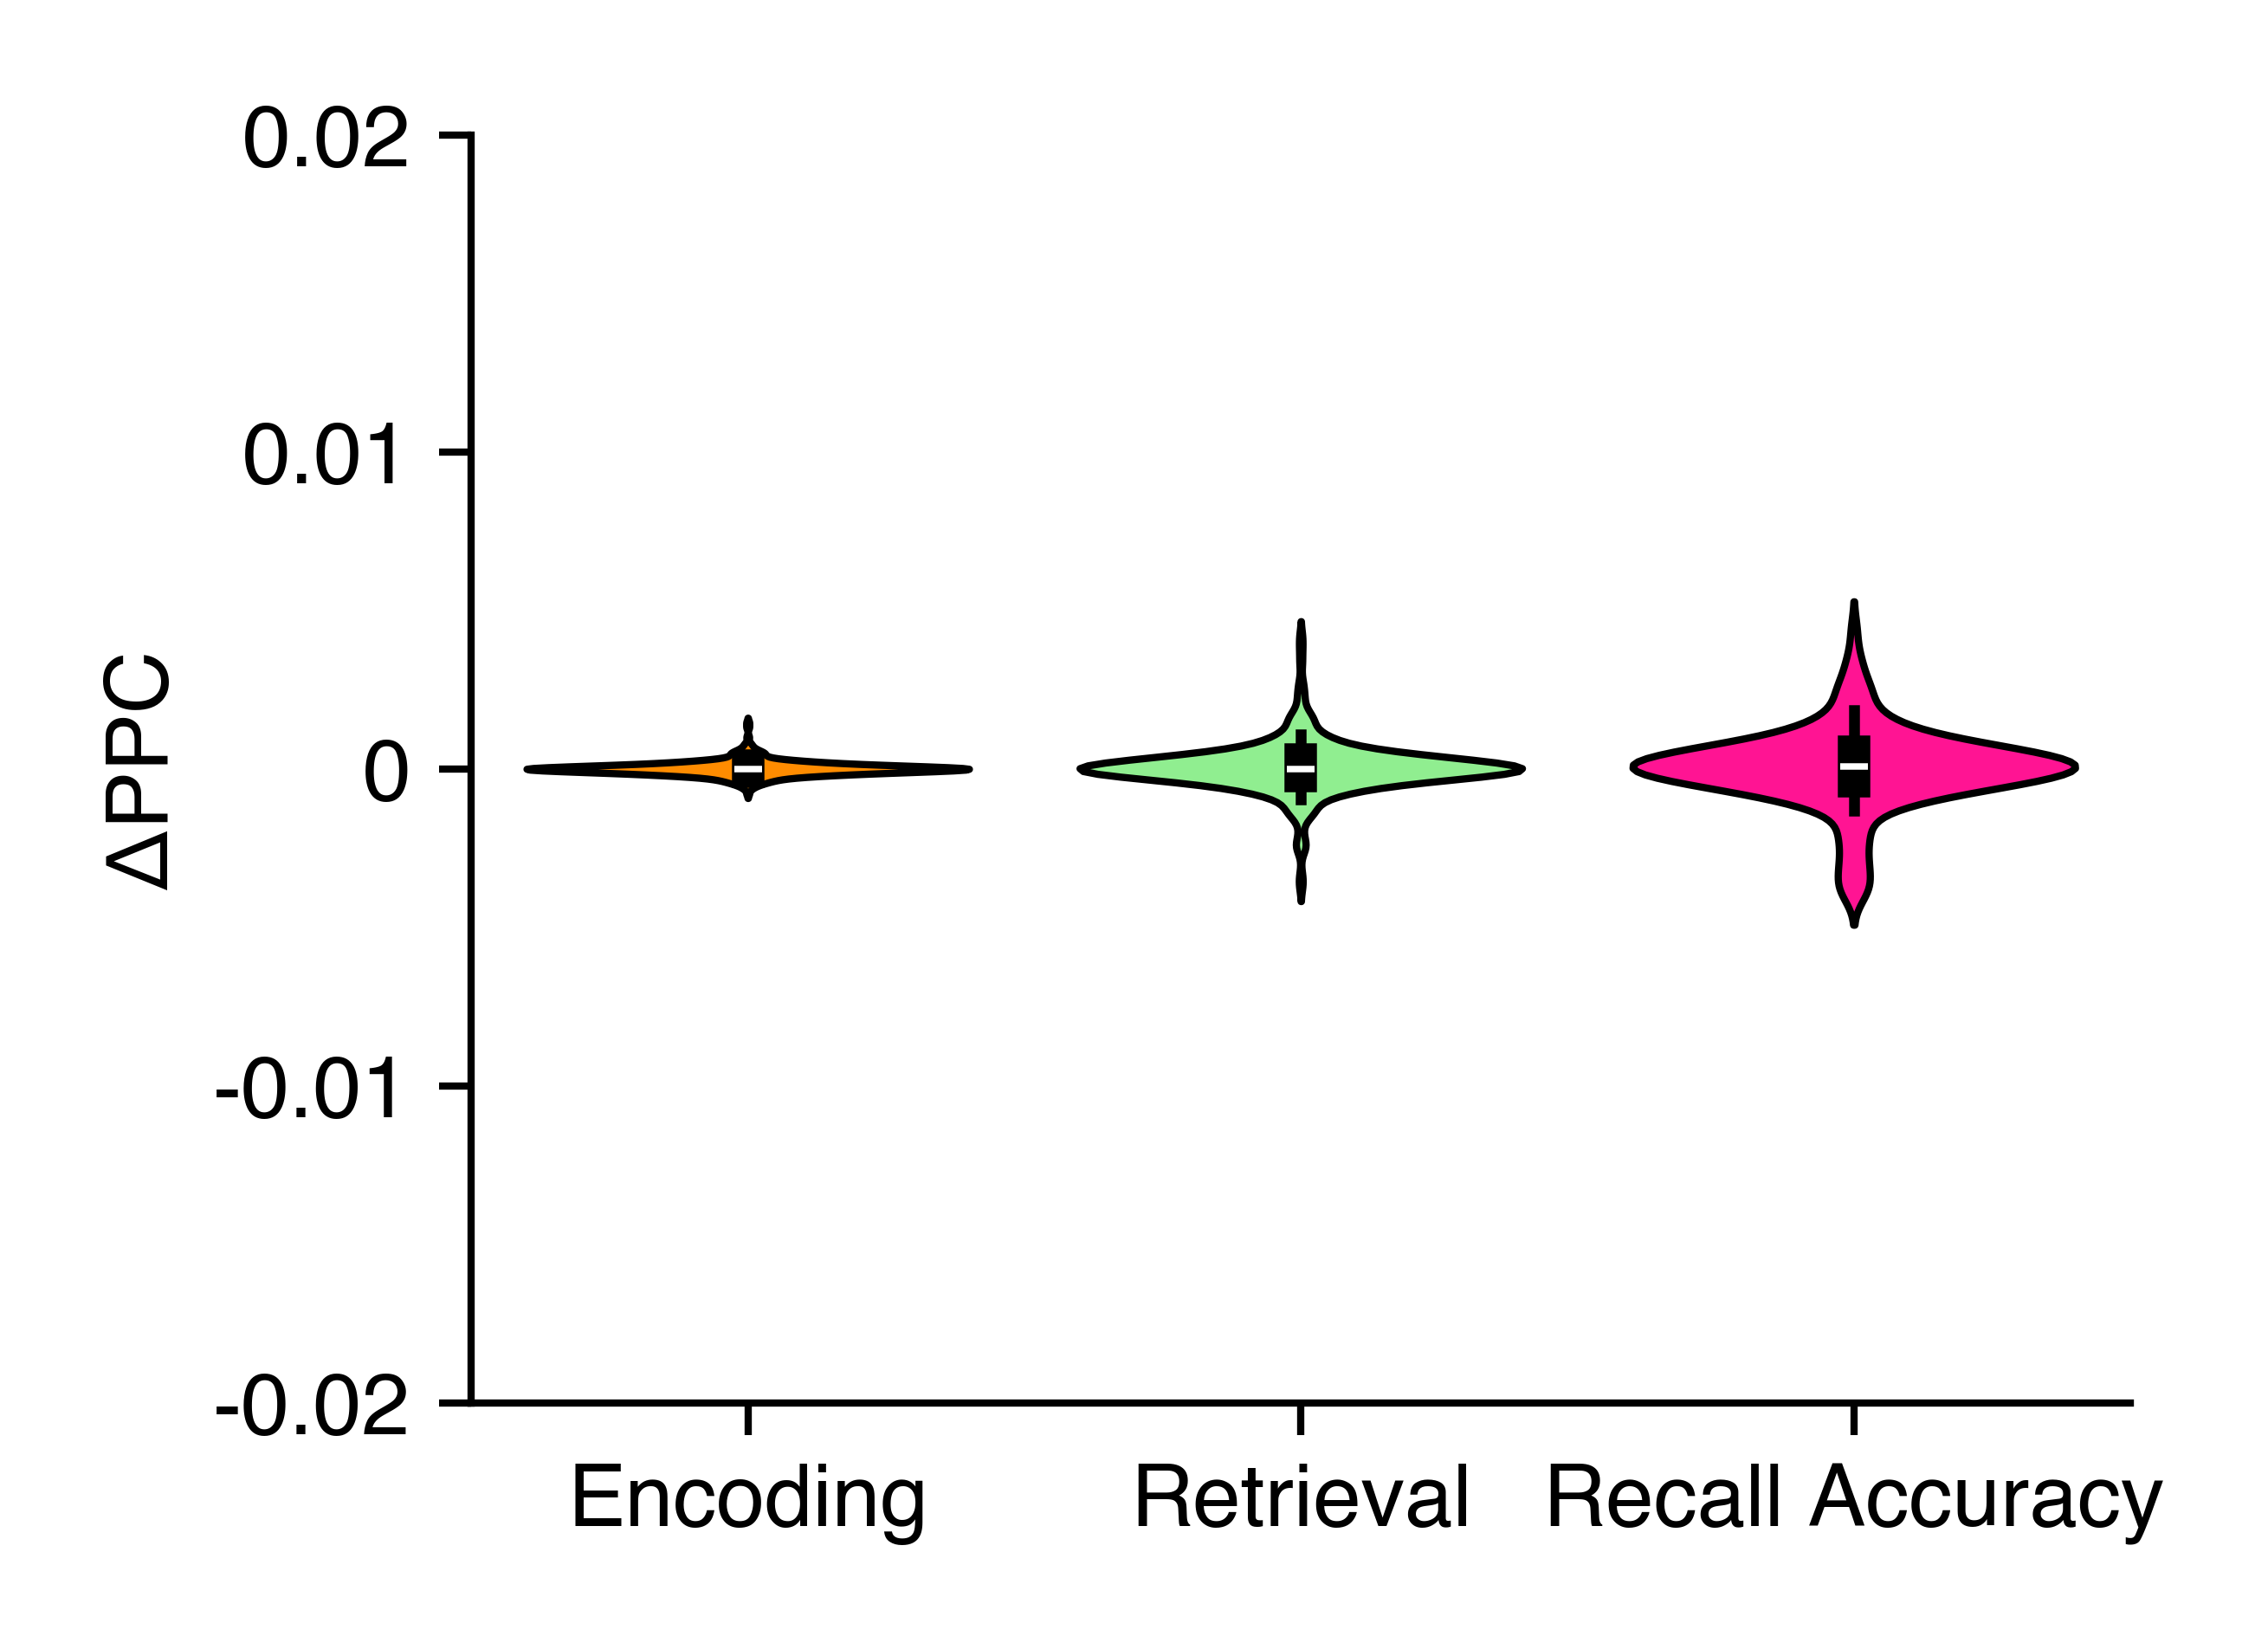

In [28]:
figsize = (colws[2]*0.65, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
ymin = -0.02
ymax = 0.02
yticks = [-0.02, -0.01, 0, 0.01, 0.02]
spine_lw = 0.5
ticklen = 2.2
tickpad = 0
labelpad = 3
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax.axhline(5, linewidth=spine_lw, color=hline_color, ls='--')
_ax = sns.violinplot(x='beh', y='data', hue='beh', data=fig2_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  linewidth=spine_lw, 
                  edgecolor='k',
                 palette=['darkorange', 'lightgreen', 'deeppink'])

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick']+2)
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)

# Subject-level effects

## Trial count

In [29]:
helper.root_dir = root_dir

In [30]:
def get_sub_trial_count(sub, beh, sess_list_df):
    helper.root_dir = root_dir
    
    sub_dfrows = sess_list_df.loc[[sub], ['sub', 'exp', 'sess', 'loc', 'mon']].reset_index(drop=True)
    
    def get_trial_count(dfrow, beh):
        events = load_events(dfrow, beh)
        return len(events)//2 if events is not None else np.nan
    
    sub_dfrows['event_count'] = sub_dfrows.apply(lambda dfrow: get_trial_count(dfrow, beh), axis=1)
    
    return sub_dfrows['event_count'].mean()

In [32]:
def get_event_count_effect_size(beh):
    helper.root_dir = root_dir
    
    if beh in ['en', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index('sub',drop=False)
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)').set_index('sub',drop=False)
        
    sub_list_df = pd.DataFrame(sess_list_df['sub'].unique(), columns=['sub']).set_index('sub', drop=False)
    sub_list_df[f'{beh}_event_count'] = sub_list_df.apply(lambda r: get_sub_trial_count(r.name, beh, sess_list_df), axis=1)
    mx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean('epoch').mean('freq').mean('reg2').mean('reg1')
    mx = mx.sel(success=True) - mx.sel(success=False)
    sub_list_df[f'{beh}_effect_size'] = sub_list_df.apply(lambda r: float(mx.sel(sub = r.name).values), axis=1)
    
    return sub_list_df

In [33]:
def compute_event_count_effect_size_correlation(sub_list_df):
    helper.root_dir = root_dir
    
    np.random.seed(202409)
    
    event_counts = sub_list_df[f'{beh}_event_count'].values
    effect_sizes = sub_list_df[f'{beh}_effect_size'].values
    r_true = scipy.stats.pearsonr(event_counts, effect_sizes)[0]
    
    shuffle_count = 999
    rs_shuffled = []
    for _ in range(shuffle_count):
        
        event_counts_shuffled = deepcopy(event_counts)
        effect_sizes_shuffled = deepcopy(effect_sizes)
        np.random.shuffle(event_counts_shuffled)
        np.random.shuffle(effect_sizes_shuffled)
        
        r_shuffled = scipy.stats.pearsonr(event_counts_shuffled, effect_sizes_shuffled)[0]
        rs_shuffled.append(r_shuffled)
        
    rs = [r_true] + rs_shuffled
    p = np.sum(np.abs(rs) >= np.abs(r_true))/len(rs)
    print_header(beh)
    print(f'Pearson\'s r: {r_true}, p = {p}')

In [34]:
for beh in ['en', 'rm', 'ri']:
    
    sub_list_df = get_event_count_effect_size(beh)
    compute_event_count_effect_size_correlation(sub_list_df)

---------en---------
Pearson's r: -0.020462845096057614, p = 0.698
---------rm---------
Pearson's r: -0.023802465855390552, p = 0.661
---------ri---------
Pearson's r: -0.017176580859525715, p = 0.822


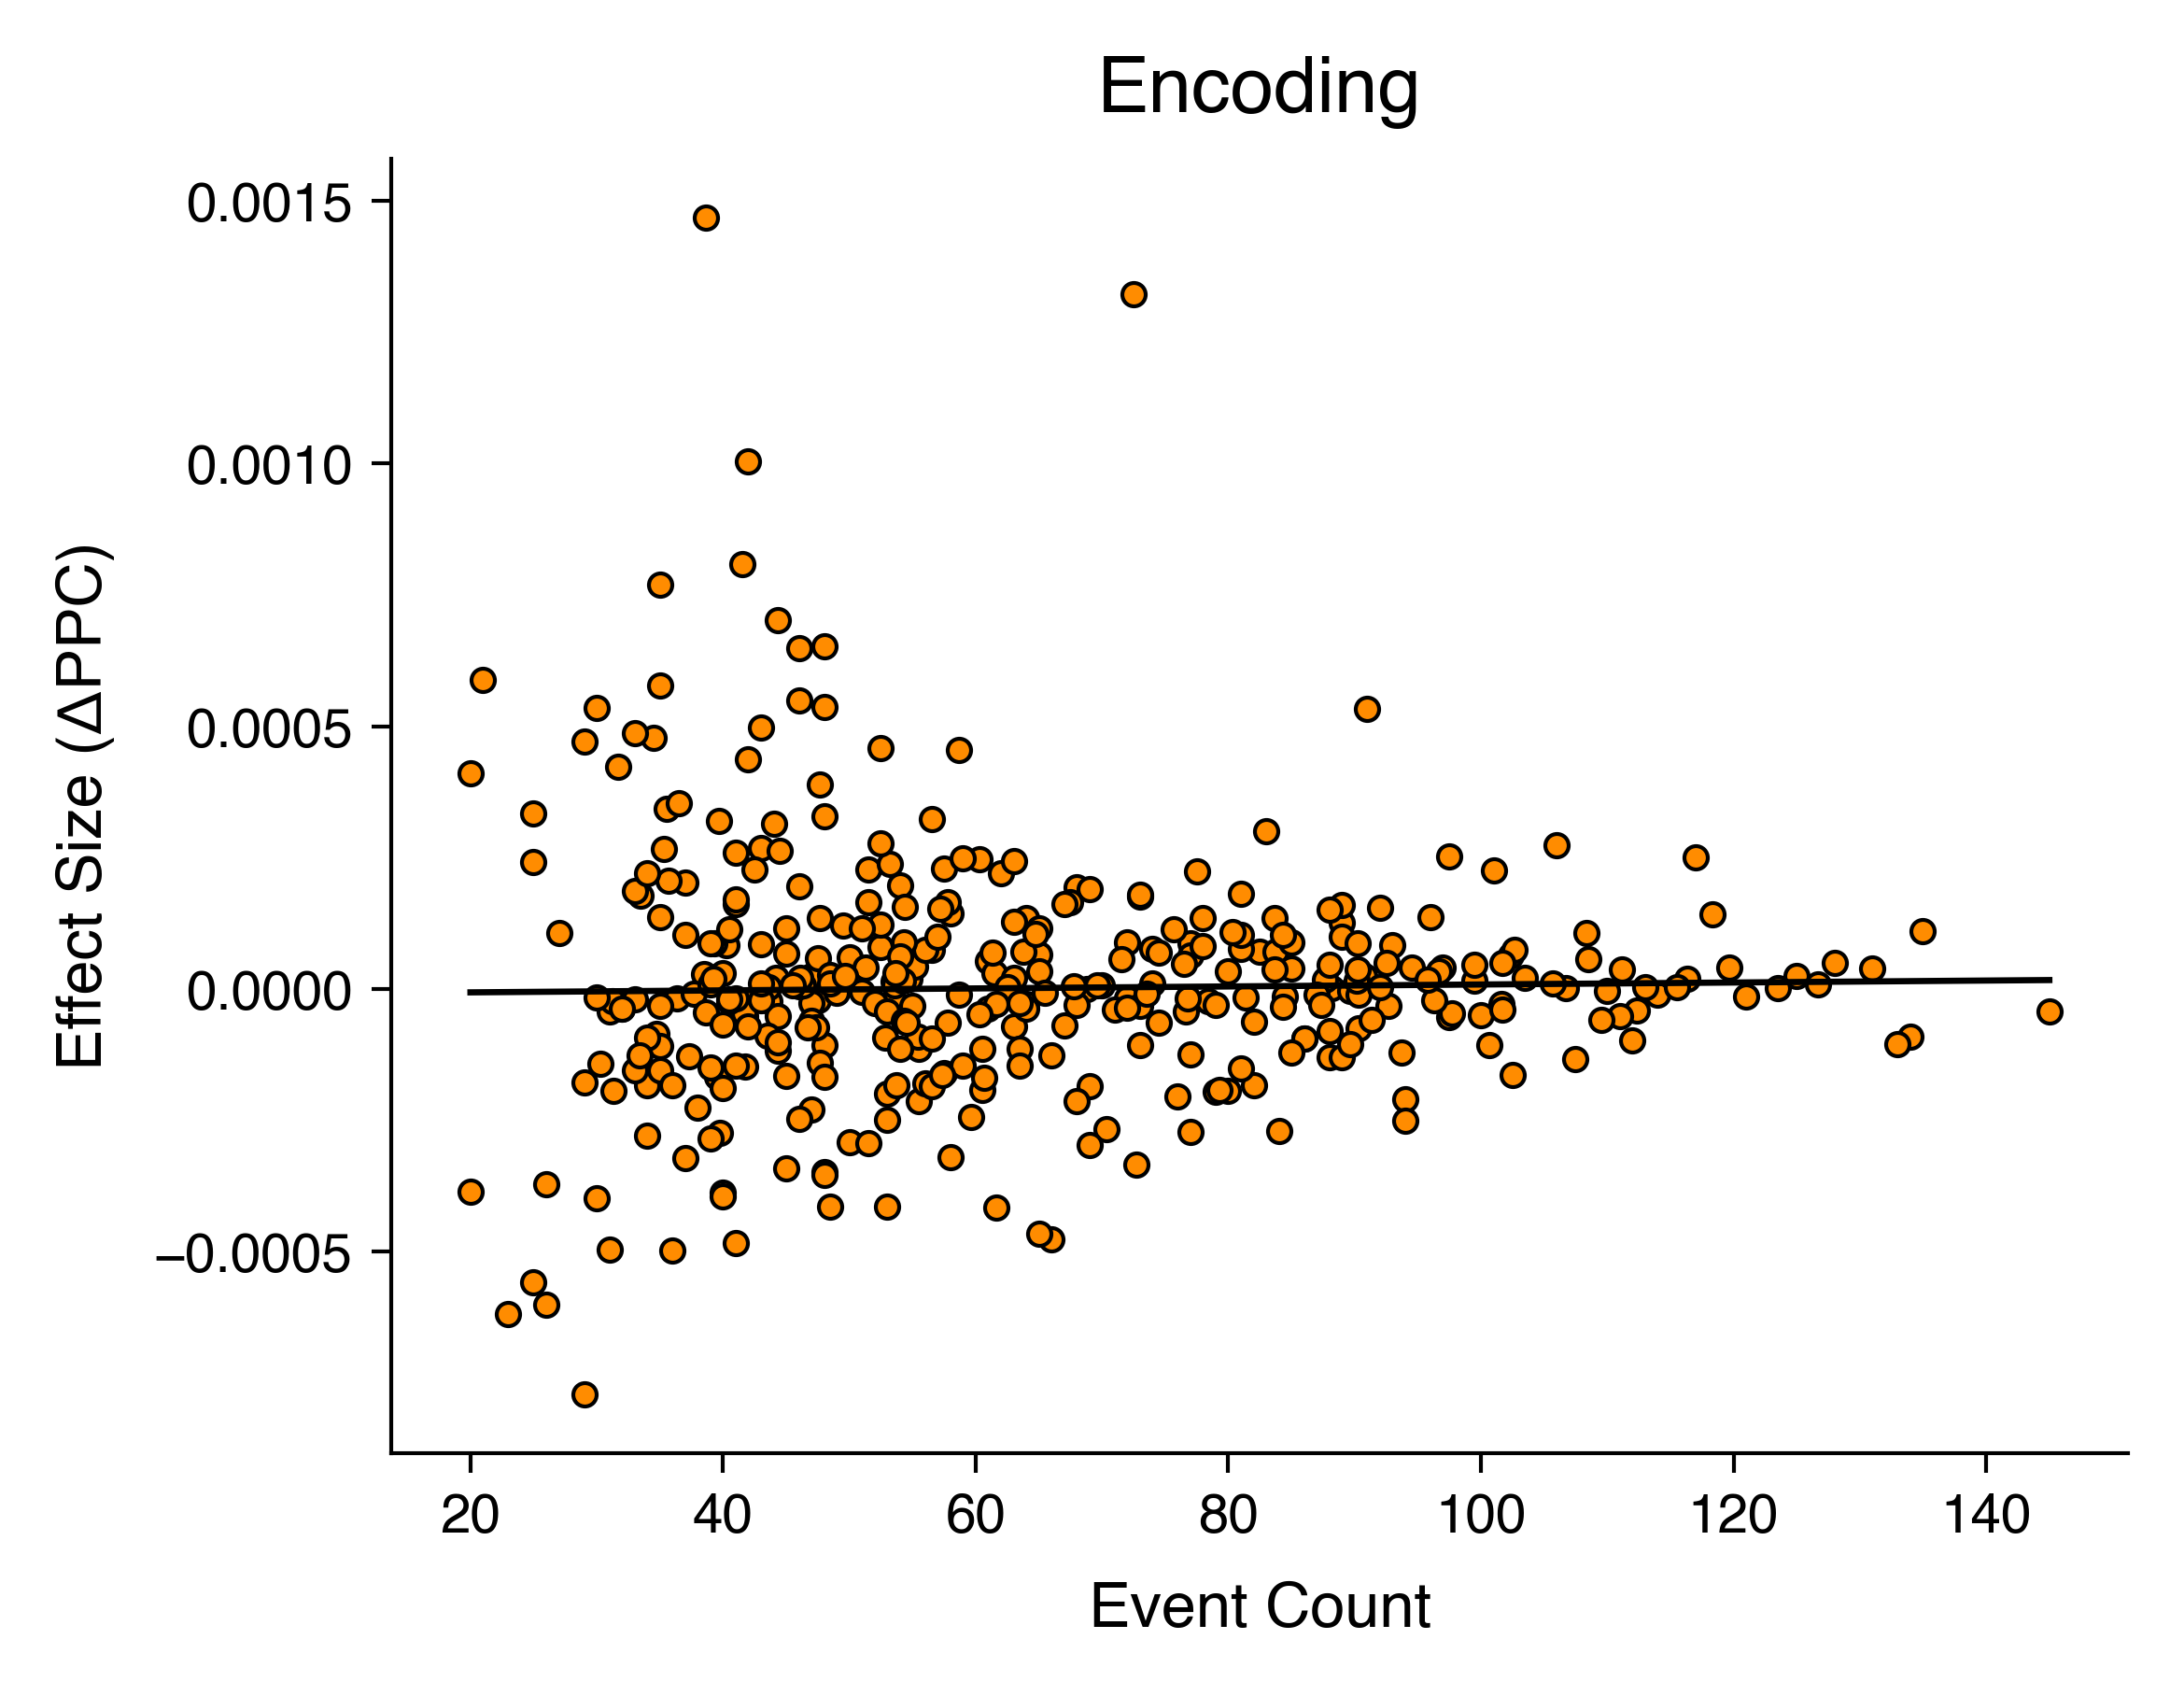

In [35]:
beh = 'en'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='darkorange', edgecolor='black')
ax.set_title('Encoding')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

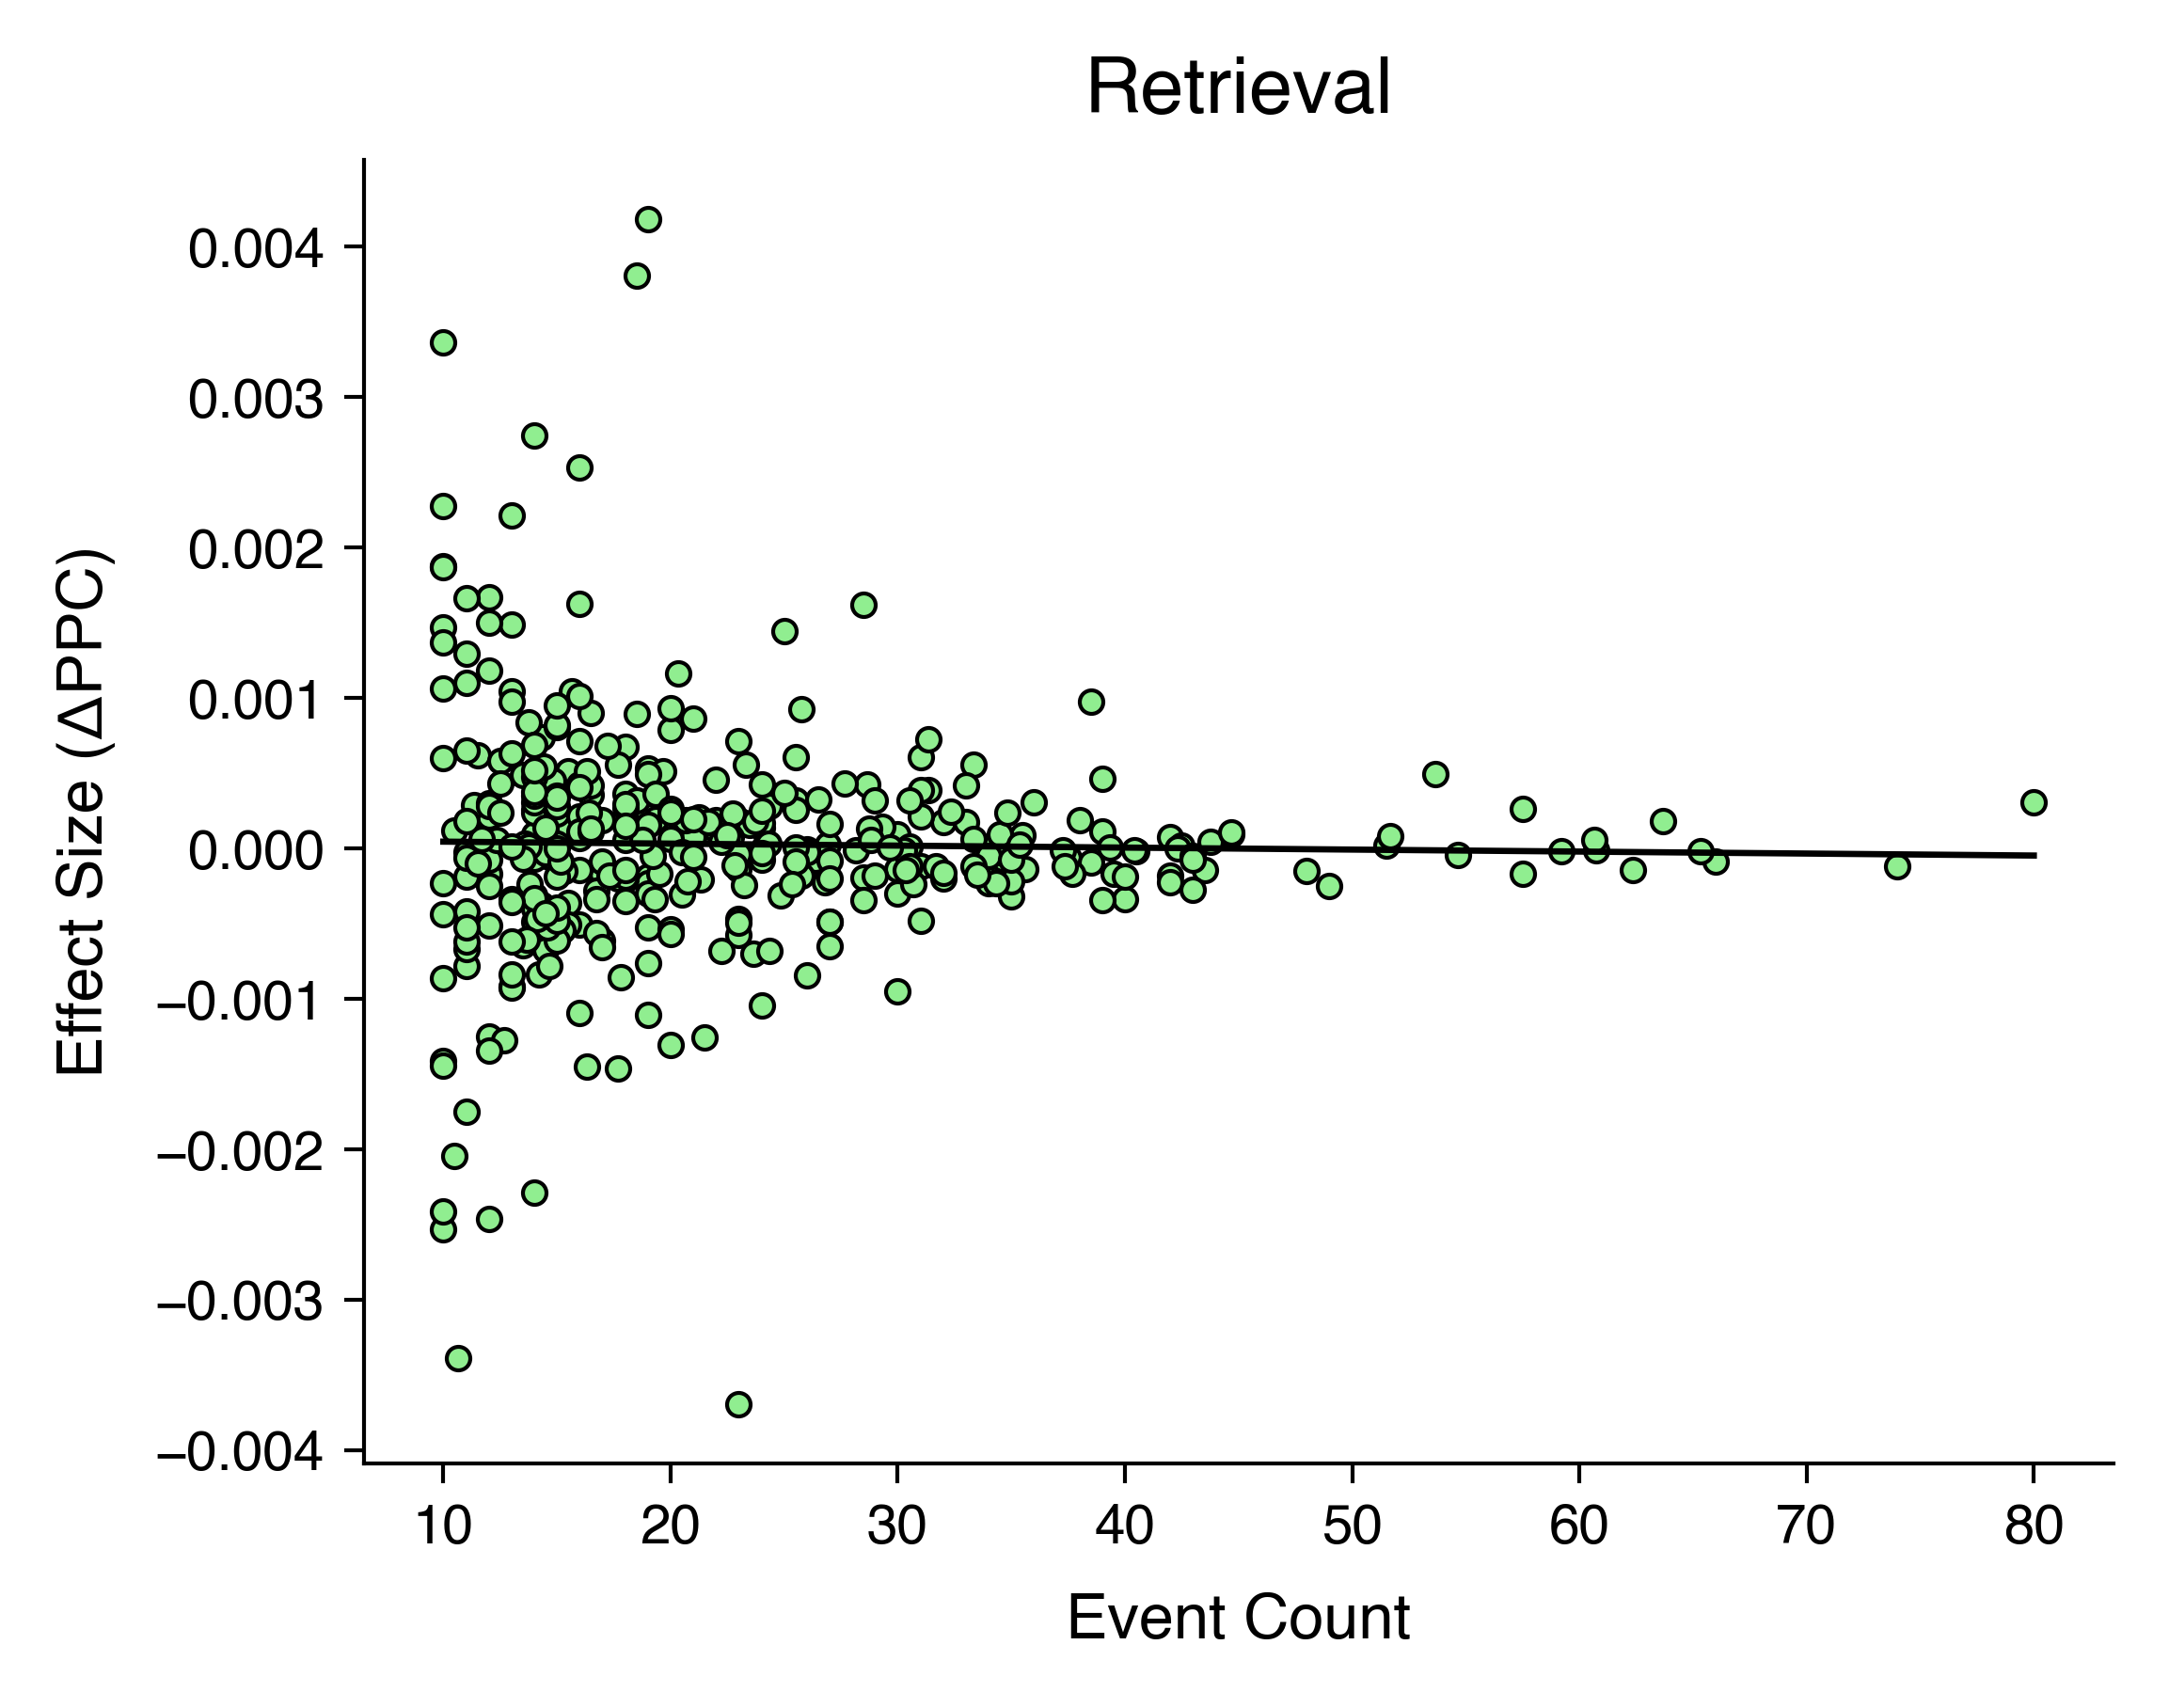

In [36]:
beh = 'rm'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='lightgreen', edgecolor='black')
ax.set_title('Retrieval')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

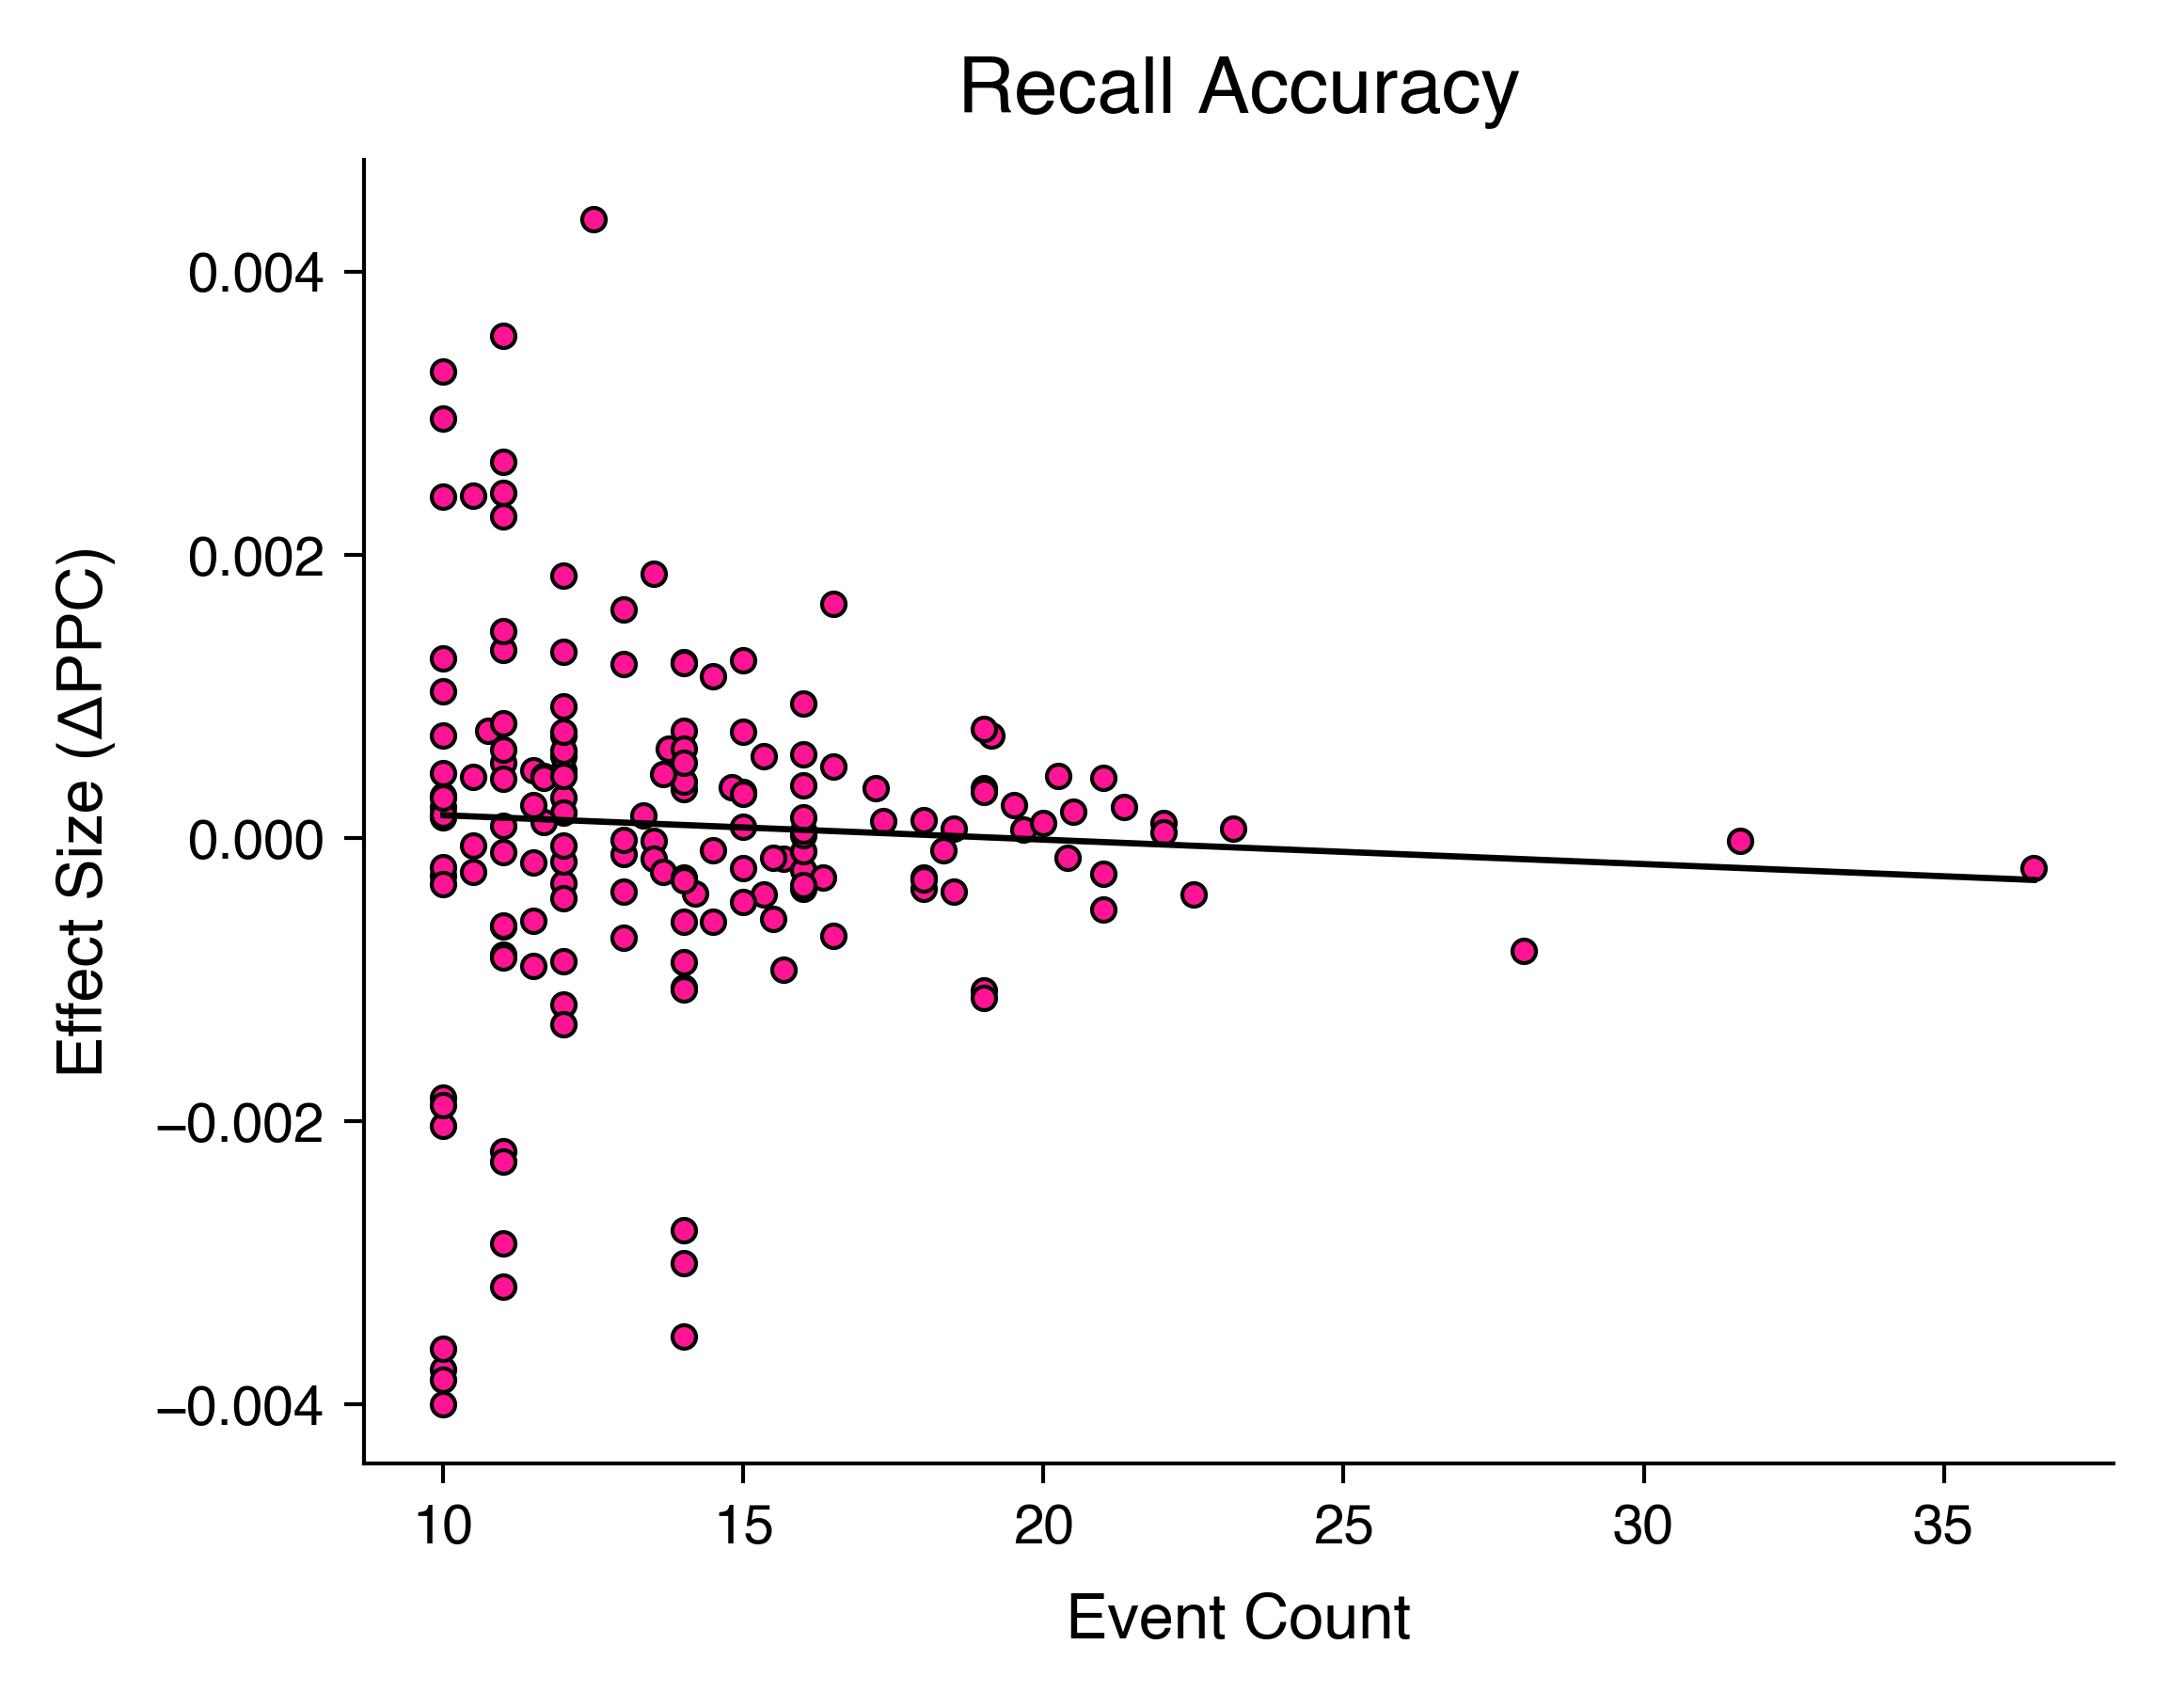

In [37]:
beh = 'ri'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='deeppink', edgecolor='black')
ax.set_title('Recall Accuracy')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

## Noise floors

In [38]:
# shuffle_count = 20

In [39]:
# path = join(root_dir, 'noise_floor_analysis')
# if not ex(path): os.mkdir(path)
# for beh in ['en', 'rm', 'ri']:
#     path = join(root_dir, 'noise_floor_analysis', beh)
#     if not ex(path): os.mkdir(path)
#     path = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates')
#     if not ex(path): os.mkdir(path)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         if not ex(path): os.mkdir(path)
#         for d in ['shuffled_masks', 'elsymxs', 'regsymxs']:
#             path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', d)
#             if not ex(path): os.mkdir(path)
# # directory structure: {root_dir}/noise_floor_analysis/en/shuffle_1/shuffled_masks
# # {root_dir}/noise_floor_analysis/en/shuffle_1/elsymxs
# # {root_dir}/noise_floor_analysis/en/shuffle_1/regsymxs

In [40]:
# import shutil
# path = join(root_dir, 'noise_floor_analysis')
# if ex(path): shutil.rmtree(path)
# for beh in ['en', 'rm']:
#     path = join(root_dir, 'noise_floor_analysis', beh)
#     if ex(path): shutil.rmtree(path)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         if ex(path): shutil.rmtree(path)
#         for d in ['shuffled_masks', 'elsymxs', 'regsymxs']:
#             path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', d)
#             if ex(path): shutil.rmtree(path)

In [41]:
# def run_pipeline_en_rm_shuffled(dfrow):
#     import helper
#     helper.root_dir = root_dir
    
#     dfrow = get_dfrow(dfrow)
#     for beh in ['en', 'rm']:
#         np.random.seed(202410)
#         for iShuffle in np.arange(1, shuffle_count+1):
#             events = load_events(dfrow, beh)
#             save_dir = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#             shuffled_mask_fname = join(save_dir, 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
#             if ex(shuffled_mask_fname):
#                 events.attrs['mask'] = npl(shuffled_mask_fname)
#             else:
#                 np.random.shuffle(events.attrs['mask'])
#                 np.save(shuffled_mask_fname, events.attrs['mask'])
#             run_pipeline(dfrow, beh, events, save_dir)

In [42]:
# sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
# sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [43]:
# client = cl('run_pipeline_en_rm_shuffled', '10G', int(4000/10), walltime=200000) 
# futures = client.map(run_pipeline_en_rm_shuffled, sess_list)
# wait(futures, client, check_delay=60)

In [44]:
# client.shutdown()

In [45]:
# get_ex(futures, sess_list)

In [46]:
# np.all([future.status == 'finished' for future in futures])

In [47]:
# len(ld(root_dir + '/noise_floor_analysis/rm/shuffle_20/regsymxs'))

In [48]:
# def run_pipeline_ri_shuffled(dfrow):
#     import helper
#     helper.root_dir = root_dir
    
#     dfrow = get_dfrow(dfrow)
#     beh = 'ri'
#     np.random.seed(202410)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         events = load_events(dfrow, beh)
#         save_dir = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         shuffled_mask_fname = join(save_dir, 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
#         if ex(shuffled_mask_fname):
#             events.attrs['mask'] = npl(shuffled_mask_fname)
#         else:
#             np.random.shuffle(events.attrs['mask'])
#             np.save(shuffled_mask_fname, events.attrs['mask'])
#         run_pipeline(dfrow, beh, events, save_dir)

In [49]:
# sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
# sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [50]:
# client2 = cl('run_pipeline_ri_shuffled', '10G', int(1500/10), walltime=200000) 
# futures2 = client2.map(run_pipeline_ri_shuffled, sess_list_ri)
# wait(futures2, client2, check_delay=60)

In [51]:
# client.shutdown()
# client2.shutdown()

In [52]:
# not_done_fnames = []
# for beh in ['en', 'rm', 'ri']:
#     for iShuffle in range(1, 21):
#         for i, dfrow in sess_list_df.iterrows():
#             fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.pkl')
#             if ex(fname):
#                 try:
#                     load_pickle(fname)
#                 except:
#                     not_done_fnames.append(fname)

In [53]:
# print(len(not_done_fnames))

In [54]:
# for fname in not_done_fnames:
#     os.system(f'rm {fname}')

In [55]:
# def estimate_noise_floor_en_rm(dfrow):
#     import helper
#     helper.root_dir = root_dir
    
#     dfrow = get_dfrow(dfrow)
    
#     for beh in ['en', 'rm']:
#         noise_floor_estimates = []
#         for iShuffle in np.arange(1, shuffle_count+1):
#             fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.pkl')
#             mx = load_pickle(fname).mean('epoch').mean('freq').mean('reg2').mean('reg1')
#             mx = mx.sel(success=True) - mx.sel(success=False)
#             noise_floor_estimate = float(mx.values)
#             noise_floor_estimates += [noise_floor_estimate]
        
#         save_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
#         np.save(save_fname, noise_floor_estimates)

In [56]:
# sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
# sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [57]:
# client = cl('estimate_noise_floor_en_rm', '10G', int(3000/10), walltime=200000) 
# futures = client.map(estimate_noise_floor_en_rm, sess_list)
# wait(futures, client, check_delay=60)

In [58]:
# def estimate_noise_floor_ri(dfrow):
#     import helper
#     helper.root_dir = root_dir
    
#     dfrow = get_dfrow(dfrow)
    
#     beh = 'ri'
#     noise_floor_estimates = []
#     for iShuffle in np.arange(1, shuffle_count+1):
#         fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.pkl')
#         mx = load_pickle(fname).mean('epoch').mean('freq').mean('reg2').mean('reg1')
#         mx = mx.sel(success=True) - mx.sel(success=False)
#         noise_floor_estimate = float(mx.values)
#         noise_floor_estimates += [noise_floor_estimate]

#     save_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
#     np.save(save_fname, noise_floor_estimates)

In [59]:
# sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
# sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [60]:
# client2 = cl('estimate_noise_floor_ri', '10G', int(2000/10), walltime=200000) 
# futures2 = client2.map(estimate_noise_floor_ri, sess_list_ri)
# wait(futures2, client2, check_delay=60)

In [61]:
# client.shutdown()
# client2.shutdown()

In [62]:
# def get_noise_floor_effect_size(beh):
    
#     if beh in ['en', 'en_all', 'rm']:
#         sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]
#     elif beh == 'ri':
#         sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')[['sub', 'exp', 'sess', 'loc', 'mon']]
        
#     sess_list_df[f'{beh}_noise_floor'] = sess_list_df.apply(lambda dfrow: np.mean(npl(join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy'))), axis=1)
                                                            
#     sub_list_df = pd.DataFrame(sess_list_df['sub'].unique(), columns=['sub']).set_index('sub', drop=False)
#     sub_list_df[f'{beh}_noise_floor'] = sub_list_df.apply(lambda r: sess_list_df[sess_list_df['sub'] == r.name][f'{beh}_noise_floor'].mean(), axis=1)
#     mx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean('epoch').mean('freq').mean('reg2').mean('reg1')
#     mx = mx.sel(success=True) - mx.sel(success=False)
#     sub_list_df[f'{beh}_effect_size'] = sub_list_df.apply(lambda r: float(mx.sel(sub = r.name).values), axis=1)
    
#     return sub_list_df

In [63]:
# def compute_noise_floor_effect_size_correlation(sub_list_df):
    
#     np.random.seed(202409)
    
#     noise_floors = sub_list_df[f'{beh}_noise_floor'].values
#     effect_sizes = sub_list_df[f'{beh}_effect_size'].values
#     r_true = scipy.stats.pearsonr(noise_floors, effect_sizes)[0]
    
#     shuffle_count = 999
#     rs_shuffled = []
#     for _ in range(shuffle_count):
        
#         noise_floors_shuffled = deepcopy(noise_floors)
#         effect_sizes_shuffled = deepcopy(effect_sizes)
#         np.random.shuffle(noise_floors_shuffled)
#         np.random.shuffle(effect_sizes_shuffled)
        
#         r_shuffled = scipy.stats.pearsonr(noise_floors_shuffled, effect_sizes_shuffled)[0]
#         rs_shuffled.append(r_shuffled)
        
#     rs = [r_true] + rs_shuffled
#     p = np.sum(np.abs(rs) >= np.abs(r_true))/len(rs)
#     print_header(beh)
#     print(f'Pearson\'s r: {r_true}, p = {p}')

In [64]:
# for beh in ['en', 'rm', 'ri']:
    
#     sub_list_df = get_noise_floor_effect_size(beh)
#     compute_noise_floor_effect_size_correlation(sub_list_df)

In [65]:
# beh = 'en'
# sub_list_df = get_noise_floor_effect_size(beh)
# a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
# a = a[..., np.newaxis]
# from sklearn.linear_model import LinearRegression
# regression = LinearRegression()
# regression.fit(a, b)
# regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
# fig, ax = plt.subplots(1, figsize=(4, 3))
# ax.set_facecolor('white')
# ax.scatter(a, b, color='darkorange', edgecolor='black')
# ax.set_title('Encoding')
# ax.set_xlabel('Noise Floor (ΔPPC)')
# ax.set_ylabel('Effect Size (ΔPPC)')
# ax.plot(np.unique(a), regression_line, color='black')

In [66]:
# beh = 'rm'
# sub_list_df = get_noise_floor_effect_size(beh)
# a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
# a = a[..., np.newaxis]
# from sklearn.linear_model import LinearRegression
# regression = LinearRegression()
# regression.fit(a, b)
# regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
# fig, ax = plt.subplots(1, figsize=(4, 3))
# ax.set_facecolor('white')
# ax.scatter(a, b, color='lightgreen', edgecolor='black')
# ax.set_title('Retrieval')
# ax.set_xlabel('Noise Floor (ΔPPC)')
# ax.set_ylabel('Effect Size (ΔPPC)')
# ax.plot(np.unique(a), regression_line, color='black')

In [67]:
# beh = 'ri'
# sub_list_df = get_noise_floor_effect_size(beh)
# a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
# a = a[..., np.newaxis]
# from sklearn.linear_model import LinearRegression
# regression = LinearRegression()
# regression.fit(a, b)
# regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
# fig, ax = plt.subplots(1, figsize=(4, 3))
# ax.set_facecolor('white')
# ax.scatter(a, b, color='deeppink', edgecolor='black')
# ax.set_title('Recall Accuracy')
# ax.set_xlabel('Noise Floor (ΔPPC)')
# ax.set_ylabel('Effect Size (ΔPPC)')
# ax.plot(np.unique(a), regression_line, color='black')

# Hub analysis

In [68]:
def compute_hub_table(beh, freq):
    
    sub_threshold = 7
    np.random.seed(202407)
        
    assert freq in ['theta', *np.arange(3, 9)], 'freq must be specified as "theta" for theta average or as one of the theta frequencies'
    symx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean(['epoch', 'reg2'])
    
    if freq == 'theta': symx = symx.mean('freq')
    else: symx = symx.sel(freq=freq)
        
    hub_table = pd.DataFrame({'reg': symx.reg1.values})
    
    def get_ppc_differences(reg):
        
        symx_sel = symx.sel(reg1=reg)
        ppc_successful = symx_sel.sel(success=True).data
        ppc_unsuccessful = symx_sel.sel(success=False).data
        return ppc_successful, ppc_unsuccessful
    
    hub_table[['ppc_successful', 'ppc_unsuccessful']] = hub_table.apply(lambda r: get_ppc_differences(r['reg']), axis=1, result_type='expand')
    hub_table['ppc_differences'] = hub_table['ppc_successful'] - hub_table['ppc_unsuccessful']
    hub_table['sub_count'] = hub_table.apply(lambda r: len(finitize(r['ppc_differences'])), axis=1)
    
    hub_table[['t', 'p']] = hub_table.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']), popmean=0) if r['sub_count'] >= sub_threshold else np.nan, axis=1, result_type='expand')
    
    from statsmodels.stats.multitest import fdrcorrection_twostage
    finite_mask = ~pd.isna(hub_table['p'])
    hub_table.loc[finite_mask, 'p_fdr'] = fdrcorrection_twostage(hub_table.loc[finite_mask, 'p'].values, alpha=0.05, method='bky', maxiter=1, is_sorted=False)[1]
    
    hub_table['hub'] = hub_table['p_fdr'] < 0.05
    
    return hub_table

In [69]:
hub_tables = pd.Series({})
t_distributions = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hub_tables[beh] = compute_hub_table(beh, 'theta')

In [70]:
for beh in ['en', 'rm', 'ri']:
    hubs = hub_tables[beh].query('hub==True')[['reg', 't']]
    no_hubs = len(hubs)
    no_positive_hubs = len(hubs.query('t > 0'))
    no_negative_hubs = len(hubs.query('t < 0'))
    print(f'{beh}: {no_hubs} hubs, {no_positive_hubs} positive hubs, {no_negative_hubs} negative hubs')
    print(f'positive hubs: {hubs.query("t > 0")["reg"].values}')
    print(f'negative hubs: {hubs.query("t < 0")["reg"].values}')

en: 0 hubs, 0 positive hubs, 0 negative hubs
positive hubs: []
negative hubs: []
rm: 0 hubs, 0 positive hubs, 0 negative hubs
positive hubs: []
negative hubs: []
ri: 0 hubs, 0 positive hubs, 0 negative hubs
positive hubs: []
negative hubs: []


## Create matrix for visualization

In [71]:
# def create_plot_matrix(beh):
#     helper.root_dir = root_dir
#     symx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean(['freq', 'epoch'])
#     symx = symx.sel(success=True) - symx.sel(success=False)
#     mask = (np.isfinite(symx).sum('sub') >= 7).astype(int)
#     symx = symx.mean('sub')
#     symx = symx*mask
#     matrix = np.empty(shape=symx.shape)
#     hubs = hub_tables[beh].query('hub == True')['reg'].values
#     positive_hubs = hub_tables[beh].query('(hub == True) & (t > 0)')['reg'].values
#     negative_hubs = hub_tables[beh].query('(hub == True) & (t < 0)')['reg'].values
#     rank_threshold = 5

#     for iReg1, reg1 in enumerate(symx.reg1.values):

#         if reg1 in hubs:
#             values = np.nan_to_num(symx.sel(reg1=reg1).data, nan=0)
#             if reg1 in positive_hubs: 
#                 values[values < 0] = 0
#                 ranks = len(values) - 1 - np.argsort(np.argsort(values))
#             elif reg1 in negative_hubs: 
#                 values[values > 0] = 0
#                 ranks = np.argsort(np.argsort(values))
#             reg1_rank_threshold = np.min([rank_threshold, np.sum(np.abs(values) > 0)])

#             matrix[iReg1, :] = values * (ranks < reg1_rank_threshold).astype(int)
#         else:
#             matrix[iReg1, :] = 0

#     return matrix


In [72]:
# for beh in ['en', 'rm', 'ri']:
    
#     matrix = create_plot_matrix(beh)
#     matrix = symmetrize(matrix)
#     pd.DataFrame(matrix).to_csv(join(root_dir, f'{beh}_plotmx.csv'), index=False)

In [73]:
# matrix = create_plot_matrix('ri')

In [74]:
# hub_statistics.loc['ri','hubs']

In [75]:
# hub_tables['rm'].query('(hub==True) & (t <0)')

In [76]:
# get_region_information('region_labels')

In [77]:
# np.where(matrix[50] != 0)[0]

In [78]:
# pd.read_csv(join(root_dir, 'ri_plotmx.csv')).loc[50, '69']

In [79]:
# matrix[50, 69]

In [80]:
# hub_tables['ri'].query('reg=="L ventral diencephalon"')

## Get MNI coordinates for regions

In [81]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')

In [82]:
coords = pd.DataFrame([], columns=['region', 'x', 'y', 'z'])
for iSess, rSess in sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]).iterrows():

    pairs = get_pairs(rSess[['sub', 'exp', 'sess', 'loc', 'mon']])
    localization = get_localization(rSess[['sub', 'exp', 'sess', 'loc', 'mon']])
    regionalizations = regionalize_electrodes(pairs, localization)

    for iPair, pair in pairs.iterrows():
        
        for atlas in ['mni.', 'avg.']:
            if f'{atlas}x' in pairs.columns:
                xyz = tuple(pair[[f'{atlas}x', f'{atlas}y', f'{atlas}z']].values)
                if np.all([isinstance(c, float) for c in xyz]):
                    if np.all(np.isfinite(xyz)):
                        x, y, z = xyz
                        coords = pd.concat([coords, pd.DataFrame({'region': regionalizations[iPair],
                                                                  'x': x,
                                                                  'y': y,
                                                                  'z': z}, index=[0])], axis=0)
                        break
        

In [83]:
len(coords)

36602

In [84]:
len(sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]))

397

In [85]:
len(sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]))

397

In [86]:
coords.head(2)

,region,x,y,z
0,L middle frontal gyrus,-42.94905,56.40660,0.507948
0,L middle frontal gyrus,-50.44460,47.53225,-0.108563


In [87]:
# coords_df = pd.DataFrame()
# for reg in get_region_information('region_labels'):
#     reg_ = reg.replace(' ', '.')
#     coords_df.loc[reg_, ['x', 'y', 'z']] = coords.query('region==@reg')[['x', 'y', 'z']].mean()
#     for beh in ['en', 'rm', 'ri']:
#         if reg in hub_tables[beh].query('(hub == True) & (t > 0)')['reg'].values:
#             coords_df.loc[reg_, f'{beh}_hub_type'] = 1
#         elif reg in hub_tables[beh].query('(hub == True) & (t < 0)')['reg'].values:
#             coords_df.loc[reg_, f'{beh}_hub_type'] = 2
#         else:
#             coords_df.loc[reg_, f'{beh}_hub_type'] = 3

In [88]:
# coords_df.to_csv(join(root_dir, 'coords_df.csv'))

# MTL and hippocampus

## Create region-to-lobe assignment

In [89]:
unique_regions = get_region_information('unique_region_names')

In [90]:
# Note: the following cells manually create the set of 
# region mappings by direct user data entry (assigning a
# unique region to each region label from the CML
# localization pipeline
# for reproducing the original results, they should not be
# run. instead, the original regions_lobes_df.csv should 
# be loaded from repository

# regions_lobes_df = pd.DataFrame({'region': unique_regions})
# for region in unique_regions:
#     regions_lobes_df.loc[region, 'lobe'] = input(region)

In [91]:
# regions_lobes_df.to_csv(join(root_dir, 'regions_lobes_df.csv'), index=False)

In [92]:
# regions_lobes_df.drop('region',axis=1,inplace=True)

## Analyze lobes

In [93]:
regions_lobes_df = pd.read_csv('regions_lobes_df.csv').set_index('region')

In [94]:
regions_to_lobes = {}
for lobe in ['MTL', 'LTC', 'PFC', 'parietal']:
    regions_to_lobes[lobe] = regions_lobes_df.query('lobe == @lobe').index.values

In [95]:
for k in regions_to_lobes.keys():
    regions_to_lobes[k] = [i + ' ' + j for i in ['L', 'R'] for j in regions_to_lobes[k]]

In [96]:
lobes = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    mx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean('epoch').mean('freq')
    mx = mx.sel(success=True) - mx.sel(success=False)
    lobes_df = pd.DataFrame()
    
    for lobe in ['LTC', 'PFC', 'parietal']:
        MTL_mx = mx.sel(reg1 = regions_to_lobes['MTL'], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes[lobe]]).mean('reg2').mean('reg1').data
        lobe2_mx = mx.sel(reg1 = regions_to_lobes[lobe], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes['MTL']]).mean('reg2').mean('reg1').data
        where_finite = np.isfinite(MTL_mx) & np.isfinite(lobe2_mx)
        MTL_mx = MTL_mx[where_finite]
        lobe2_mx = lobe2_mx[where_finite]
        
        t, p = scipy.stats.ttest_rel(MTL_mx, lobe2_mx, alternative='two-sided')
        lobes_df.loc[lobe, 'dof'] = len(MTL_mx) - 1
        lobes_df.loc[lobe, 't'] = t
        lobes_df.loc[lobe, 'p'] = p
        
    lobes[beh] = lobes_df

In [97]:
from statsmodels.stats import multitest

In [98]:
for beh in ['en', 'rm', 'ri']: lobes[beh]['p_fwe'] = multitest.multipletests(pvals=lobes[beh]['p'].values,method='holm')[1]

In [99]:
lobes['en']

,dof,t,p,p_fwe
LTC,299.0,-0.880453,0.379321,0.405072
PFC,267.0,-1.640465,0.102086,0.306258
parietal,243.0,-1.277809,0.202536,0.405072


In [100]:
lobes['rm']

,dof,t,p,p_fwe
LTC,299.0,1.027074,0.305216,0.422576
PFC,267.0,1.253038,0.211288,0.422576
parietal,243.0,1.959517,0.051195,0.153586


In [101]:
lobes['ri']

,dof,t,p,p_fwe
LTC,132.0,1.146802,0.253538,0.760614
PFC,117.0,-0.019043,0.984839,1.000000
parietal,106.0,0.406419,0.685254,1.000000


## Hippocampus and PFC

In [102]:
hippocampus_PFC = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hippocampus_PFC_df = pd.DataFrame()
    mx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean('epoch').mean('freq')
    mx = mx.sel(success=True) - mx.sel(success=False)
    MFG = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L middle frontal gyrus', 'R middle frontal gyrus']).mean('reg2').mean('reg1').data)
    mPFC = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L medial frontal cortex', 'R medial frontal cortex',
                                                                     'L anterior cingulate gyrus', 'R anterior cingulate gyrus']).mean('reg2').mean('reg1').data)
    hippocampus_PFC_df.loc['dlPFC', 'dof'] = len(MFG) - 1
    hippocampus_PFC_df.loc['mPFC', 'dof'] = len(mPFC) - 1

    hippocampus_PFC_df.loc['dlPFC', ['t', 'p']] = scipy.stats.ttest_1samp(MFG, popmean=0)[:]
    hippocampus_PFC_df.loc['mPFC', ['t', 'p']] = scipy.stats.ttest_1samp(mPFC, popmean=0)[:]
    hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p_fwe'] = multitest.multipletests(pvals=hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p'].values, method='holm')[1]
    hippocampus_PFC[beh] = hippocampus_PFC_df

In [103]:
hippocampus_PFC['en']

,dof,t,p,p_fwe
dlPFC,194.0,0.283357,0.777205,1.0
mPFC,95.0,0.218017,0.827883,1.0


In [104]:
hippocampus_PFC['rm']

,dof,t,p,p_fwe
dlPFC,194.0,-0.814441,0.416391,0.416391
mPFC,95.0,1.481665,0.141739,0.283478


In [105]:
hippocampus_PFC['ri']

,dof,t,p,p_fwe
dlPFC,81.0,-0.378363,0.706151,0.706151
mPFC,34.0,2.063930,0.046723,0.093446


# Time-frequency plots

In [106]:
def compute_time_frequency_statistics(beh):
    
    symx = load_pickle(join(root_dir, f'{beh}_pop_symx.pkl')).mean('reg2').mean('reg1')
    sub_threshold = 7
    
    np.random.seed(202407)
    shuffle_count = 999
    total_sub_count = len(symx.sub)
    flip_masks = np.random.choice([-1, 1], size=(shuffle_count, total_sub_count))
    
    tf_statistics = pd.DataFrame()
    tf_statistics[['epoch', 'freq']] = list(itertools.product(symx.epoch.values, symx.freq.values))
    
    def get_ppc_differences(epoch, freq):
        
        symx_sel = symx.sel(epoch=epoch, freq=freq)
        ppc_successful = symx_sel.sel(success=True).data
        ppc_unsuccessful = symx_sel.sel(success=False).data
        return ppc_successful, ppc_unsuccessful
    
    tf_statistics[['ppc_successful', 'ppc_unsuccessful']] = tf_statistics.apply(lambda r: get_ppc_differences(r['epoch'], r['freq']), axis=1, result_type='expand')
    tf_statistics['ppc_differences'] = tf_statistics['ppc_successful'] - tf_statistics['ppc_unsuccessful']
    tf_statistics['sub_count'] = tf_statistics.apply(lambda r: len(finitize(r['ppc_differences'])), axis=1)
    
    def time_frequency_tfce(tf_statistics, values_col):

        ts_2d = pd.pivot(tf_statistics, index='freq', columns='epoch', values=values_col)
        ts_tfce_2d = deepcopy(ts_2d)
        ts_tfce_2d.loc[:,:] = tfce(ts_2d.values)
        return ts_tfce_2d.melt(ignore_index=False, value_name='t_tfce').reset_index()['t_tfce'].values
    
    tf_statistics['t'] = tf_statistics.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']), popmean=0).statistic if r['sub_count'] >= sub_threshold else np.nan, axis=1)
    tf_statistics['t_tfce'] = time_frequency_tfce(tf_statistics, 't')
    for iShuffle in np.arange(shuffle_count):
        tf_statistics[f't_shuffle_{iShuffle}'] = tf_statistics.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']*flip_masks[iShuffle]), popmean=0).statistic if not np.isnan(r['t']) else np.nan, axis=1)
        tf_statistics[f't_tfce_shuffle_{iShuffle}'] = time_frequency_tfce(tf_statistics, f't_shuffle_{iShuffle}')
    tf_statistics['p'] = tf_statistics.apply(lambda r: (np.sum(r[[key for key in r.keys() if 't_tfce_shuffle' in key]].abs().values >= np.abs(r['t_tfce'])) + 1)/(shuffle_count + 1), axis=1)
    
    from statsmodels.stats.multitest import fdrcorrection_twostage
    finite_mask = ~pd.isna(tf_statistics['p'])
    tf_statistics.loc[finite_mask, 'p_fdr'] = fdrcorrection_twostage(tf_statistics.loc[finite_mask, 'p'].values, alpha=0.05, method='bky', maxiter=1, is_sorted=False)[1]
    tf_statistics['stat_sig'] = tf_statistics['p_fdr'] < 0.05
    
    return tf_statistics


In [107]:
tf_statistics = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    tf_statistics[beh] = compute_time_frequency_statistics(beh)
save_pickle(join(root_dir, 'tf_statistics.pkl'), tf_statistics)

In [108]:
def create_tf_plot(tf_statistics_df, beh):
    
    freqs = np.sort(tf_statistics_df.index.get_level_values('freq').unique())
    epochs = np.sort(tf_statistics_df.index.get_level_values('epoch').unique())
    tf_plot = np.empty(shape=(len(freqs), len(epochs)))
    stat_sig_mask = np.empty(shape=(len(freqs), len(epochs)))
    for iFreq, freq in enumerate(freqs):
        for iEpoch, epoch in enumerate(epochs):
            tf_plot[iFreq, iEpoch] = np.nanmean(tf_statistics_df.loc[(freq, epoch), 'ppc_differences'])
            stat_sig_mask[iFreq, iEpoch] = tf_statistics_df.loc[(freq, epoch), 'stat_sig']
    
    return tf_plot, stat_sig_mask

In [109]:
tf_plots = pd.Series({})
stat_sig_masks = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    tf_plots[beh], stat_sig_masks[beh] = create_tf_plot(tf_statistics[beh].set_index(['freq', 'epoch']), beh)

## Figure 4B

In [110]:
import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use('preferred.mplstyle')
# matplotlib.rc('text', usetex=True)

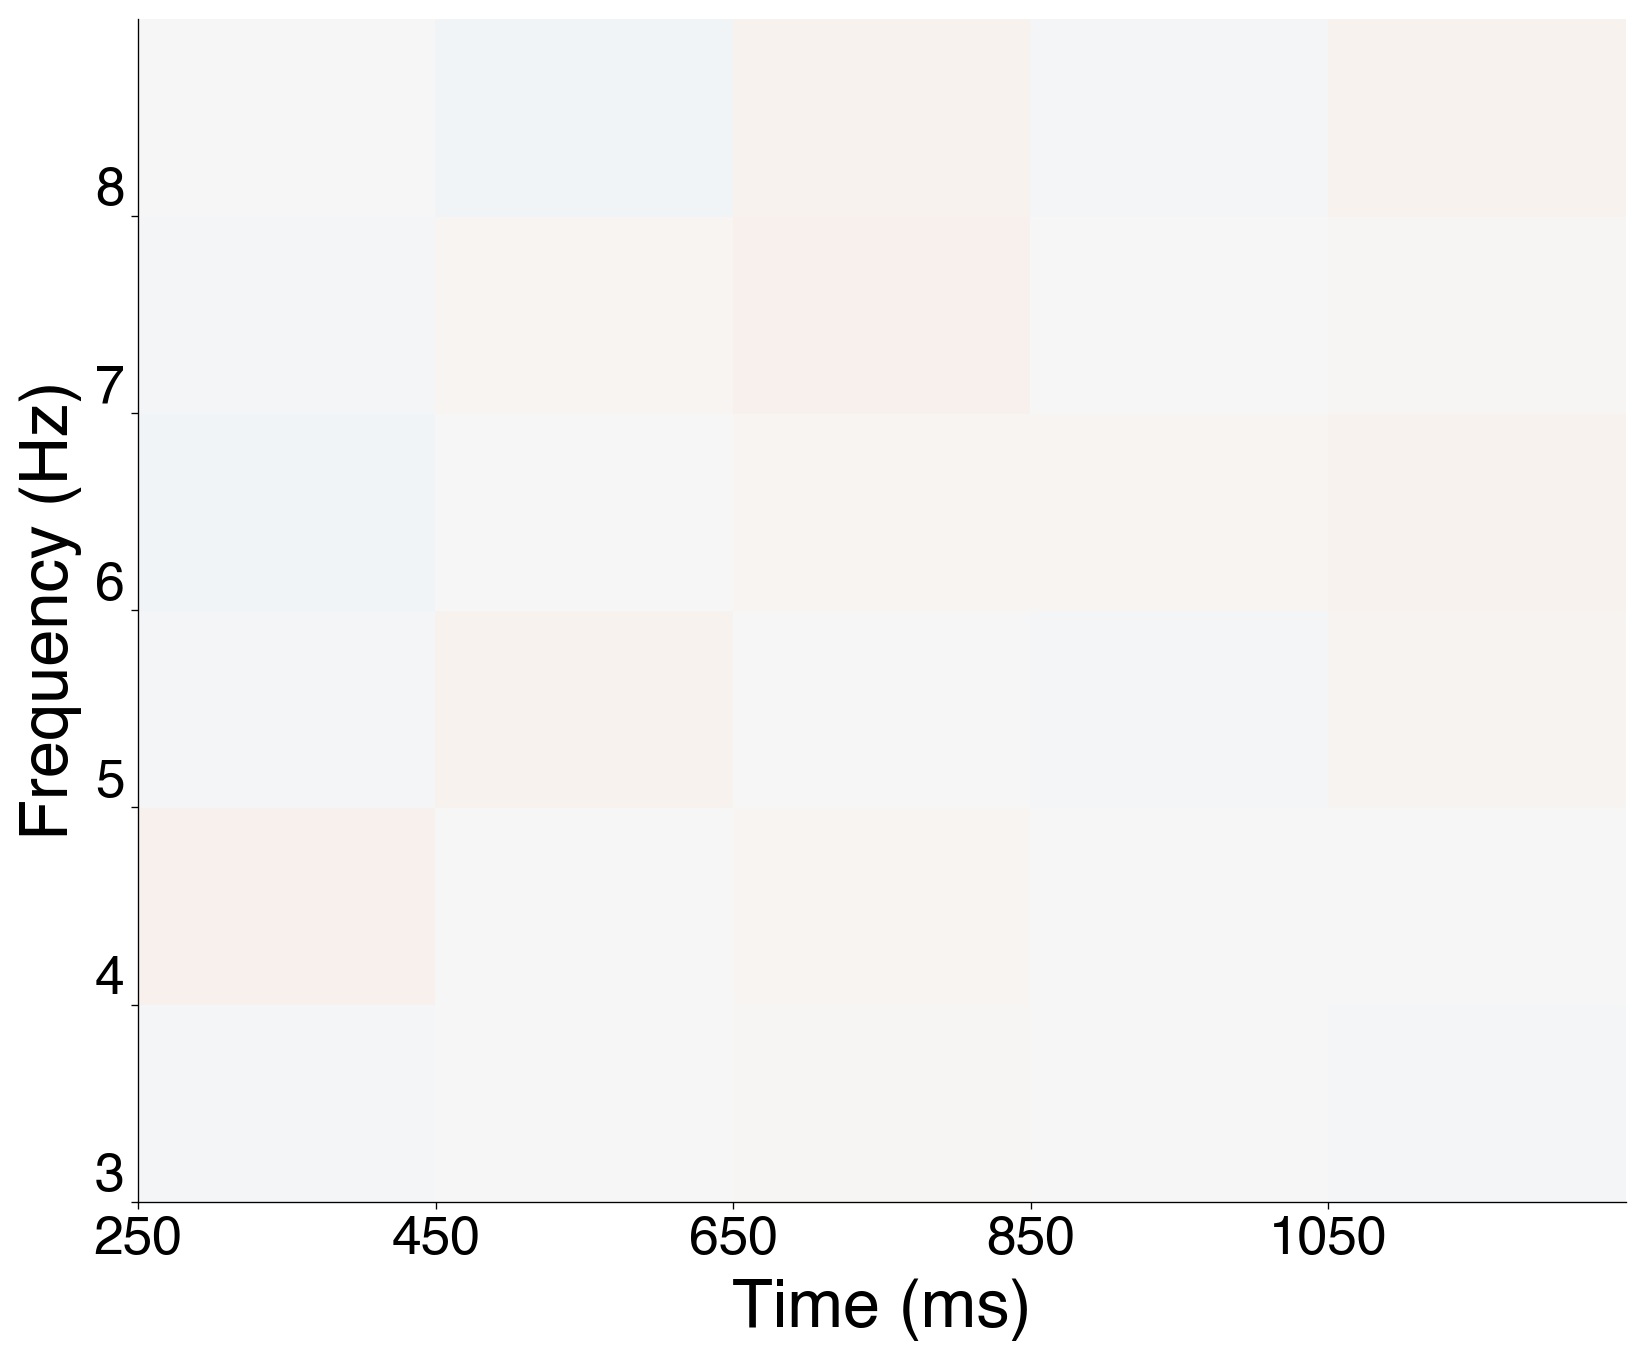

In [111]:
beh='en'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
extent = im.get_extent()
combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
shape = mx_plot.shape
linewidth = 10
color = 'yellow'
line_kwargs={"linewidth":4, "color":'k'}

color='gold'
for cell in masked_cells:
    i, j = cell
    if (i, j-1) not in masked_cells:
        ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i, j+1) not in masked_cells:
        ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i+1, j) not in masked_cells:
        ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
    if (i-1, j) not in masked_cells:
        ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

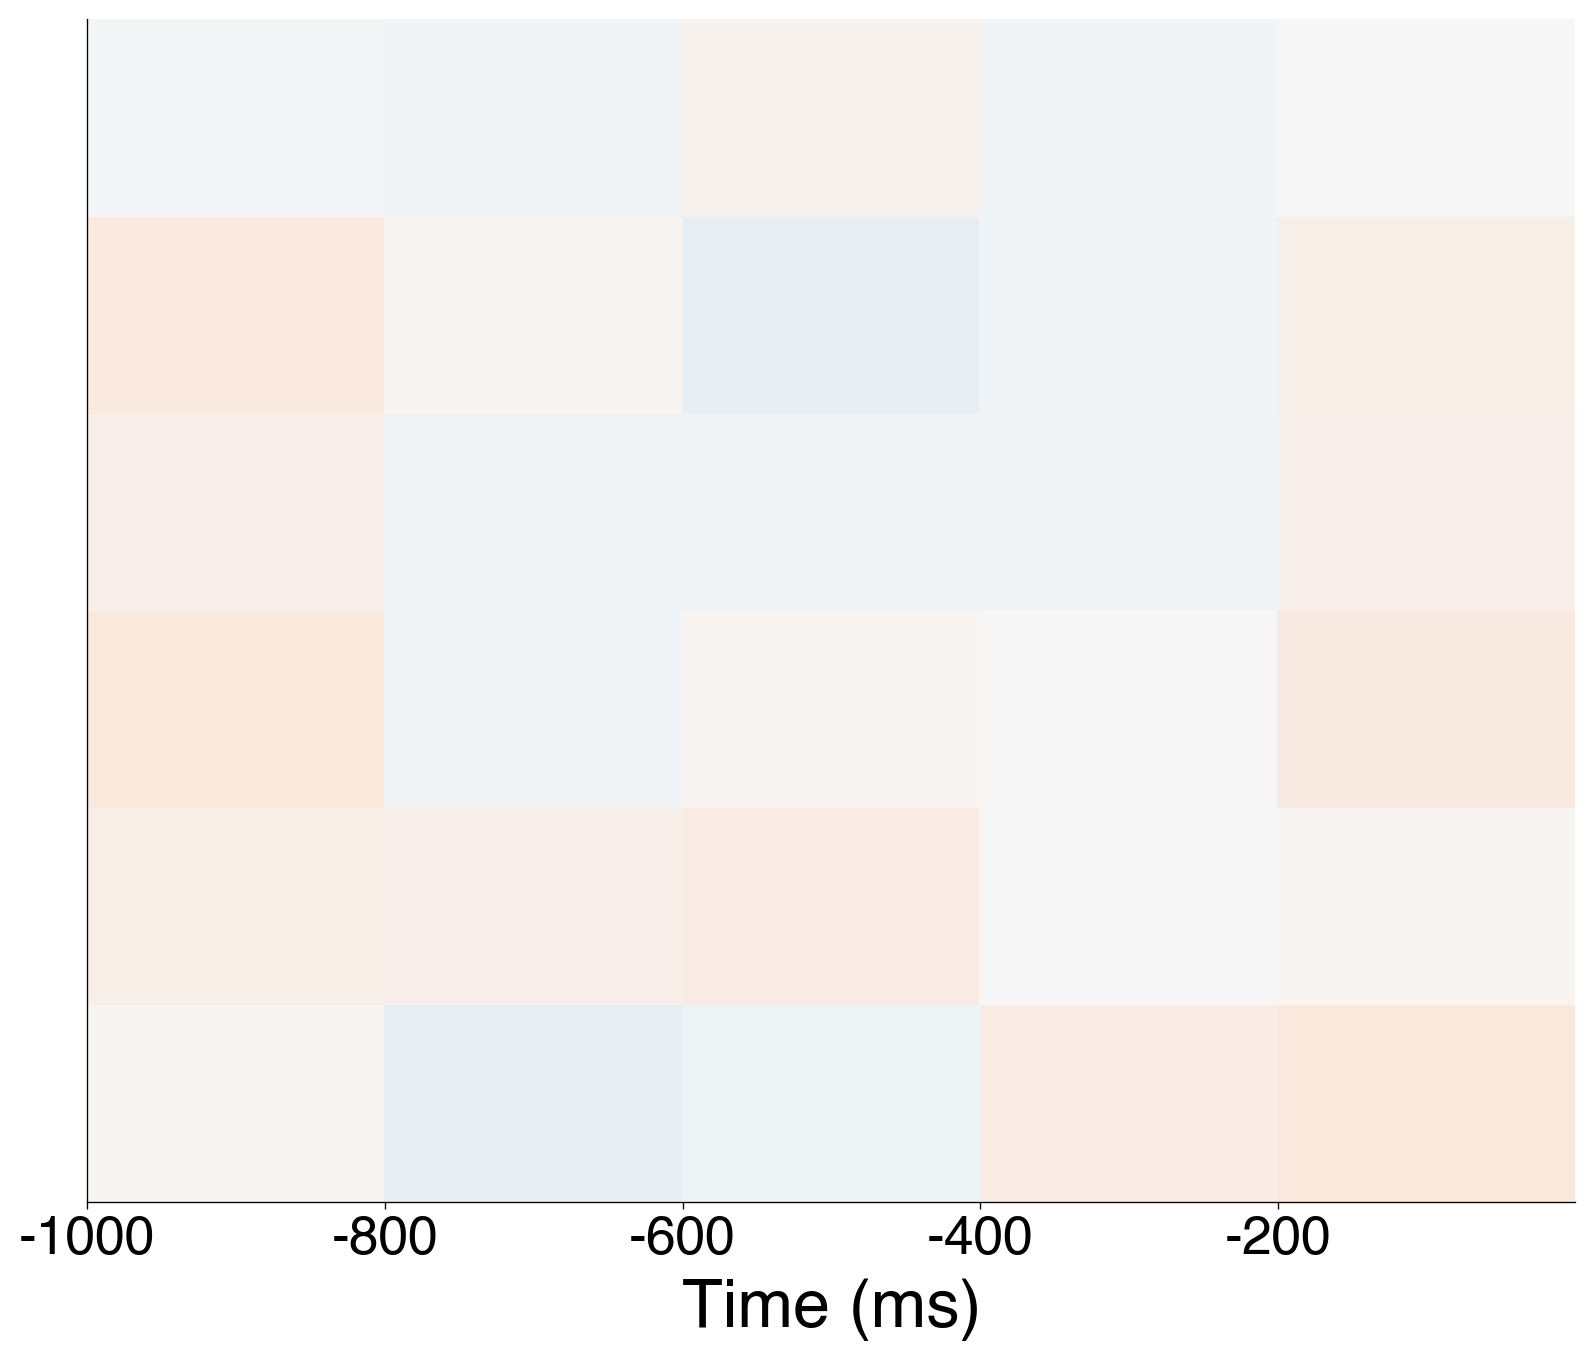

In [112]:
beh='rm'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
extent = im.get_extent()
combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
shape = mx_plot.shape
linewidth = 10
color = 'yellow'
line_kwargs={"linewidth":4, "color":'k'}

color='gold'
for cell in masked_cells:
    i, j = cell
    if (i, j-1) not in masked_cells:
        ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i, j+1) not in masked_cells:
        ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i+1, j) not in masked_cells:
        ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
    if (i-1, j) not in masked_cells:
        ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

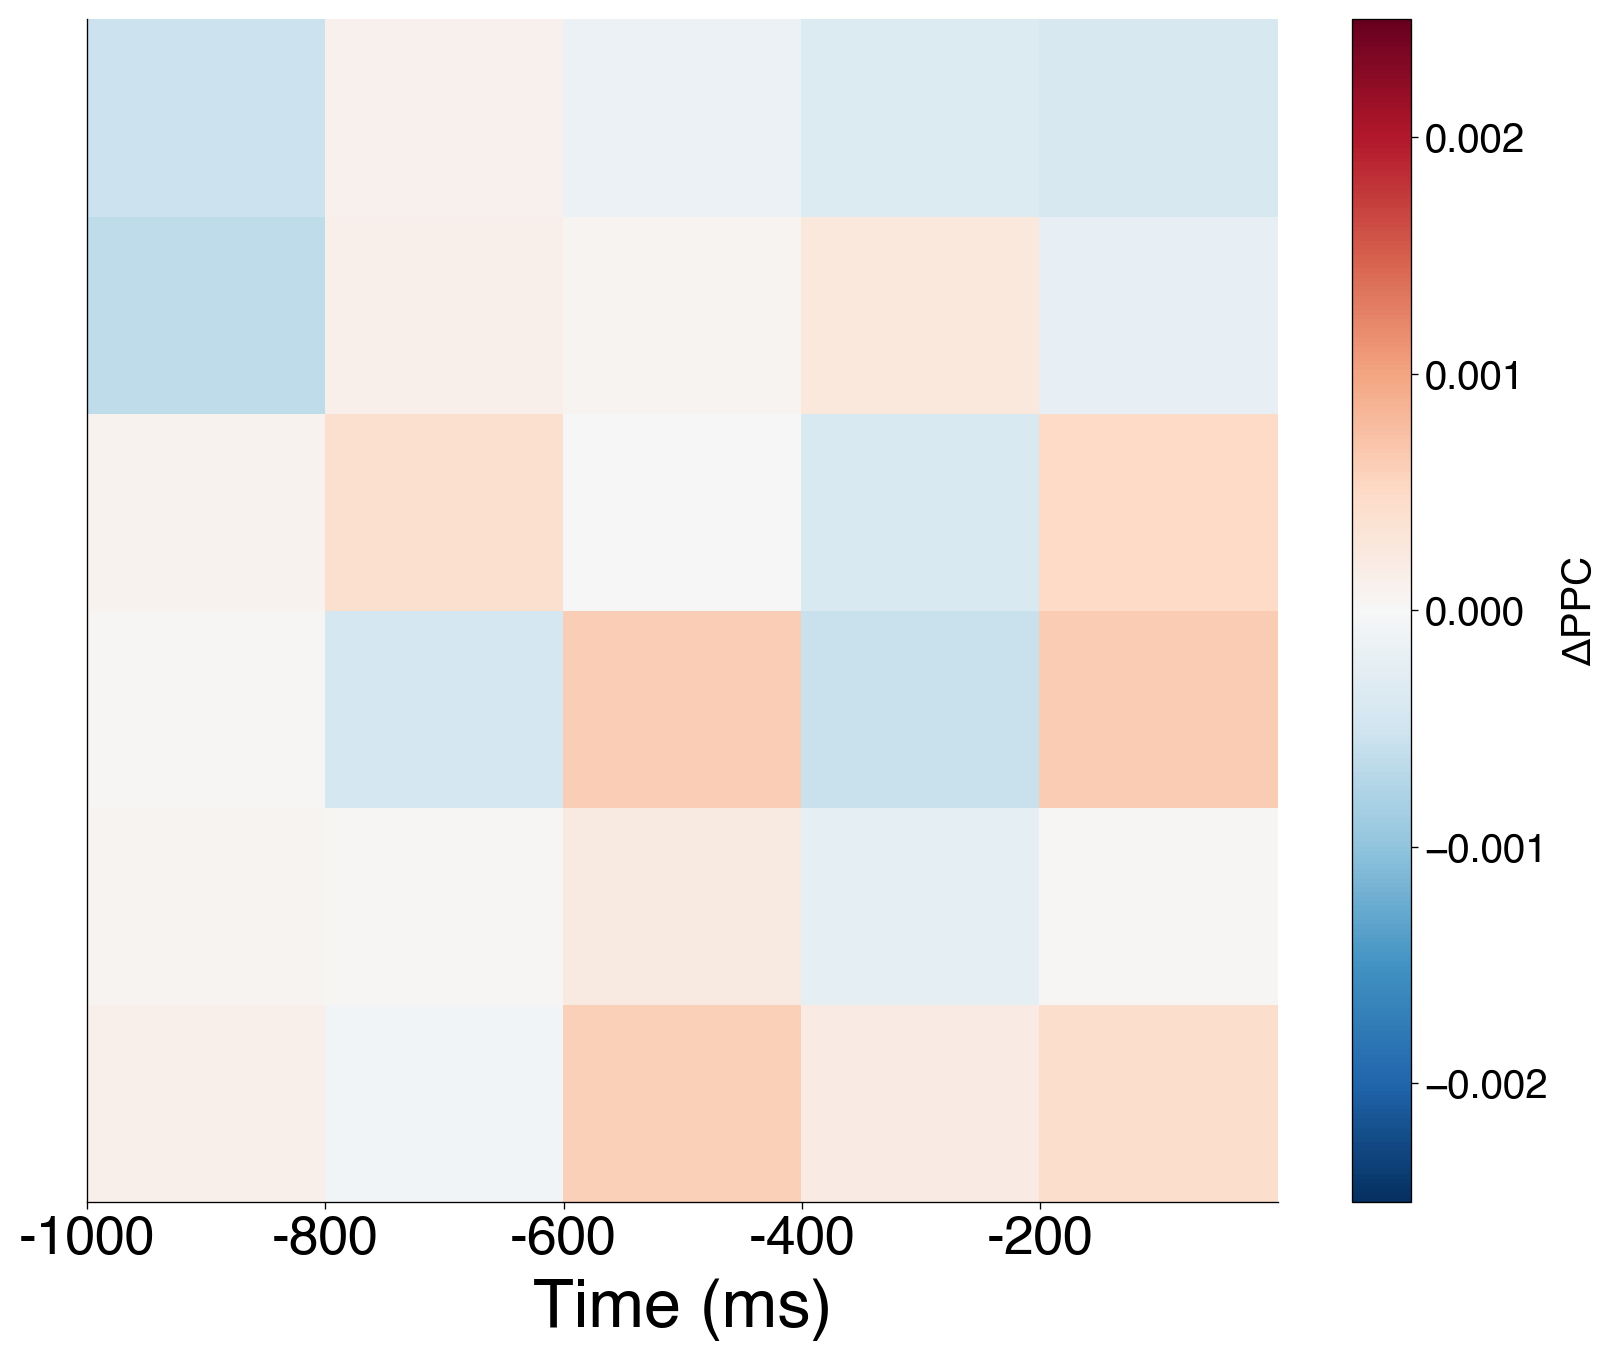

In [113]:
beh='ri'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
extent = im.get_extent()
combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
shape = mx_plot.shape
linewidth = 10
color = 'yellow'
line_kwargs={"linewidth":4, "color":'k'}

color='gold'
for cell in masked_cells:
    i, j = cell
    if (i, j-1) not in masked_cells:
        ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i, j+1) not in masked_cells:
        ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i+1, j) not in masked_cells:
        ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
    if (i-1, j) not in masked_cells:
        ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

# Difference in memory-evoked synchrony between 3 Hz and 8 Hz

In [114]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.pkl')
    mx = load_pickle(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=True) - mx.sel(success=False)
    print_ttest_1samp(mx.sel(freq=3).data, beh)
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.442, p = 0.659, Mean: -1.36e-05 ± 3.09e-05
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.391, p = 0.696, Mean: 3.61e-05 ± 9.24e-05
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = 1.11, p = 0.27, Mean: 0.000257 ± 0.000233


In [115]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.pkl')
    mx = load_pickle(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=True) - mx.sel(success=False)
    print_ttest_1samp(mx.sel(freq=8).data, beh)
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.572, p = 0.568, Mean: 1.36e-05 ± 2.37e-05
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.341, p = 0.733, Mean: -2.21e-05 ± 6.48e-05
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = -1.67, p = 0.0961, Mean: -0.000261 ± 0.000156


In [116]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.pkl')
    mx = load_pickle(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=True) - mx.sel(success=False)
    t, p = print_ttest_rel(mx.sel(freq=3).data, mx.sel(freq=8).data, beh)
    N = len(mx.sub)
    print(f'B_01: {jzs_bayes_factor(t, N)}')
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.67, p = 0.503, Mean_A: -1.36e-05 ± 3.09e-05, Mean_B: 1.36e-05 ± 2.37e-05, Mean_Diff: -2.72e-05 ± 4.06e-05
B_01: 19.63947466545825
---------rm---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.491, p = 0.624, Mean_A: 3.61e-05 ± 9.24e-05, Mean_B: -2.21e-05 ± 6.48e-05, Mean_Diff: 5.83e-05 ± 0.000119
B_01: 21.778037191333098
---------ri---------
Statistically Significant (p < 0.05)
t_166 = 1.99, p = 0.0479, Mean_A: 0.000257 ± 0.000233, Mean_B: -0.000261 ± 0.000156, Mean_Diff: 0.000519 ± 0.00026
B_01: 2.3142532294740707


## Figure 4A

In [117]:
fig4_df = pd.DataFrame([], columns=['beh', 'freq', 'data'])
for beh in ['en', 'rm', 'ri']:
    fname = join(root_dir, f'{beh}_pop_symx.pkl')
    mx = load_pickle(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=True) - mx.sel(success=False)
    for freq in [3, 8]:
        fig4_df = pd.concat([fig4_df, pd.DataFrame({'beh': beh,
                                                    'freq': freq,
                                                    'data': mx.sel(freq=freq).data})],
                            ignore_index=True,
                            axis=0)
fig4_df = fig4_df.replace({'en': 'Encoding',
                           'rm': 'Retrieval',
                           'ri': 'Recall Accuracy',
                            3: '3 Hz',
                            8: '8 Hz'})
fig4_df.to_json(join(root_dir, 'fig4_df.json'))

Text(0, 0.5, 'ΔPPC')

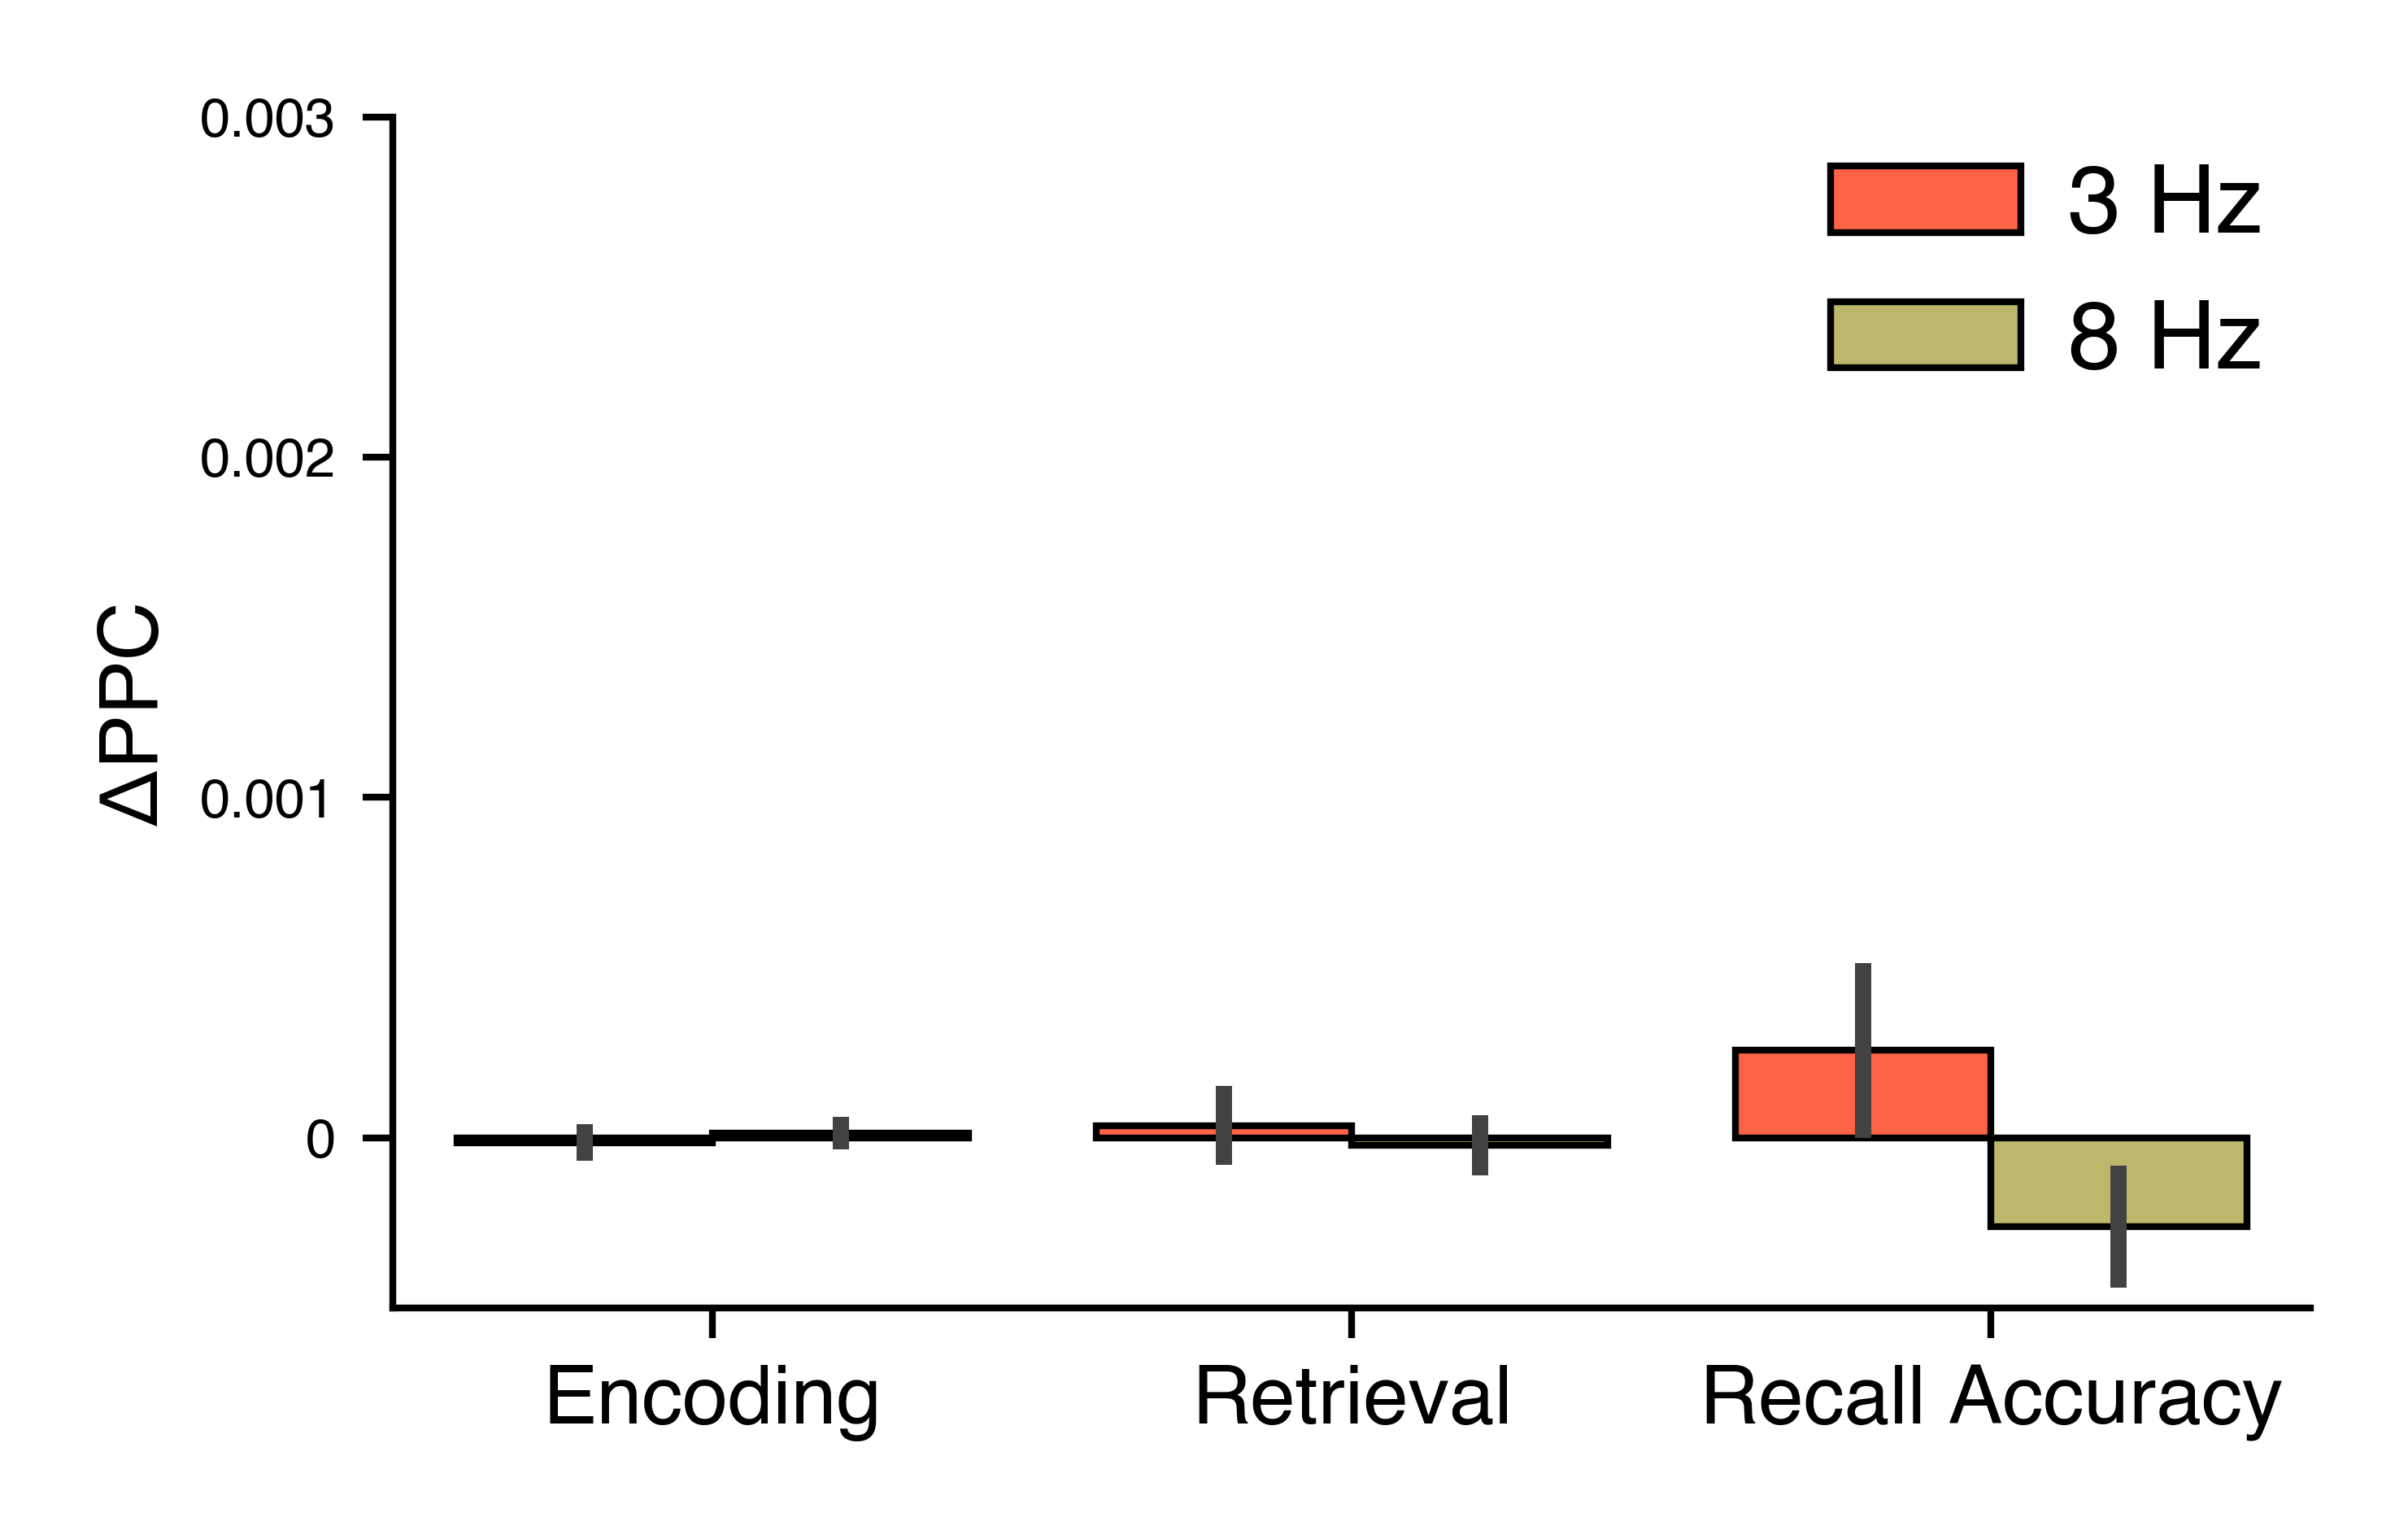

In [118]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
mpl.rc('text', usetex=False)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.0005
ymax = 0.003
yticks = [0, .001, .002, .003]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='freq', data=fig4_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', linewidth=spine_lw, ec='k',
                 palette=['tomato', 'darkkhaki'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


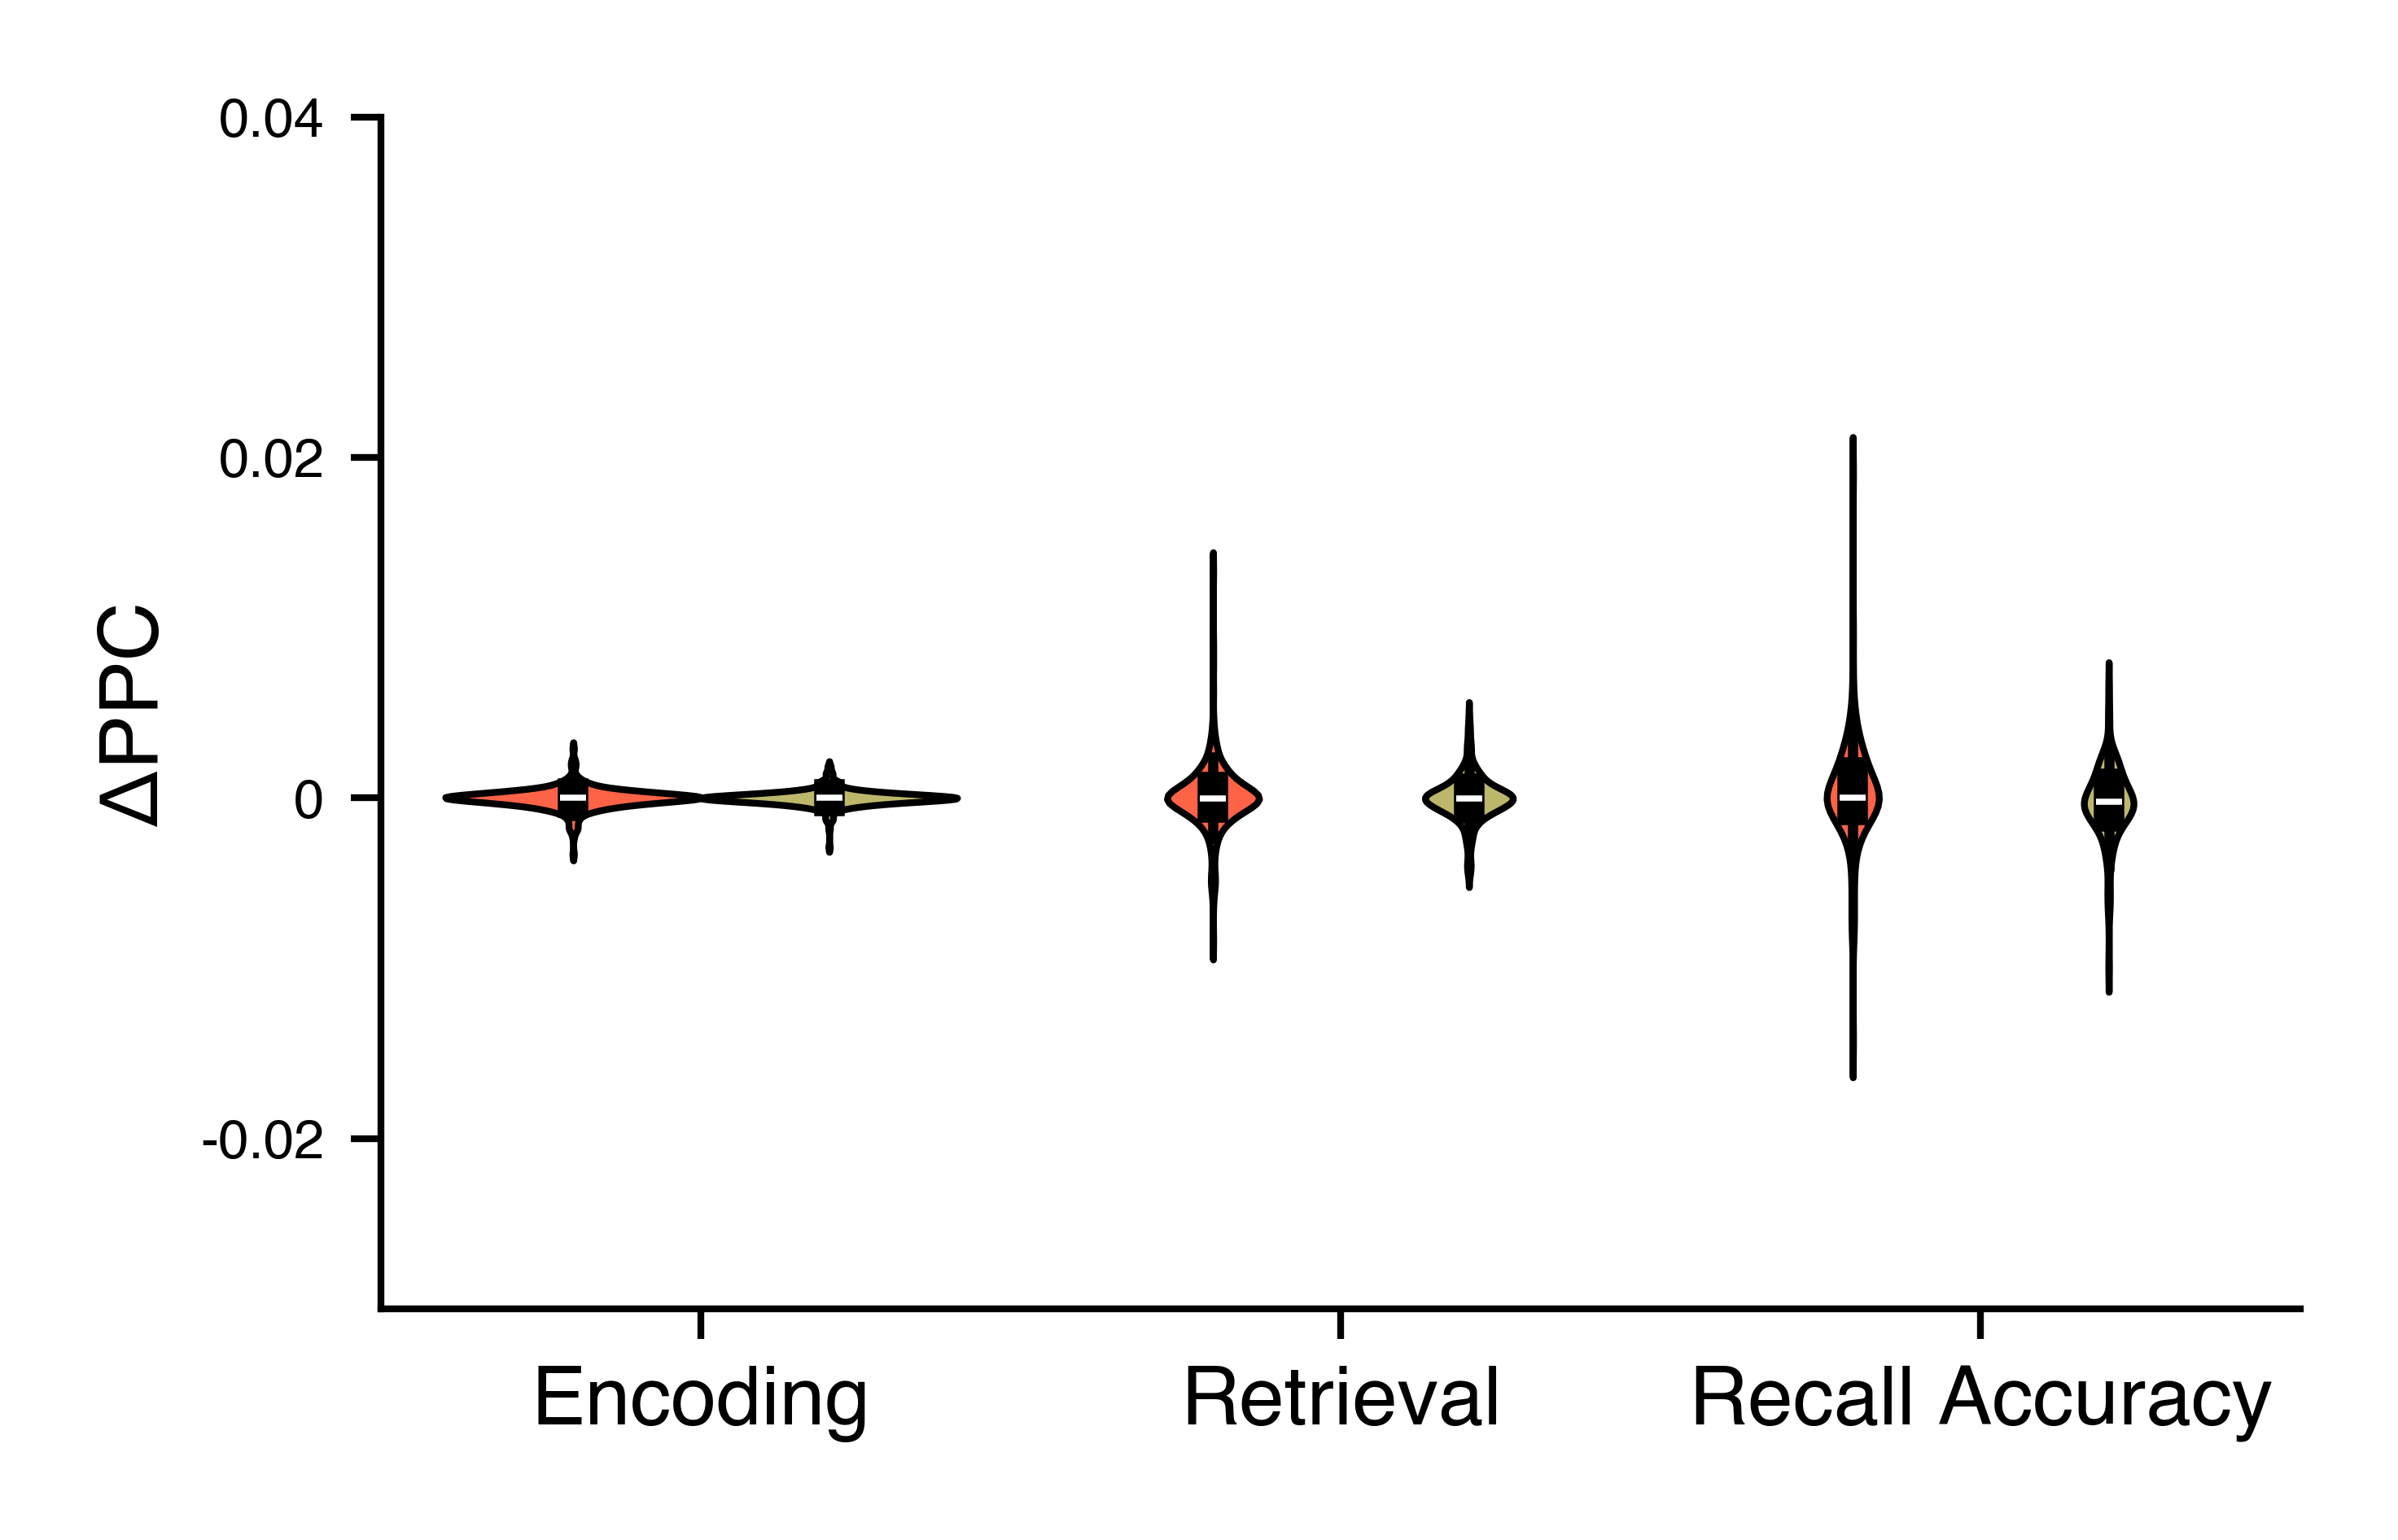

In [119]:
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.03
ymax = 0.04
yticks = [-0.02, 0, 0.02, 0.04]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.violinplot(x='beh', y='data', hue='freq', data=fig4_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  linewidth=spine_lw, 
                  edgecolor='k',
                 palette=['tomato', 'darkkhaki'])
# _ax.legend(fontsize=7, handletextpad=0.5, title=None, loc='upper center')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Encoding–retrieval correlation

In [120]:
import shutil
split_dir_path = join(root_dir, 'rm_split')
if ex(split_dir_path): shutil.rmtree(split_dir_path)
split_dir_path = join(root_dir, 'ri_split')
if ex(split_dir_path): shutil.rmtree(split_dir_path)

In [121]:
split_dir_path = join(root_dir, 'rm_split')
if not ex(split_dir_path): os.mkdir(split_dir_path)
for f1 in ['a', 'b']:
    path = join(split_dir_path, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['events', 'elsymxs', 'regsymxs']:
        path = join(split_dir_path, f1, f2)
        if not ex(path): os.mkdir(path)

In [122]:
def run_split_rm_events(dfrow):
    
    np.random.seed(202406)
        
    dfrow = get_dfrow(dfrow)
    rm_events = load_events(dfrow, 'rm')    
    pair_count = len(rm_events)//2
    rm_events['pair_idx'] = np.arange(0, pair_count, 0.5).astype(int)
    
    pair_idxs = rm_events['pair_idx'].unique()
    np.random.shuffle(pair_idxs)
    first_group_idxs, second_group_idxs = np.array_split(pair_idxs, 2)
    
    first_group = rm_events.query('pair_idx in @first_group_idxs')
    second_group = rm_events.query('pair_idx in @second_group_idxs')

    first_group.to_json(join(root_dir, 'rm_split', 'a', 'events', f'{ftag(dfrow)}_rm_events_split_a.json'))
    second_group.to_json(join(root_dir, 'rm_split', 'b', 'events', f'{ftag(dfrow)}_rm_events_split_b.json'))
        

In [123]:
def run_pipeline_rm_split(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for split_idx in ['a', 'b']:
        save_dir = join(root_dir, 'rm_split', split_idx)
        events_path = join(save_dir, 'events', f'{ftag(dfrow)}_rm_events_split_{split_idx}.json')
        if not ex(events_path): run_split_rm_events(dfrow)
        events = pd.read_json(events_path)
        events.attrs['beh'] = 'rm'
        events.attrs['mask'] = (events['type'] == 'REC_WORD').values
        if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.pkl')): continue
        run_pipeline(dfrow, 'rm', events, save_dir, simulation_tag=simulation_tag)

In [124]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [ ]:
client = cl('run_pipeline_rm_split', '10G', int(3000/10), walltime=100000) 
futures = client.map(run_pipeline_rm_split, sess_list)
wait(futures, client, check_delay=60)

Simulations finished after 1.08e+03 s: 994 / 999 (0.92 iterations/s). 0 job errors


In [ ]:
split_dir_path = join(root_dir, 'ri_split')
if not ex(split_dir_path): os.mkdir(split_dir_path)
for f1 in ['a', 'b']:
    path = join(split_dir_path, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['events', 'elsymxs', 'regsymxs']:
        path = join(split_dir_path, f1, f2)
        if not ex(path): os.mkdir(path)

In [ ]:
def run_split_ri_events(dfrow):
    import helper
    helper.root_dir = root_dir
    
    np.random.seed(202406)
        
    dfrow = get_dfrow(dfrow)
    ri_events = load_events(dfrow, 'ri')    
    pair_count = len(ri_events)//2
    ri_events['pair_idx'] = np.arange(0, pair_count, 0.5).astype(int)
    
    pair_idxs = ri_events['pair_idx'].unique()
    np.random.shuffle(pair_idxs)
    first_group_idxs, second_group_idxs = np.array_split(pair_idxs, 2)
    
    first_group = ri_events.query('pair_idx in @first_group_idxs')
    second_group = ri_events.query('pair_idx in @second_group_idxs')

    first_group.to_json(join(root_dir, 'ri_split', 'a', 'events', f'{ftag(dfrow)}_ri_events_split_a.json'))
    second_group.to_json(join(root_dir, 'ri_split', 'b', 'events', f'{ftag(dfrow)}_ri_events_split_b.json'))
        

In [ ]:
def run_pipeline_ri_split(dfrow):
    import helper
    helper.root_dir = root_dir
    
    dfrow = get_dfrow(dfrow)
    for split_idx in ['a', 'b']:
        save_dir = join(root_dir, 'ri_split', split_idx)
        events_path = join(save_dir, 'events', f'{ftag(dfrow)}_ri_events_split_{split_idx}.json')
        if not ex(events_path): run_split_ri_events(dfrow)
        events = pd.read_json(events_path)
        events.attrs['beh'] = 'ri'
        events.attrs['mask'] = (events['correct'] == 1).values
        if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.pkl')): continue
        run_pipeline(dfrow, 'ri', events, save_dir, simulation_tag=simulation_tag)

In [ ]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [130]:
client2 = cl('run_pipeline_ri_split', '10G', int(1000/10), walltime=100000) 
futures2 = client2.map(run_pipeline_ri_split, sess_list_ri)
wait(futures2, client2, check_delay=60)

Simulations finished after 1.32e+03 s: 319 / 319 (0.242 iterations/s). 0 job errors
Simulation complete. Shutting down jobs.


In [131]:
client.shutdown()
client2.shutdown()

In [132]:
get_ex(futures, sess_list)

In [133]:
get_ex(futures2, sess_list_ri)

In [134]:
def apply_spearman_brown_correction(r): return (2*r)/(1+r)

def compute_intercontrast_correlations(beh1, beh2):
    
    if ('ri' in beh1) or ('ri' in beh2): sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    
    sub_list = sess_list_df['sub'].unique()
    
    sub_corrs = []
    
    for iSub, sub in enumerate(sub_list):
        
        sess_corrs = []
        
        for iSess, rSess in sess_list_df.query('sub == @sub').iterrows():
            
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            beh1_mx = npl(join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
            beh2_mx = npl(join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
    
            beh1_mx = beh1_mx[..., 0] - beh1_mx[..., 1]
            beh2_mx = beh2_mx[..., 0] - beh2_mx[..., 1]
            
            beh1_mx = np.nanmean(np.nanmean(np.nanmean(beh1_mx, axis=-1), axis=-1), axis=-1)
            beh2_mx = np.nanmean(np.nanmean(np.nanmean(beh2_mx, axis=-1), axis=-1), axis=-1)
            
            r = scipy.stats.pearsonr(beh1_mx, beh2_mx)[0]
            if (beh1, beh2) in [('rm_split/a', 'rm_split/b'), ('rm_split/a', 'rm_split/b')]: 
                r = apply_spearman_brown_correction(r)

            sess_corrs.append(r)
            
        sub_corrs.append(np.mean(sess_corrs))
        
    return np.asarray(sub_corrs)
        

In [135]:
en_rm_sub_corrs = compute_intercontrast_correlations('en', 'rm')
print_ttest_1samp(en_rm_sub_corrs, header='en / rm correlation')

---------en / rm correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.363, p = 0.717, Mean: -0.00131 ± 0.00362


(-0.3625003452913144, 0.7171791622224313)

In [136]:
rm_split_sub_corrs = compute_intercontrast_correlations('rm_split/a', 'rm_split/b')
print_ttest_1samp(rm_split_sub_corrs, header='rm split-half correlation')

---------rm split-half correlation---------
Statistically Significant (p < 0.05)
t_381 = -3.69, p = 0.00026, Mean: -0.0301 ± 0.00818


(-3.6866212798850695, 0.00026023225336865673)

In [137]:
en_ri_sub_corrs = compute_intercontrast_correlations('en', 'ri')
print_ttest_1samp(en_ri_sub_corrs, header='en / ri correlation')

---------en / ri correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.0628, p = 0.95, Mean: 0.000429 ± 0.00682


(0.06280391169062188, 0.9499982090951116)

In [138]:
ri_split_sub_corrs = compute_intercontrast_correlations('ri_split/a', 'ri_split/b')
print_ttest_1samp(ri_split_sub_corrs, header='ri split-half correlation')

---------ri split-half correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = -0.822, p = 0.412, Mean: -0.00582 ± 0.00708


(-0.8221249429773152, 0.41218508835086476)

In [139]:
en_rm_t, en_rm_p = print_ttest_rel(en_rm_sub_corrs, rm_split_sub_corrs)

Statistically Significant (p < 0.05)
t_381 = 3.2, p = 0.00149, Mean_A: -0.00131 ± 0.00362, Mean_B: -0.0301 ± 0.00818, Mean_Diff: 0.0288 ± 0.00901


In [140]:
en_ri_t, en_ri_p = print_ttest_rel(en_ri_sub_corrs, ri_split_sub_corrs)

NOT Statistically Significant (p >= 0.05)
t_166 = 0.627, p = 0.531, Mean_A: 0.000429 ± 0.00682, Mean_B: -0.00582 ± 0.00708, Mean_Diff: 0.00625 ± 0.00996


In [141]:
jzs_bayes_factor(t = en_rm_t, N = 378)

0.1585948452019451

In [142]:
jzs_bayes_factor(t = en_ri_t, N = 167)

13.399365688671372

## Figure 5

In [143]:
fig5_df = pd.DataFrame([], columns=['beh', 'type', 'data'])
for name, correlation_type, behs in zip(['Encoding / Retrieval', 'Encoding / Retrieval', 'Encoding / Recall Accuracy', 'Encoding / Recall Accuracy'],
                                        ['Observed', 'Benchmark', 'Observed', 'Benchmark'],
                                        [('en', 'rm'), ('rm_split/a', 'rm_split/b'), ('en', 'ri'), ('ri_split/a', 'ri_split/b')]):
    
    rs = compute_intercontrast_correlations(*behs)
    fig5_df = pd.concat([fig5_df, pd.DataFrame({'name': name,
                                                'correlation_type': correlation_type,
                                                'data': rs})],
                         axis=0)

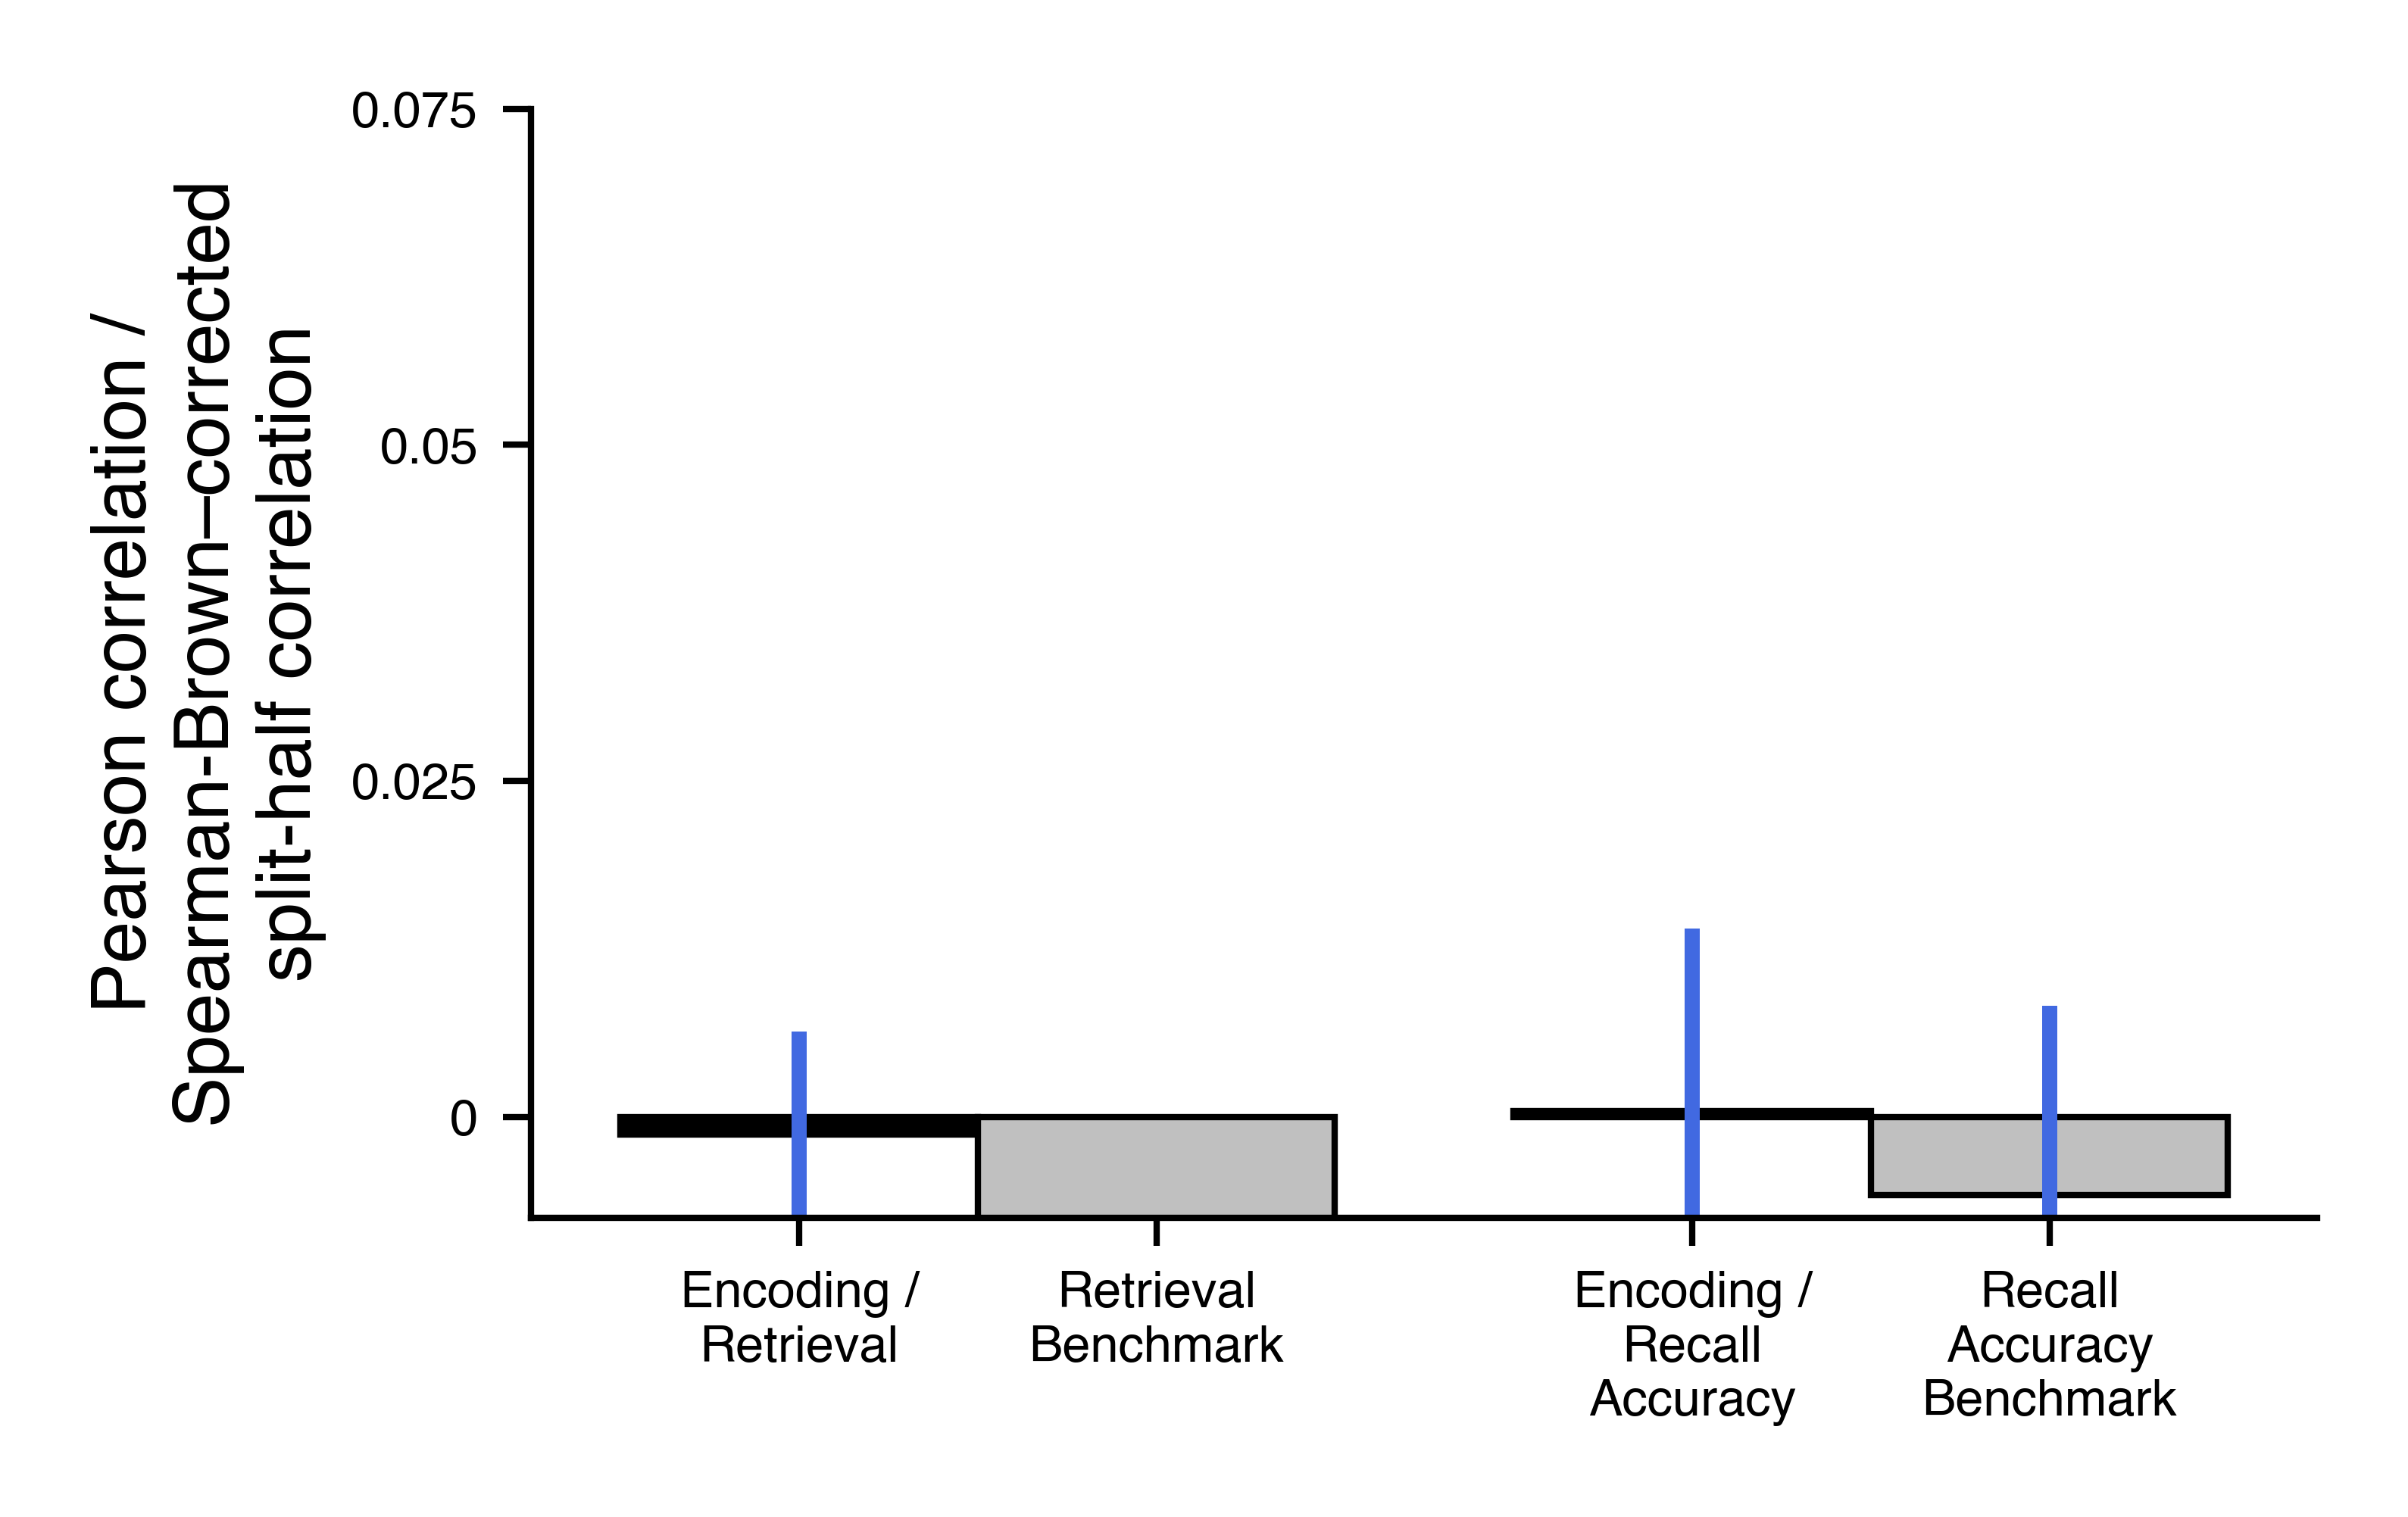

In [144]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
mpl.rc('text', usetex=False)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *
import textwrap

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.0075
ymax = 0.075
yticks = [0, 0.025, 0.05, 0.075]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='name', y='data', hue='correlation_type', data=fig5_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  linewidth=spine_lw, edgecolor='k', err_kws={'color': 'royalblue'},
                 palette=['black', 'silver'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
labels = ['Encoding / Retrieval', 'Retrieval Benchmark', 'Encoding / Recall Accuracy', 'Recall Accuracy Benchmark']
labels = [textwrap.fill(label, width=10, break_long_words=True) for label in labels]
_ax.set_xticklabels(labels, fontsize=4)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('Pearson correlation /\n Spearman-Brown–corrected\n split-half correlation', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Power–synchrony correlation

Here we compute the within-subject correlation between the theta synchrony effect of memory and the theta or gamma power memory effect. The correlation is performed across electrode contacts between the mean brain-wide memory-evoked synchrony values and the memory-evoked power values, after averaging over frequencies and epochs. We then perform a 1-sample t-test against population mean zero to test the statistical significance of the correlation.

In [145]:
def compute_power_synchrony_correlations(beh, freq):
    
    # assert freq in ['theta', *np.arange(3, 9)], 'freq must be specified as "theta" for theta average or as one of the theta frequencies'
    
    if beh == 'ri': sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    sess_list_df = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    sess_list_df['correlation'] = np.nan
    
    def compute_power_synchrony_correlation(r):
        
        dfrow = get_dfrow(r.name)
        freq_band = 'gamma' if freq == 'gamma' else 'theta'
        symx_fname = join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        pomx_fname = join(root_dir, beh, 'elpomxs', freq_band, f'{ftag(dfrow)}_elpomxd.npy')
        
        symx = npl(symx_fname)
        pomx = npl(pomx_fname)
        
        symx = symx[...,0] - symx[...,1]
        if freq in ['theta', 'gamma']:
            symx = np.nanmean(np.nanmean(np.nanmean(symx, axis=-1), axis=-1), axis=-1)
            pomx = np.nanmean(np.nanmean(pomx, axis=-1), axis=-1)
        else:
            symx = symx[:, :, (freq-3), :]
            pomx = pomx[:, (freq-3), :]
            symx = np.nanmean(np.nanmean(symx, axis=-1), axis=-1)
            pomx = np.nanmean(pomx, axis=-1)
        
        where_finite = np.isfinite(symx) & np.isfinite(pomx)
        symx = symx[where_finite]
        pomx = pomx[where_finite]

        return scipy.stats.pearsonr(symx, pomx)[0]
    
    sess_list_df['correlation'] = sess_list_df.apply(lambda r: compute_power_synchrony_correlation(r), axis=1)
    
    return sess_list_df.groupby('sub')['correlation'].mean().values
    

In [146]:
rs = compute_power_synchrony_correlations('en', 'theta')
print_ttest_1samp(rs, header='en theta power / theta synchrony correlation')

---------en theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.669, p = 0.504, Mean: -0.00253 ± 0.00378


(-0.6690913379557129, 0.503842435691733)

In [147]:
rs = compute_power_synchrony_correlations('rm', 'theta')
print_ttest_1samp(rs, header='rm theta power / theta synchrony correlation')

---------rm theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.0277, p = 0.978, Mean: 0.000117 ± 0.00421


(0.027663589280518278, 0.9779449480637813)

In [148]:
rs = compute_power_synchrony_correlations('ri', 'theta')
print_ttest_1samp(rs, header='ri theta power / theta synchrony correlation')

---------ri theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 1.15, p = 0.252, Mean: 0.00763 ± 0.00663


(1.150614941132685, 0.25154544939792284)

In [149]:
for beh in ['en', 'rm', 'ri']:
    rs_38 = []
    for freq in [3, 8]:
        rs = compute_power_synchrony_correlations(beh, freq)
        print_ttest_1samp(rs, header=f'{beh} {freq} power / synchrony correlation')
        rs_38.append(rs)
    rs_38 = np.subtract(rs_38[0], rs_38[1])
    print_ttest_1samp(rs_38, header='diff')

---------en 3 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.091, p = 0.928, Mean: 0.000375 ± 0.00412
---------en 8 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = -1.29, p = 0.198, Mean: -0.00506 ± 0.00392
---------diff---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.935, p = 0.35, Mean: 0.00543 ± 0.00581
---------rm 3 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.0472, p = 0.962, Mean: 0.000192 ± 0.00407
---------rm 8 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_381 = 2.07, p = 0.0391, Mean: 0.00843 ± 0.00407
---------diff---------
NOT Statistically Significant (p >= 0.05)
t_381 = -1.49, p = 0.138, Mean: -0.00823 ± 0.00554
---------ri 3 power / synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.587, p = 0.558, Mean: 0.00392 ± 0.00669
---------ri 8 power / synchrony correlation---

In [150]:
rs = compute_power_synchrony_correlations('en', 'theta')
print_ttest_1samp(rs, header='en theta power / theta synchrony correlation')

---------en theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.669, p = 0.504, Mean: -0.00253 ± 0.00378


(-0.6690913379557129, 0.503842435691733)

In [151]:
rs = compute_power_synchrony_correlations('rm', 'theta')
print_ttest_1samp(rs, header='rm theta power / theta synchrony correlation')

---------rm theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.0277, p = 0.978, Mean: 0.000117 ± 0.00421


(0.027663589280518278, 0.9779449480637813)

In [152]:
rs = compute_power_synchrony_correlations('ri', 'theta')
print_ttest_1samp(rs, header='ri theta power / theta synchrony correlation')

---------ri theta power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 1.15, p = 0.252, Mean: 0.00763 ± 0.00663


(1.150614941132685, 0.25154544939792284)

In [153]:
rs = compute_power_synchrony_correlations('en', 'gamma')
print_ttest_1samp(rs, header='en gamma power / theta synchrony correlation')

---------en gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = 0.485, p = 0.628, Mean: 0.00183 ± 0.00377


(0.4853799925806704, 0.6276858062348412)

In [154]:
rs = compute_power_synchrony_correlations('rm', 'gamma')
print_ttest_1samp(rs, header='rm gamma power / theta synchrony correlation')

---------rm gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_381 = -0.651, p = 0.516, Mean: -0.00263 ± 0.00404


(-0.6508164614452978, 0.5155572644831166)

In [155]:
rs = compute_power_synchrony_correlations('ri', 'gamma')
print_ttest_1samp(rs, header='rm gamma power / theta synchrony correlation')

---------rm gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = -1.57, p = 0.118, Mean: -0.0109 ± 0.00694


(-1.5729089699222658, 0.11764392620395624)

## Figure 6

In [156]:
fig6_df = pd.DataFrame([], columns=['beh', 'freq', 'data'])
for beh in ['en', 'rm', 'ri']:
    for freq in ['theta', 3, 8]:
        rs = compute_power_synchrony_correlations(beh, freq)
        fig6_df = pd.concat([fig6_df, pd.DataFrame({'beh': beh,
                                                    'freq': f'{freq} Hz' if freq in [3, 8] else 'theta avg.',
                                                    'data': rs})],
                             axis=0)
fig6_df.replace({'en': 'Encoding', 'rm': 'Retrieval', 'ri': 'Recall Accuracy'}, inplace=True)

Text(0, 0.5, "Pearson\\'s \\textit{r}")

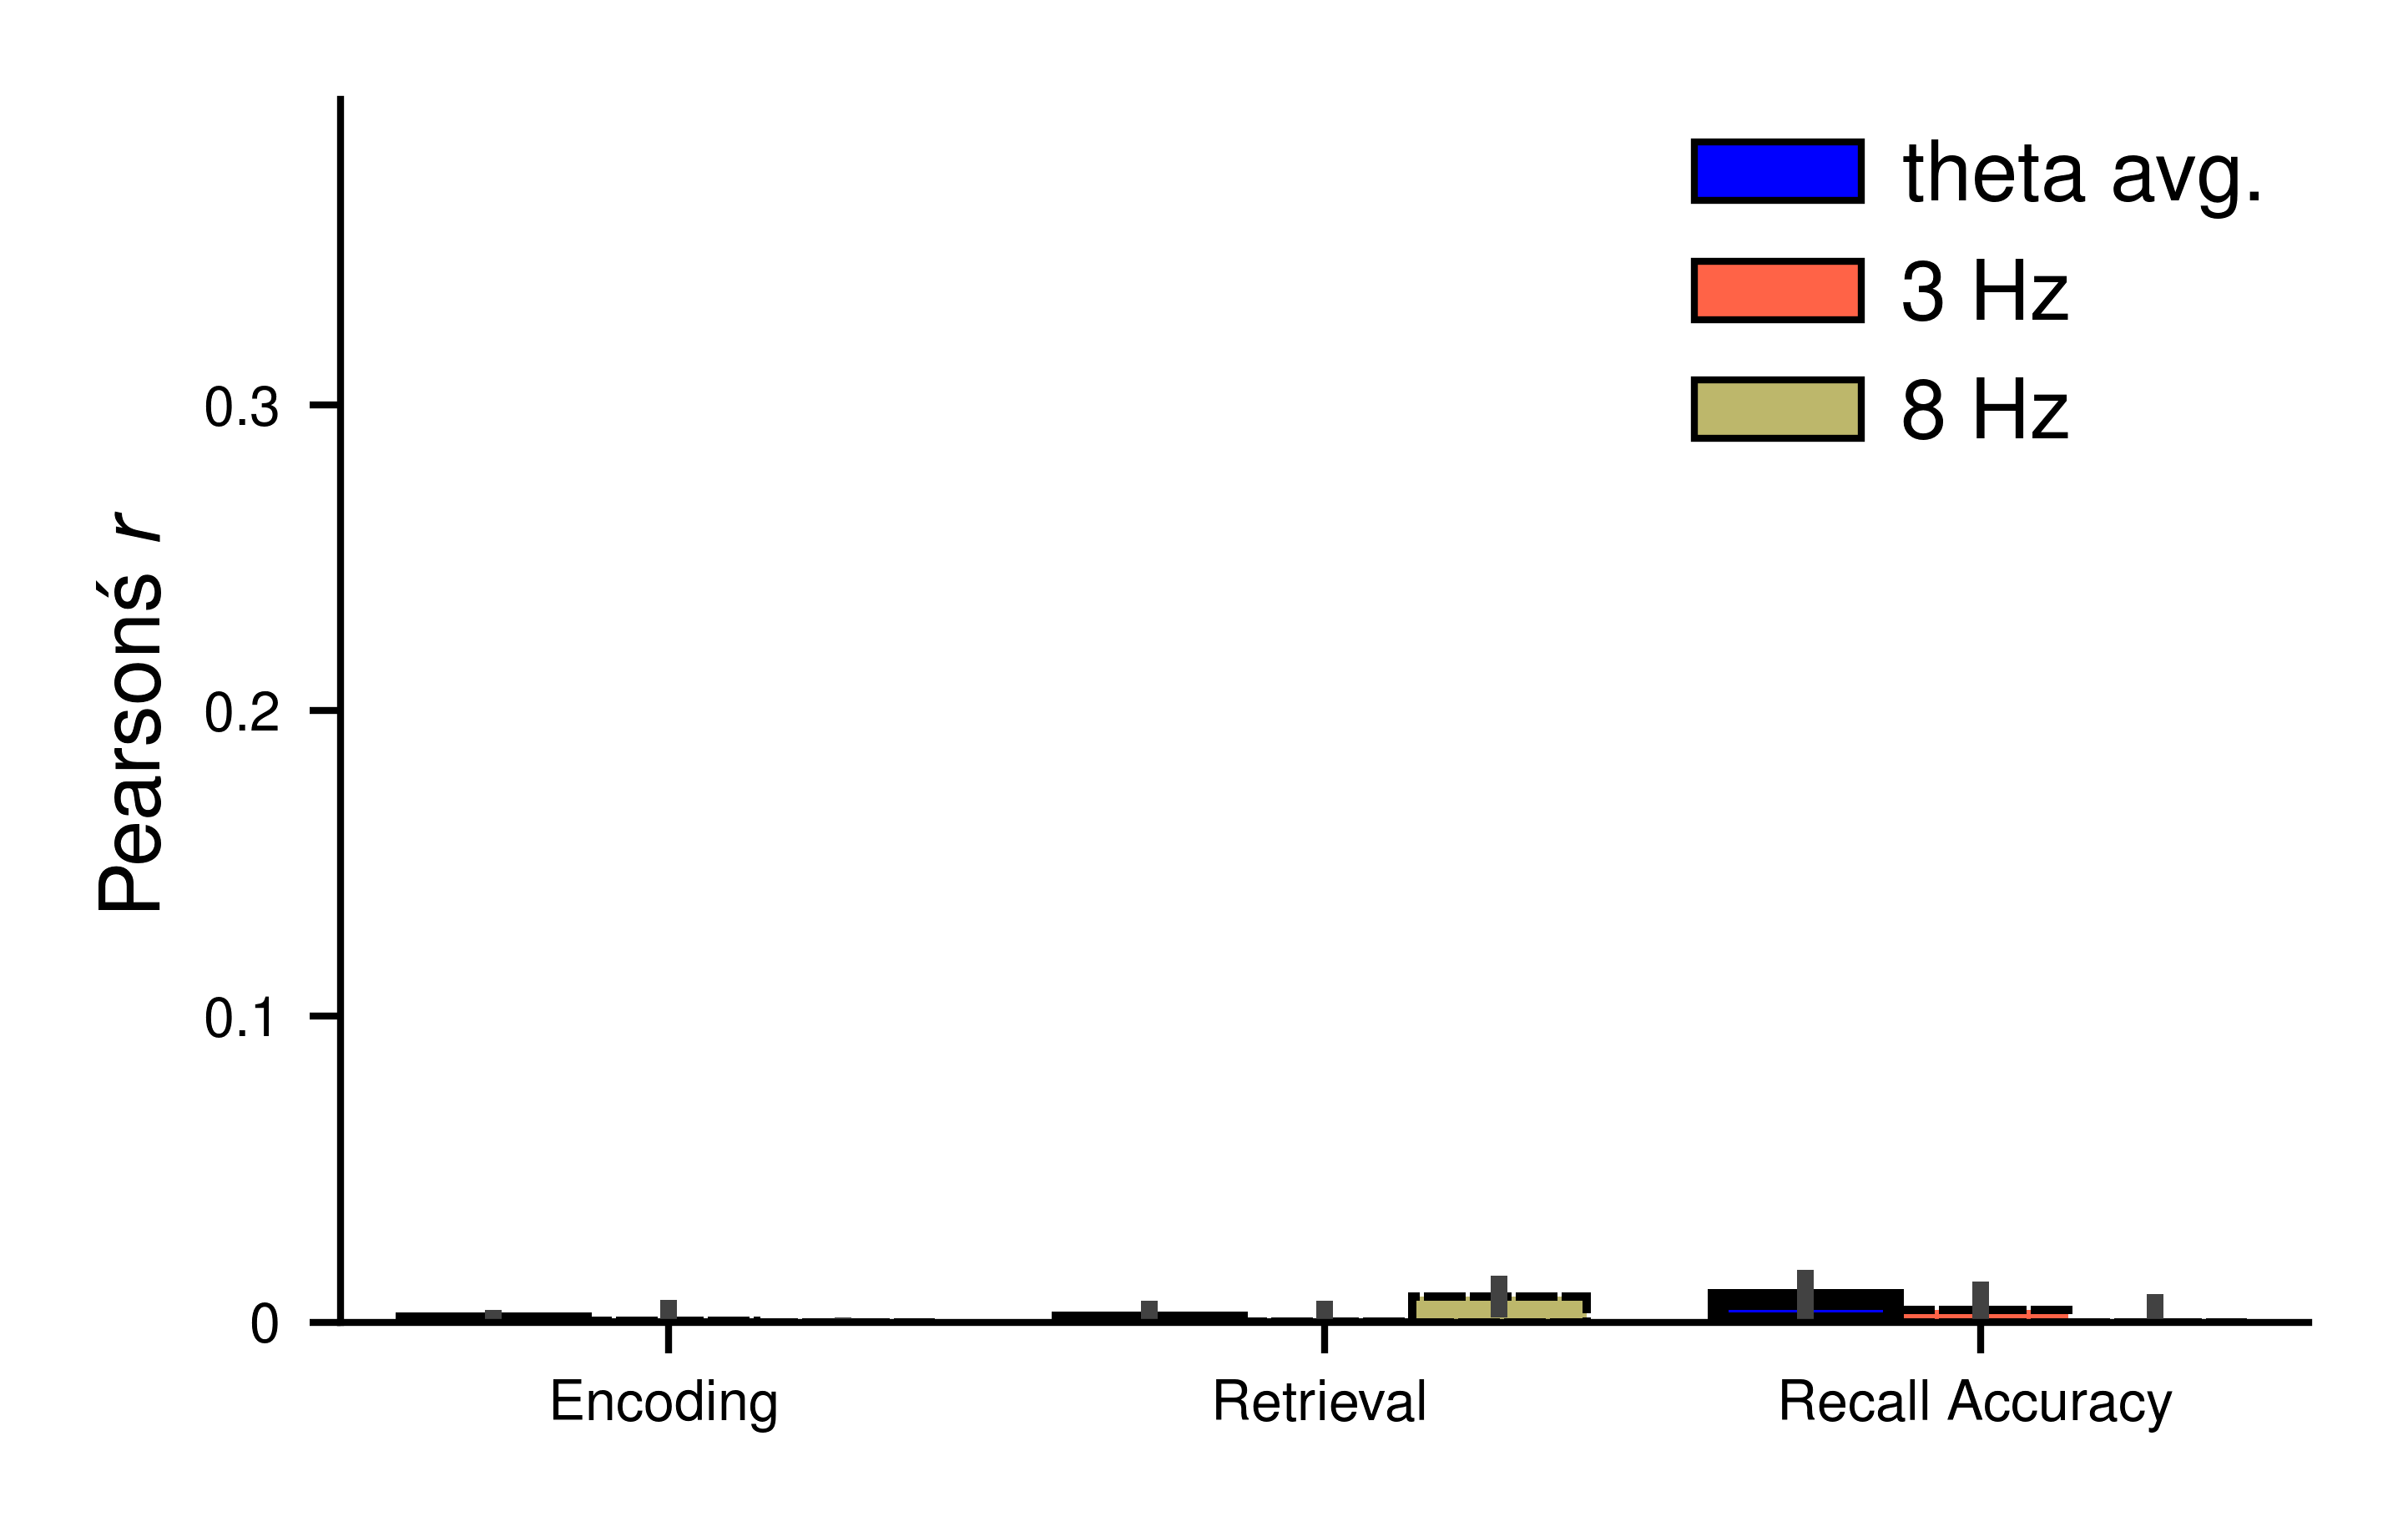

In [157]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('preferred.mplstyle')
mpl.rc('text', usetex=True)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager


font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = 0
ymax = 0.4
yticks = [0, 0.1, 0.2, 0.3]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='freq', data=fig6_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', linewidth=spine_lw, ec='k',
                 palette=['blue', 'tomato', 'darkkhaki'])
_ax.legend(fontsize=6, handletextpad=0.5, title=None, loc='upper right')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=4)
for i in np.arange(3):
    _ax.containers[0].patches[i].set(zorder=2, edgecolor='black', linewidth=1.5)
    for j in [1, 2]:
        _ax.containers[j].patches[i].set(linestyle=(0, (5, 0.5)), linewidth=0.6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel(r'Pearson\'s \textit{r}', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


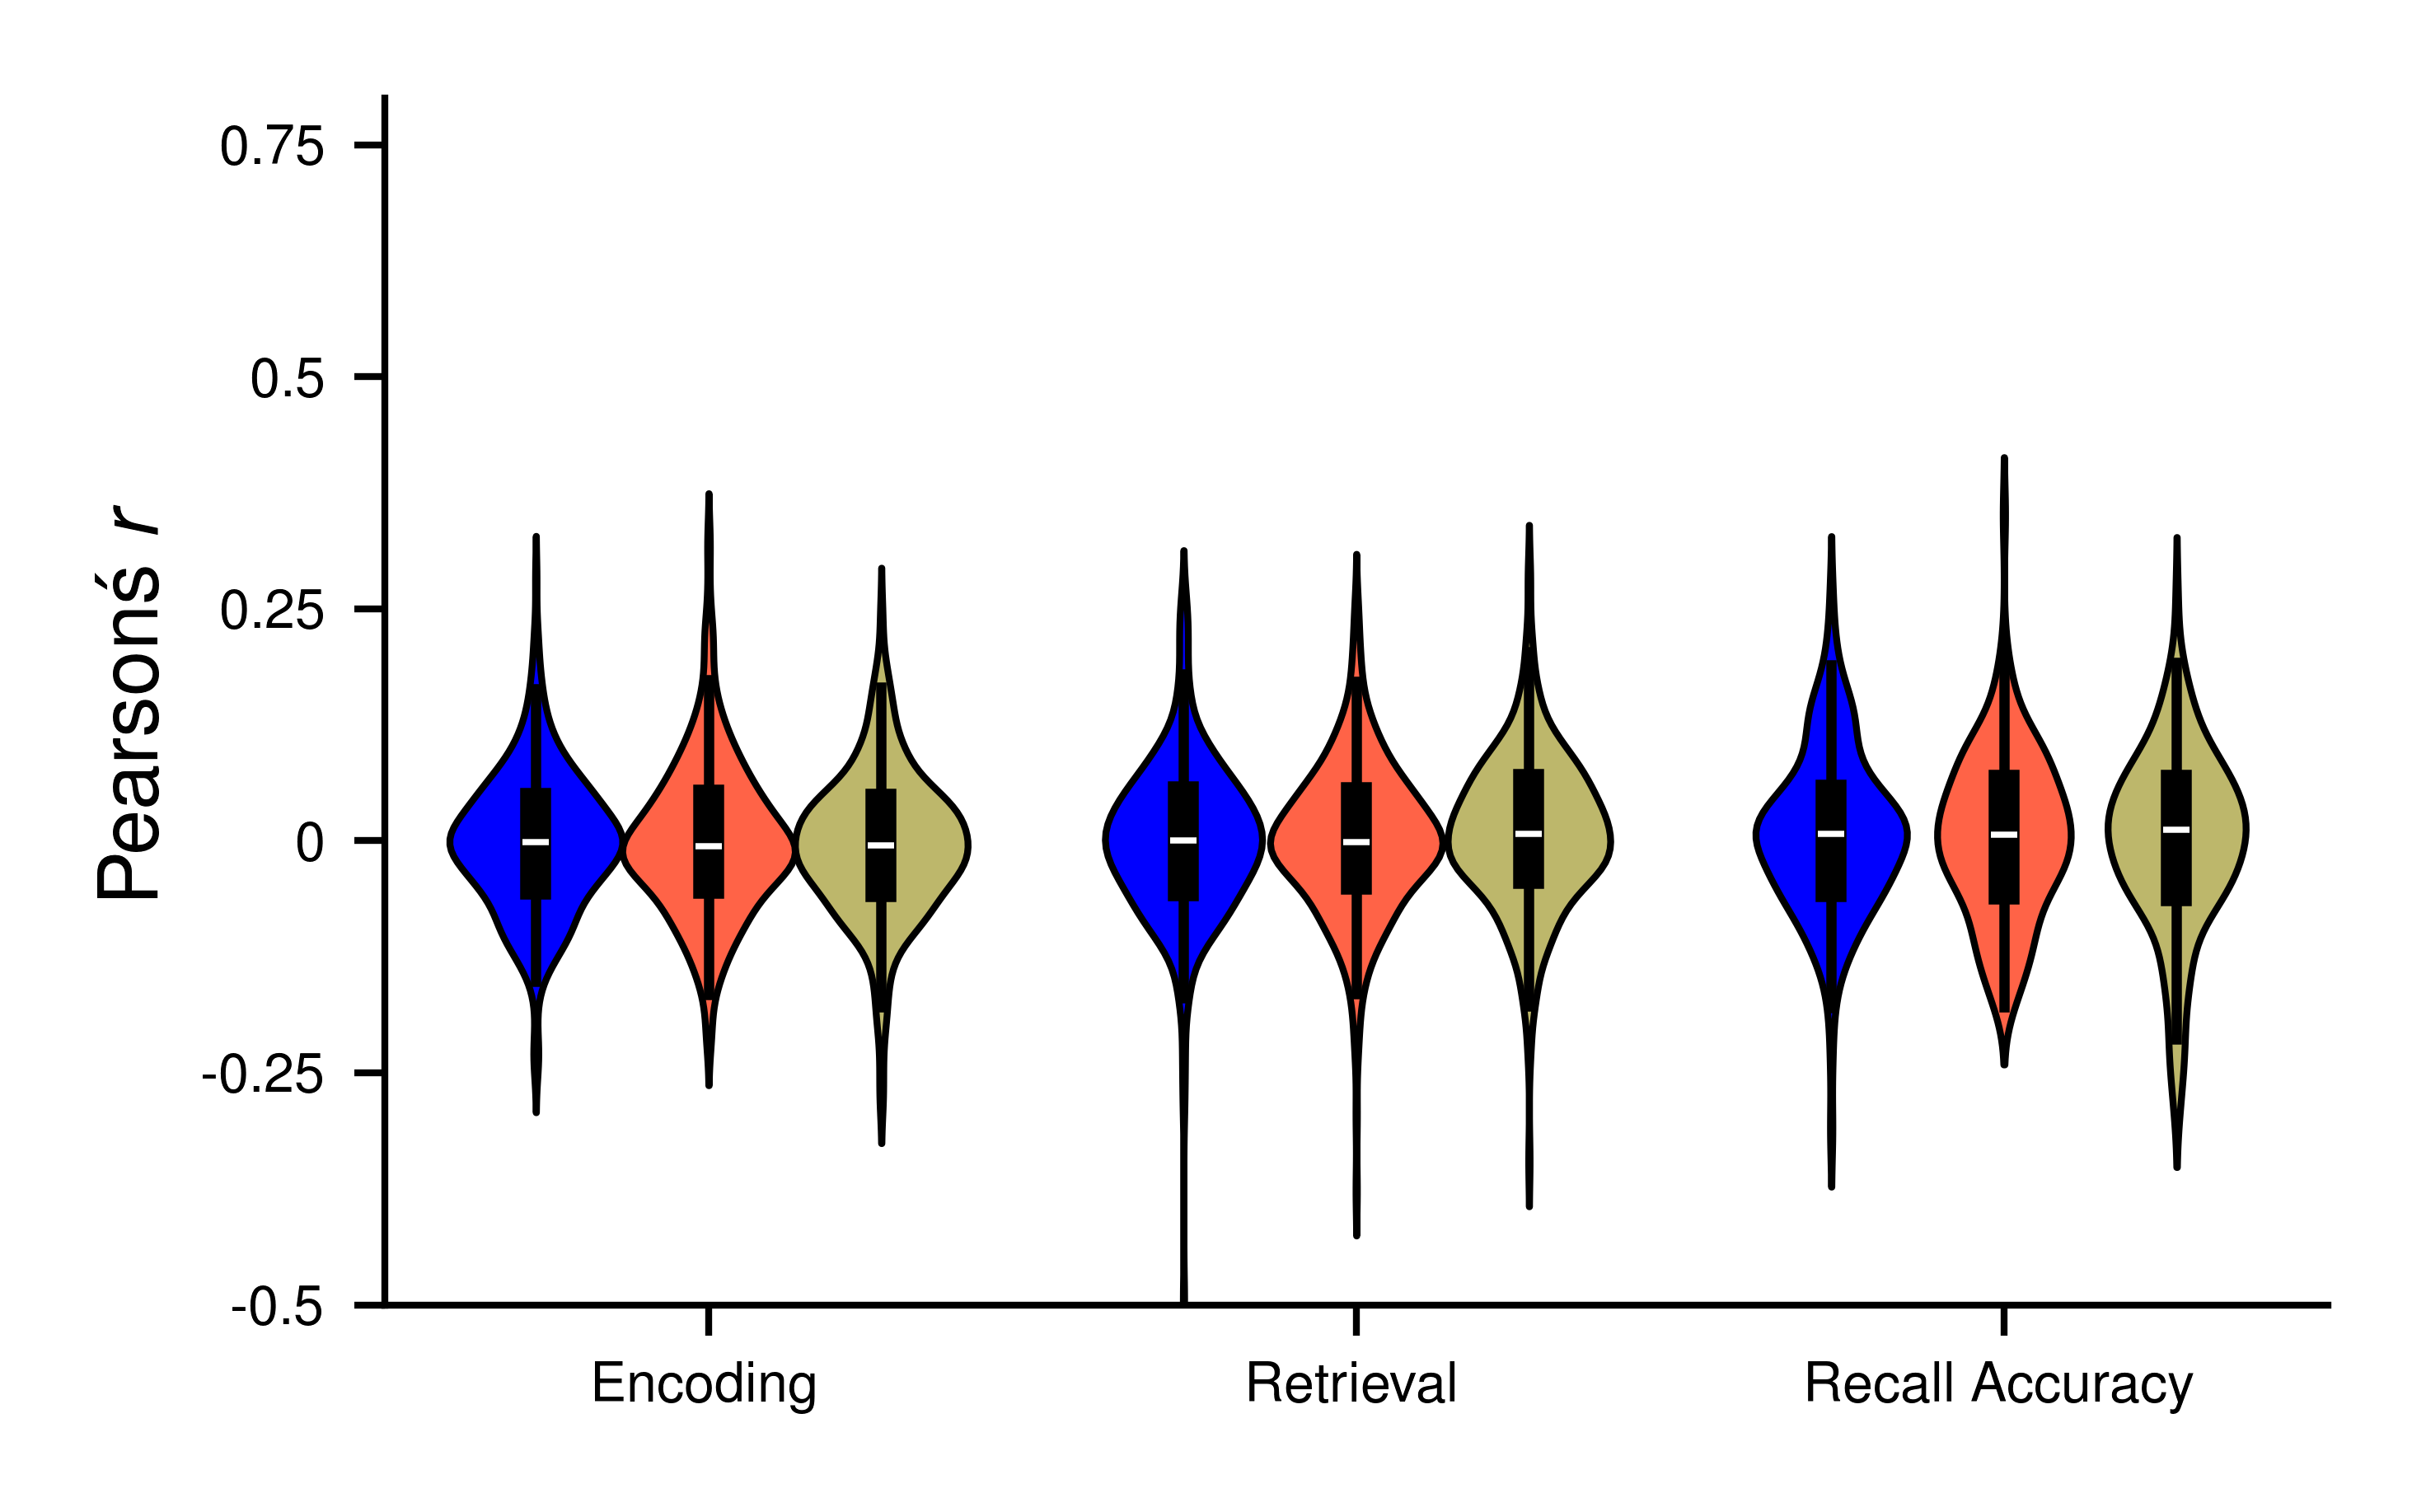

In [158]:
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.5
ymax = 0.8
yticks = [-0.5, -0.25, 0, 0.25, 0.5, 0.75]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.violinplot(x='beh', y='data', hue='freq', data=fig6_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  linewidth=spine_lw, 
                  edgecolor='k',
                 palette=['blue', 'tomato', 'darkkhaki'])
# _ax.legend(fontsize=6, handletextpad=0.5, title=None, loc='upper right')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=4)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel(r'Pearson\'s \textit{r}', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Make region translator

This section is for generating the `region_translator.csv` file that is already provided in the code repository. Therefore, you do not have to re-run it to use the rest of the code.

In [159]:
# all_atlas_labels = []
# sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
# for iSess, rSess in sess_list_df.iterrows():
    
#     if not (rSess['pairs'] == True): continue
    
#     pairs = get_pairs(rSess)
#     atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'das.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
#     atlas_labels = np.unique(pairs[atlases].values.astype(str).ravel())
#     all_atlas_labels = np.append(all_atlas_labels, atlas_labels)
#     localization = get_localization(rSess)
#     if len(localization) > 0:
#         atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['atlases.dk', 'atlases.dkavg', 'atlases.mtl', 'atlases.whole_brain'])], columns=['atlas', 'priority']).query('atlas in @localization.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
#         atlas_labels = np.unique(localization[atlases].values.astype(str).ravel())
#         all_atlas_labels = np.append(all_atlas_labels, atlas_labels)
    
# all_atlas_labels = np.unique(all_atlas_labels)

AttributeError: 'NoneType' object has no attribute 'columns'

In [ ]:
# for iSess, rSess in sess_list_df.iterrows():
    
#     if not (rSess['pairs'] == True): continue
    
#     pairs = get_pairs(rSess)
#     atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
#     atlas_labels = np.unique(pairs[atlases].values.astype(str).ravel())
#     if ('sulcus' in atlas_labels):
#         print(tuple(rSess[['sub','exp','sess','loc','mon']]))

In [ ]:
# df=pd.DataFrame({'atlas_label': all_atlas_labels})
# df['region'] = None

In [ ]:
# for i, r in df.iterrows():
#     if r['region'] is not None: continue
#     df.loc[i, 'region'] = input(r['atlas_label'])

In [ ]:
# def get_hemisphere_from_atlas_label(atlas_label):
    
#     if 'left' in atlas_label.lower():
#         return 'L'
#     elif 'right' in atlas_label.lower():
#         return 'R'
#     else:
#         return 'nan'
# df['hemisphere'] = df.apply(lambda r: get_hemisphere_from_atlas_label(r.name), axis=1)

In [ ]:
# df.to_csv('region_translator.csv', index=True)